In [1]:
import sklearn
import warnings
import tensorflow.compat.v1 as tf
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from xgboost.sklearn import XGBClassifier
# import lightgbm as lgb
import numpy as np
import pickle
import os
from scipy.fftpack import fft
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
tf.disable_eager_execution()

In [2]:
def Feature_Calulate(Raw_Data):
    # PSD
    fs = 500 #采样频率
#     Raw_Data = Raw_Data - np.mean(Raw_Data)
    Data_FFT = fft(Raw_Data,fs)
    Data_PSD = abs(Data_FFT)**2 / fs
    
#     plt.figure()
#     plt.plot(Data_PSD[0:50])
    
    delta = 0
    theta = 0
    alpha = 0
    beta = 0
    gama = 0
    for i in range(1,4):
        delta += Data_PSD[i]
    for i in range(4,8):
        theta += Data_PSD[i]
    for i in range(8,14):
        alpha += Data_PSD[i]
    for i in range(14,31):
        beta += Data_PSD[i]
    for i in range(31,fs//2):
        gama += Data_PSD[i]
           
    # SpecEn
    Data_PSD = Data_PSD/(np.sum(Data_PSD))
    ShannonEntropy = np.multiply(-Data_PSD,np.log(Data_PSD))
    SpecEn=np.sum(ShannonEntropy)/np.log(len(ShannonEntropy))
    
    return [delta,theta,alpha,beta,gama,SpecEn]

In [3]:
# fr = open(os.path.join(r"..\data\data3_attention", fname), 'rb')
# x, Input_label = pickle.load(fr)
# fr.close()

In [43]:
# from math import sin

# fs = 500
# f = 10
# duration = 2.0
# sig = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)

# plt.figure()
# plt.plot(sig)
# fsig = fft(sig, fs)
# plt.figure()
# plt.plot(fsig[0:50])
# # PSD = [x**2 for x in fsig]
# PSD = abs(fsig)**2 / fs
# plt.figure()
# plt.plot(PSD[0:20])

# sig1 = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)
# sig1 = [x + 10 for x in sig1]

# plt.figure()
# plt.plot(sig1)
# fsig1 = fft(sig1, fs)
# plt.figure()
# plt.plot(fsig1[0:50])
# # PSD = [x**2 for x in fsig]
# PSD1 = abs(fsig)**2 / fs
# plt.figure()
# plt.plot(PSD1[0:20])

In [10]:
def data_prepare(fname):

    fr = open(os.path.join(r"..\data\data2", fname), 'rb')
    x, Input_label = pickle.load(fr)
    fr.close()
    print(x.shape)
    
    fs = 500 #采样频率

    Data_Num = len(x) #测试集大小
    Input_Size = len(x[0][0]) #原始序列长度
    Feature_Num = 6 #从每个序列中得到的特征数，本算例中为6
    Channels_Num = len(x[0]) #通道数
    Label_Kinds = 3 # 标签种类 算例为3
    Input_label_CNN = np.zeros([Data_Num,Label_Kinds]) #转换为全连接神经网络喜欢的形式
    for _ in range(Data_Num):
        Input_label_CNN[_][Input_label[_]] = 1 


    Input_Data = np.zeros([Data_Num,Feature_Num*Channels_Num]) #计算特征
    for i in range(Data_Num):
        for j in range(Channels_Num):
            Input_Data[i][j*Feature_Num:(j+1)*Feature_Num] = Feature_Calulate(x[i][j])
    df_X = Input_Data
    df_y = Input_label
    
    return df_X, df_y

In [11]:
#机器学习模型定义
Random_State = 1
lr = LogisticRegression(random_state = 1)
tree = DecisionTreeClassifier(random_state=Random_State) #决策树模型
svm = SVC(probability=True,random_state=Random_State,tol=1e-6)  # SVM模型
forest=RandomForestClassifier(n_estimators=16,random_state=Random_State) #　随机森林
Gbdt=GradientBoostingClassifier(random_state=Random_State) #GBDT
# Xgbc=XGBClassifier(random_state=Random_State)  #Xgbc
# gbm=lgb.LGBMClassifier(random_state=Random_State)  #lgb

In [12]:
# 五折交叉验证
from prettytable import PrettyTable
d = {"lr":[],"tree":[],"svm":[],"forest":[],"Gbdt":[]}

# subs = ['0002','0004','0005','0006','0007','0009','0013','0201','0401','0502','0601','0701','0801','0901','1101','1301']
subs = [
    'dataset_hmx_20210106T180157_raw_filtered_baselineSubtracted_thres100_fp1fp2_1000points_500Hz.pkl'
       ]

for sub in subs:
    
    print("================== Sub #", sub, "==================")
#     fname = "attention_"+sub+"_low_fp1fp2_2s_resampled500Hz.pkl"
    fname = sub
    df_X, df_y = data_prepare(fname)

    # model_name=["lr","tree","svm","forest","Gbdt","Xgbc","gbm"]#模型列表
    
    model_name=["lr","tree","svm","forest","Gbdt"]
    i = 0
    u = PrettyTable(["序号","模型","准确度"])
    for name in model_name:
        model=eval(name)
        accuracy = cross_val_score(model, df_X, df_y, scoring='accuracy', cv=5)
        if i == 0:
            d["lr"].append(accuracy)
        if i == 1:
            d["tree"].append(accuracy)
        if i == 2:
            d["svm"].append(accuracy)
        if i == 3:
            d["forest"].append(accuracy)
        if i == 4:
            d["Gbdt"].append(accuracy)
        i += 1
        u.add_row([i,name,accuracy])
    print(u)

================== Sub # dataset_hmx_20210106T180157_raw_filtered_baselineSubtracted_thres100_fp1fp2_1000points_500Hz.pkl ==================
(857, 2, 1000)
+------+--------+----------------------------------------------------------+
| 序号 |  模型  |                          准确度                          |
+------+--------+----------------------------------------------------------+
|  1   |   lr   | [0.41860465 0.34883721 0.38011696 0.3625731  0.40935673] |
|  2   |  tree  | [0.39534884 0.39534884 0.37426901 0.45614035 0.39766082] |
|  3   |  svm   | [0.37209302 0.35465116 0.28070175 0.33333333 0.33333333] |
|  4   | forest | [0.40697674 0.45348837 0.38011696 0.42690058 0.40935673] |
|  5   |  Gbdt  | [0.4244186  0.45348837 0.45614035 0.47368421 0.40935673] |
+------+--------+----------------------------------------------------------+


In [123]:
d

{'lr': [array([0.55357143, 0.60714286, 0.65868263, 0.52095808, 0.5748503 ]),
  array([0.51785714, 0.50898204, 0.56287425, 0.56287425, 0.61676647]),
  array([0.51190476, 0.48502994, 0.43712575, 0.51497006, 0.54491018]),
  array([0.48809524, 0.38095238, 0.41916168, 0.46706587, 0.52095808]),
  array([0.4702381 , 0.4047619 , 0.4491018 , 0.53892216, 0.46706587]),
  array([0.63095238, 0.54761905, 0.56287425, 0.58682635, 0.45508982]),
  array([0.55357143, 0.45833333, 0.47305389, 0.65868263, 0.65868263]),
  array([0.43030303, 0.39393939, 0.40606061, 0.4       , 0.44512195]),
  array([0.43636364, 0.41818182, 0.41818182, 0.36969697, 0.36585366]),
  array([0.46428571, 0.43452381, 0.44311377, 0.43712575, 0.4251497 ]),
  array([0.38323353, 0.44311377, 0.48502994, 0.4011976 , 0.45508982]),
  array([0.48502994, 0.47904192, 0.40718563, 0.4491018 , 0.4491018 ]),
  array([0.4011976 , 0.46706587, 0.43712575, 0.4491018 , 0.41916168]),
  array([0.71428571, 0.69642857, 0.68862275, 0.65868263, 0.68862275]),


In [128]:
seq = [[] for _ in range(5)]
for i, m in enumerate(["lr","tree","svm","forest","Gbdt"]):
    temp = d[m]
    for x in temp:
        seq[i].append(np.mean(x))
pd.DataFrame.transpose(pd.DataFrame(seq)).to_csv(r"..\data\data3_attention\t.csv")

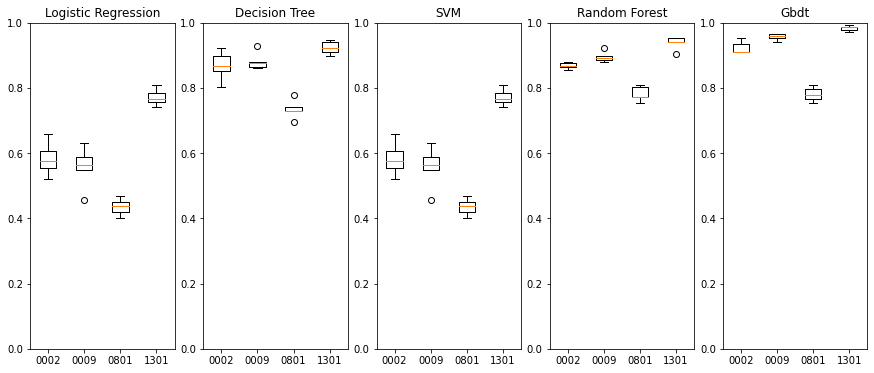

In [18]:
import matplotlib.pyplot as plt

labels = subs

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
fig.subplots_adjust(hspace=.5)
axes[0].set_ylim([0,1])
axes[0].set_title("Logistic Regression")
axes[1].set_ylim([0,1])
axes[1].set_title("Decision Tree")
axes[2].set_ylim([0,1])
axes[2].set_title("SVM")
axes[3].set_ylim([0,1])
axes[3].set_title("Random Forest")
axes[4].set_ylim([0,1])
axes[4].set_title("Gbdt")

bplot_lr = axes[0].boxplot(d['lr'],
                           vert = True,
                           labels=labels
                          )
bplot_tree = axes[1].boxplot(d['tree'],
                           vert = True,
                           labels=labels
                          )
bplot_svm = axes[2].boxplot(d['lr'],
                           vert = True,
                           labels=labels
                          )
bplot_forest = axes[3].boxplot(d['forest'],
                           vert = True,
                           labels=labels
                          )
bplot_Gbdt = axes[4].boxplot(d['Gbdt'],
                           vert = True,
                           labels=labels
                          )
plt.savefig(r"..\data\data3_attention\fig\SelectModel.jpg")

## Cross Test

In [156]:
import tensorflow as tf
from tensorflow.math import confusion_matrix

def pl(y_test, y_pred, accuracy, train, test):

    classes = [0,1,2]
    # argmax: reverse the to_categorical operation
    with tf.compat.v1.Session() as sess:
        con_mat = confusion_matrix(y_test, predictions=y_pred).eval()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm,
                         index = classes, 
                         columns = classes)
    figure = plt.figure(figsize=(4,4))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)

    print("Accuracy:", accuracy)
    print("Confusion matrix:")
    for i in con_mat:
        print(i)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.draw()
    plt.savefig(r"D:\GitHub\EEG_fatigue\data\data3_attention\fig\cross_gbdt\cr"+train+test+".jpg")


In [177]:
def data_prepare_tn(fname):

    fr = open(os.path.join(r"..\data\data3_attention", fname), 'rb')
    x, Input_label = pickle.load(fr)
    fr.close()
    print(x.shape)
    x = x[0:600]
    Input_label = Input_label[0:600]
    
    fs = 500 #采样频率

    Data_Num = len(x) #测试集大小
    Input_Size = len(x[0][0]) #原始序列长度
    Feature_Num = 6 #从每个序列中得到的特征数，本算例中为6
    Channels_Num = len(x[0]) #通道数
    Label_Kinds = 3 # 标签种类 算例为3
    Input_label_CNN = np.zeros([Data_Num,Label_Kinds]) #转换为全连接神经网络喜欢的形式
    for _ in range(Data_Num):
        Input_label_CNN[_][Input_label[_]] = 1 


    Input_Data = np.zeros([Data_Num,Feature_Num*Channels_Num]) #计算特征
    for i in range(Data_Num):
        for j in range(Channels_Num):
            Input_Data[i][j*Feature_Num:(j+1)*Feature_Num] = Feature_Calulate(x[i][j])
    df_X = Input_Data
    df_y = Input_label
    
    return df_X, df_y

def data_prepare_te(fname):

    fr = open(os.path.join(r"..\data\data3_attention", fname), 'rb')
    x, Input_label = pickle.load(fr)
    fr.close()
    print(x.shape)
    x = x[600:800]
    Input_label = Input_label[600:800]
    
    fs = 500 #采样频率

    Data_Num = len(x) #测试集大小
    Input_Size = len(x[0][0]) #原始序列长度
    Feature_Num = 6 #从每个序列中得到的特征数，本算例中为6
    Channels_Num = len(x[0]) #通道数
    Label_Kinds = 3 # 标签种类 算例为3
    Input_label_CNN = np.zeros([Data_Num,Label_Kinds]) #转换为全连接神经网络喜欢的形式
    for _ in range(Data_Num):
        Input_label_CNN[_][Input_label[_]] = 1 


    Input_Data = np.zeros([Data_Num,Feature_Num*Channels_Num]) #计算特征
    for i in range(Data_Num):
        for j in range(Channels_Num):
            Input_Data[i][j*Feature_Num:(j+1)*Feature_Num] = Feature_Calulate(x[i][j])
    df_X = Input_Data
    df_y = Input_label
    
    return df_X, df_y

=================== Sub # 0002 ==================
(837, 2, 1000)
(837, 2, 1000)
Accuracy: 0.915
Confusion matrix:
[71  5  2]
[ 8 55  0]
[ 2  0 57]
Predicted: Sub # 0002
(836, 2, 1000)
Accuracy: 0.41
Confusion matrix:
[27  0 51]
[21  0 41]
[ 5  0 55]
Predicted: Sub # 0004
(836, 2, 1000)
Accuracy: 0.355
Confusion matrix:
[55  0 23]
[32  0 30]
[44  0 16]
Predicted: Sub # 0005
(837, 2, 1000)
Accuracy: 0.4
Confusion matrix:
[28 50  0]
[11 52  0]
[ 1 58  0]
Predicted: Sub # 0006
(837, 2, 1000)
Accuracy: 0.49
Confusion matrix:
[35 30 13]
[ 0 63  0]
[12 47  0]
Predicted: Sub # 0007
(837, 2, 1000)
Accuracy: 0.465
Confusion matrix:
[58 19  1]
[28 35  0]
[39 20  0]
Predicted: Sub # 0009
(837, 2, 1000)
Accuracy: 0.52
Confusion matrix:
[41 32  5]
[ 0 63  0]
[ 3 56  0]
Predicted: Sub # 0013
(824, 2, 1000)
Accuracy: 0.29
Confusion matrix:
[ 3  0 68]
[ 9  0 53]
[11  1 55]
Predicted: Sub # 0201
(824, 2, 1000)
Accuracy: 0.295
Confusion matrix:
[ 5  0 73]
[ 6  0 55]
[ 7  0 54]
Predicted: Sub # 0401
(837,

Accuracy: 0.515
Confusion matrix:
[78  0  0]
[61  1  0]
[28  8 24]
Predicted: Sub # 0801
(837, 2, 1000)
Accuracy: 0.315
Confusion matrix:
[ 0 78  0]
[ 0 63  0]
[ 0 59  0]
Predicted: Sub # 0901
(837, 2, 1000)
Accuracy: 0.695
Confusion matrix:
[76  1  1]
[ 0 63  0]
[21 38  0]
Predicted: Sub # 1101
(837, 2, 1000)
Accuracy: 0.705
Confusion matrix:
[78  0  0]
[ 0 63  0]
[ 0 59  0]
Predicted: Sub # 1301
=================== Sub # 0009 ==================
(837, 2, 1000)
(837, 2, 1000)
Accuracy: 0.38
Confusion matrix:
[73  1  4]
[60  0  3]
[56  0  3]
Predicted: Sub # 0002
(836, 2, 1000)
Accuracy: 0.365
Confusion matrix:
[73  0  5]
[40  0 22]
[60  0  0]
Predicted: Sub # 0004
(836, 2, 1000)
Accuracy: 0.39
Confusion matrix:
[78  0  0]
[62  0  0]
[60  0  0]
Predicted: Sub # 0005
(837, 2, 1000)
Accuracy: 0.405
Confusion matrix:
[78  0  0]
[61  2  0]
[49  9  1]
Predicted: Sub # 0006
(837, 2, 1000)
Accuracy: 0.49
Confusion matrix:
[78  0  0]
[42 20  1]
[59  0  0]
Predicted: Sub # 0007
(837, 2, 1000)
Ac

Accuracy: 0.75
Confusion matrix:
[75  2  1]
[ 1 37 25]
[ 1 20 38]
Predicted: Sub # 0502
(835, 2, 1000)
Accuracy: 0.41
Confusion matrix:
[59  1 18]
[ 1 15 46]
[51  1  8]
Predicted: Sub # 0601
(835, 2, 1000)
Accuracy: 0.385
Confusion matrix:
[65 13  0]
[47  6  9]
[48  6  6]
Predicted: Sub # 0701
(835, 2, 1000)
Accuracy: 0.41
Confusion matrix:
[74  3  1]
[59  0  3]
[ 4 48  8]
Predicted: Sub # 0801
(837, 2, 1000)
Accuracy: 0.285
Confusion matrix:
[ 0 54 24]
[ 0 49 14]
[ 0 51  8]
Predicted: Sub # 0901
(837, 2, 1000)
Accuracy: 0.635
Confusion matrix:
[52 12 14]
[ 0 59  4]
[28 15 16]
Predicted: Sub # 1101
(837, 2, 1000)
Accuracy: 0.66
Confusion matrix:
[71  2  5]
[ 0 61  2]
[ 0 59  0]
Predicted: Sub # 1301
=================== Sub # 0601 ==================
(835, 2, 1000)
(837, 2, 1000)
Accuracy: 0.33
Confusion matrix:
[ 4 67  7]
[ 4 49 10]
[27 19 13]
Predicted: Sub # 0002
(836, 2, 1000)
Accuracy: 0.435
Confusion matrix:
[41 16 21]
[49 11  2]
[24  1 35]
Predicted: Sub # 0004
(836, 2, 1000)
Accu

Accuracy: 0.555
Confusion matrix:
[41  0 37]
[ 0 41 22]
[ 7 23 29]
Predicted: Sub # 0013
(824, 2, 1000)
Accuracy: 0.37
Confusion matrix:
[68  0  3]
[56  1  5]
[62  0  5]
Predicted: Sub # 0201
(824, 2, 1000)
Accuracy: 0.395
Confusion matrix:
[74  0  4]
[57  0  4]
[56  0  5]
Predicted: Sub # 0401
(837, 2, 1000)
Accuracy: 0.66
Confusion matrix:
[78  0  0]
[ 7  8 48]
[ 7  6 46]
Predicted: Sub # 0502
(835, 2, 1000)
Accuracy: 0.285
Confusion matrix:
[49  0 29]
[ 8  8 46]
[60  0  0]
Predicted: Sub # 0601
(835, 2, 1000)
Accuracy: 0.39
Confusion matrix:
[78  0  0]
[18  0 44]
[60  0  0]
Predicted: Sub # 0701
(835, 2, 1000)
Accuracy: 0.4
Confusion matrix:
[78  0  0]
[61  0  1]
[52  6  2]
Predicted: Sub # 0801
(837, 2, 1000)
Accuracy: 0.32
Confusion matrix:
[ 0 76  2]
[ 0 63  0]
[ 0 58  1]
Predicted: Sub # 0901
(837, 2, 1000)
Accuracy: 0.975
Confusion matrix:
[77  0  1]
[ 0 63  0]
[ 4  0 55]
Predicted: Sub # 1101
(837, 2, 1000)
Accuracy: 0.705
Confusion matrix:
[78  0  0]
[ 0 63  0]
[ 0 59  0]
Pre

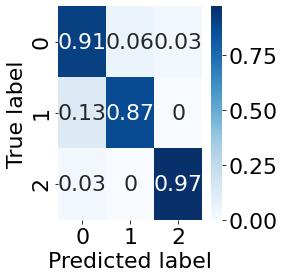

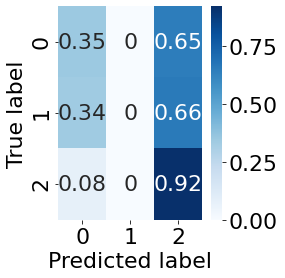

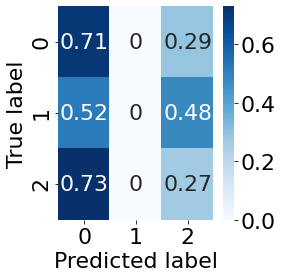

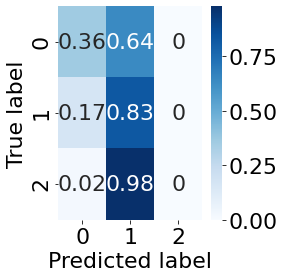

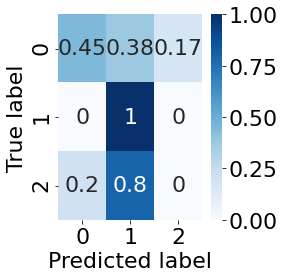

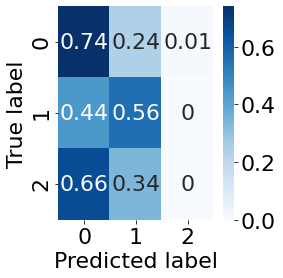

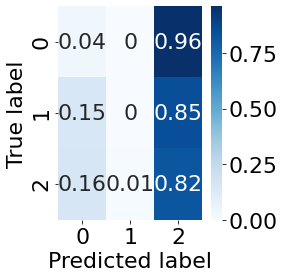

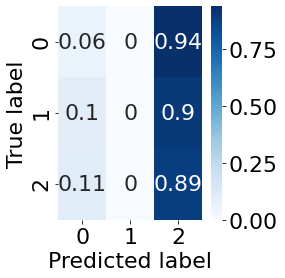

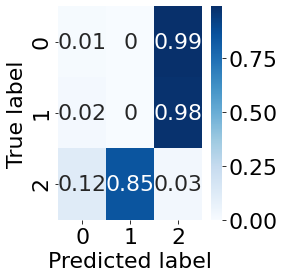

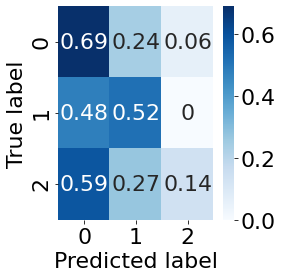

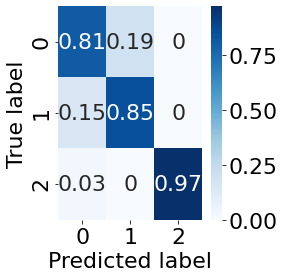

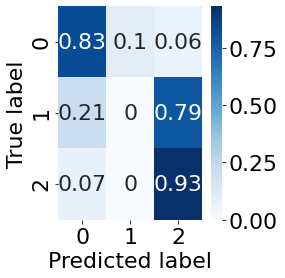

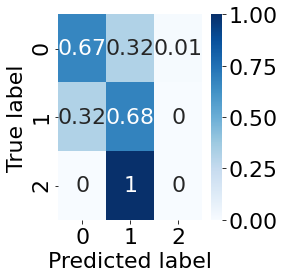

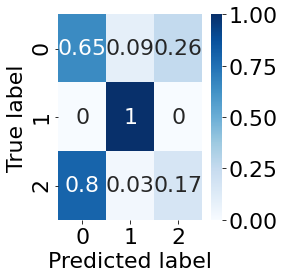

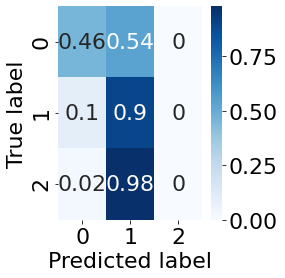

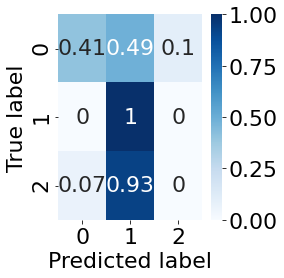

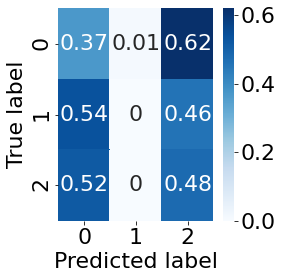

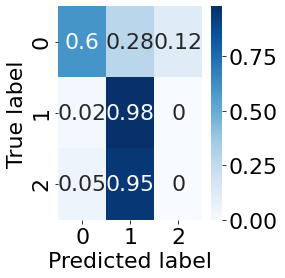

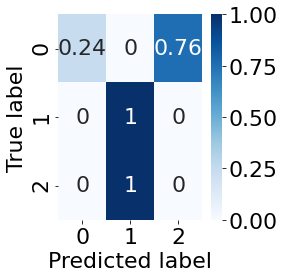

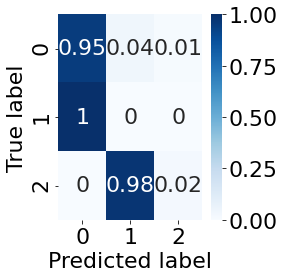

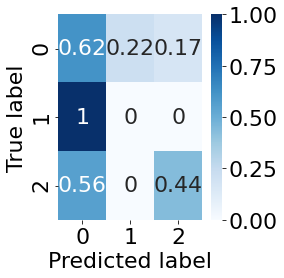

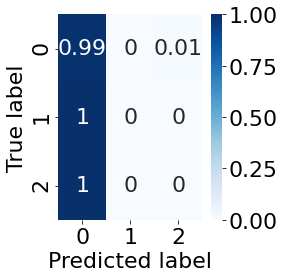

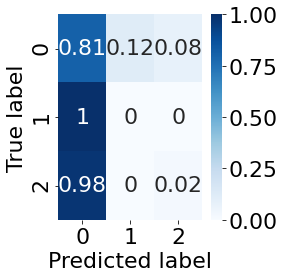

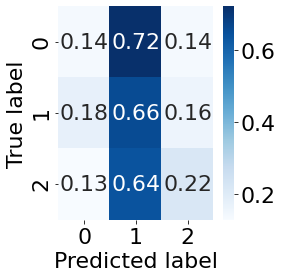

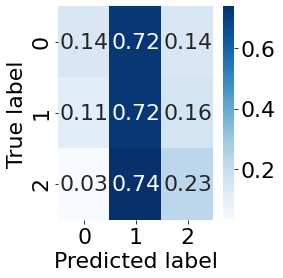

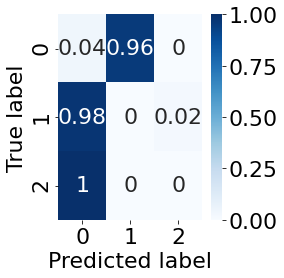

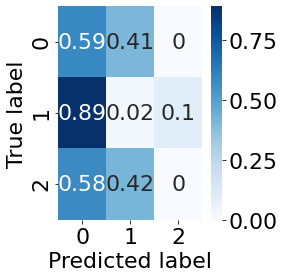

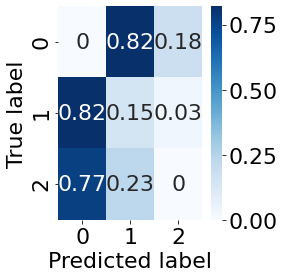

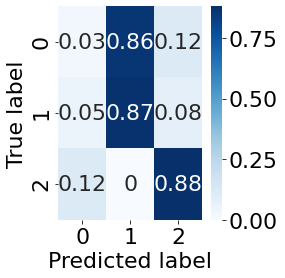

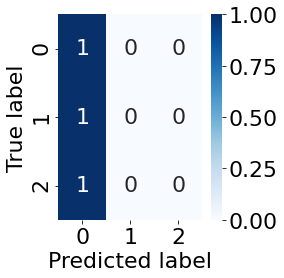

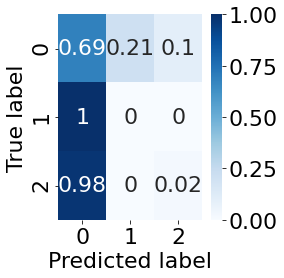

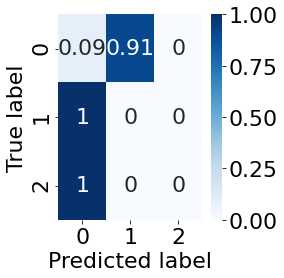

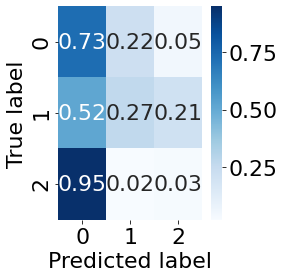

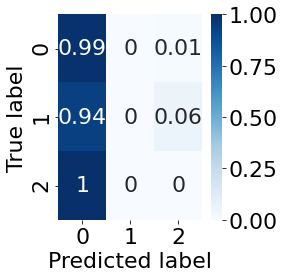

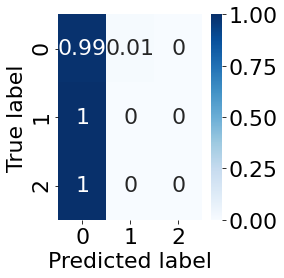

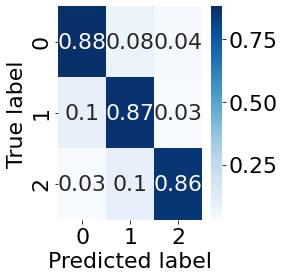

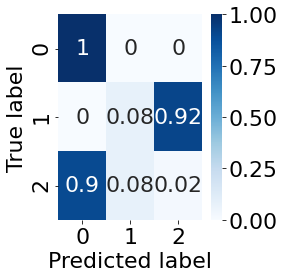

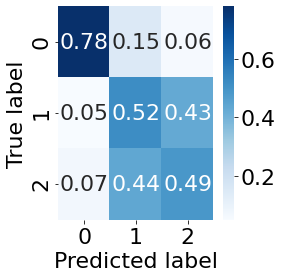

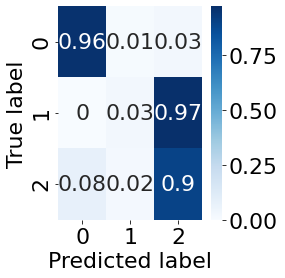

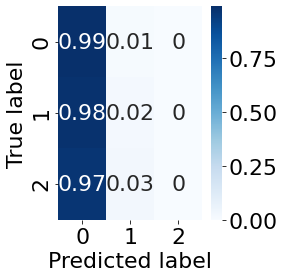

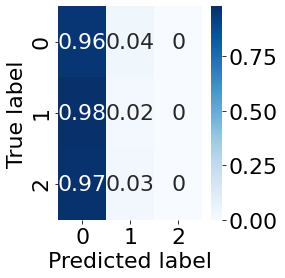

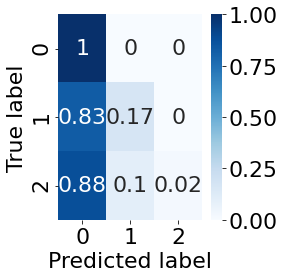

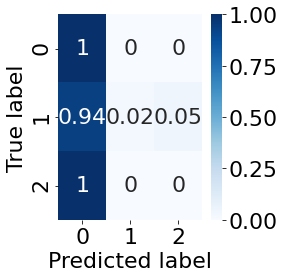

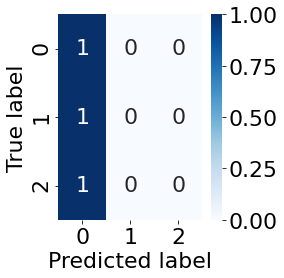

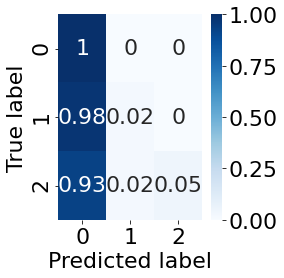

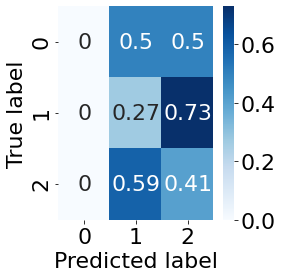

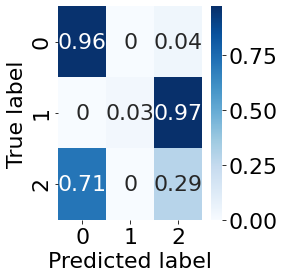

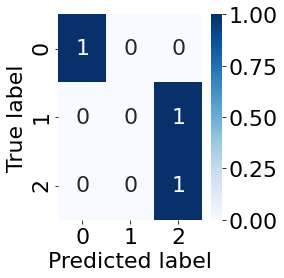

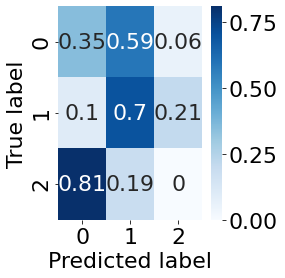

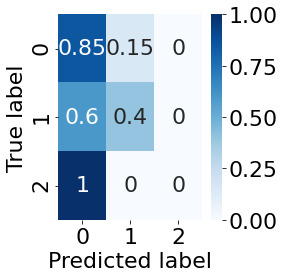

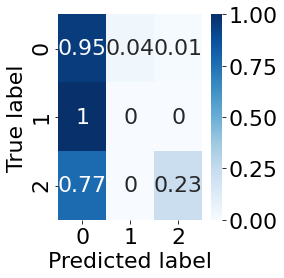

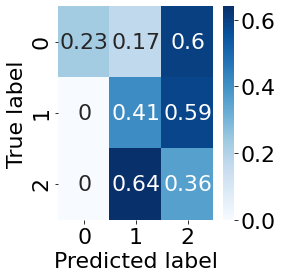

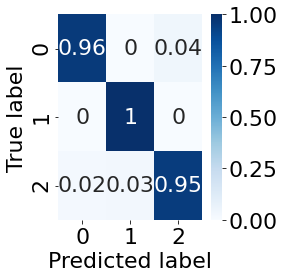

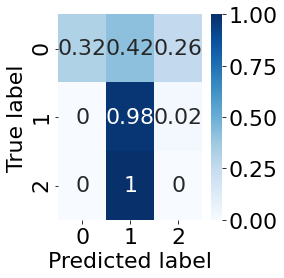

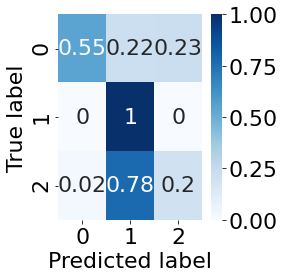

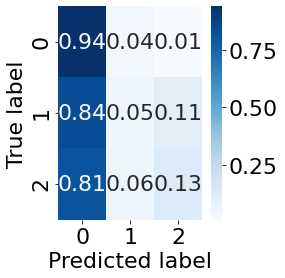

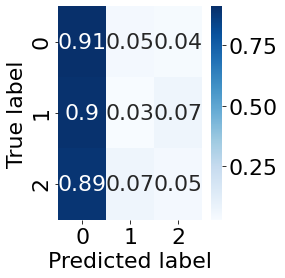

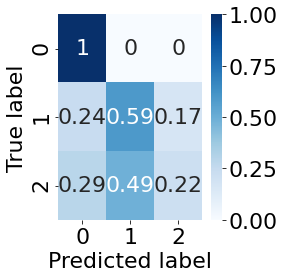

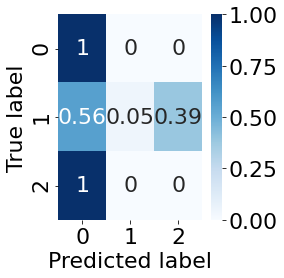

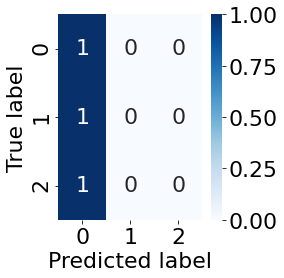

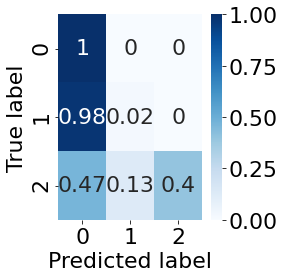

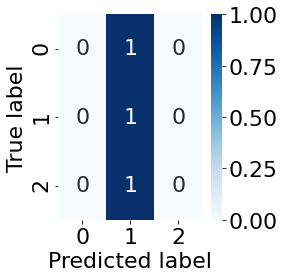

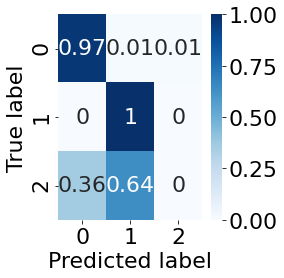

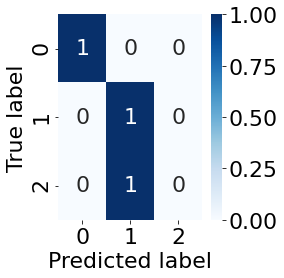

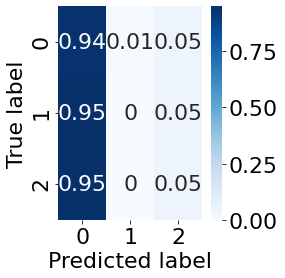

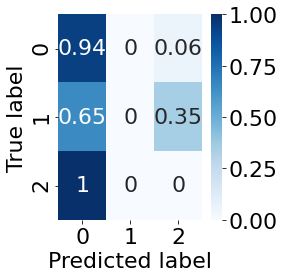

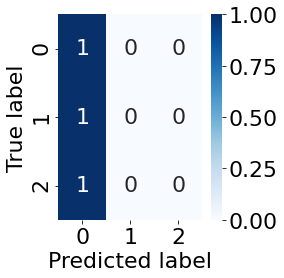

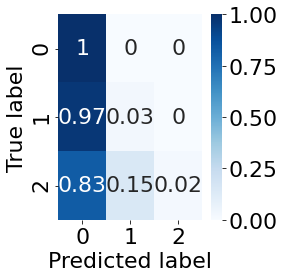

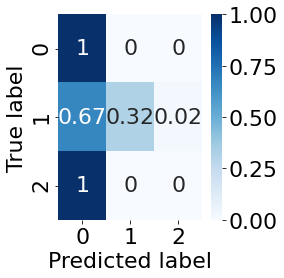

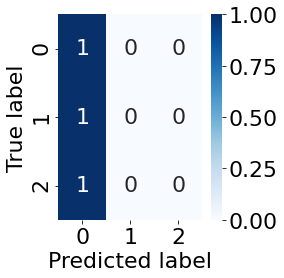

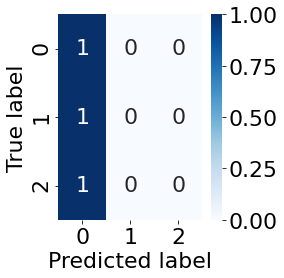

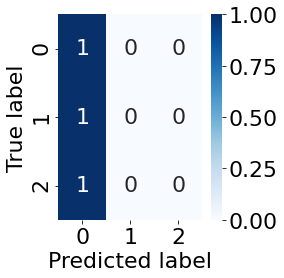

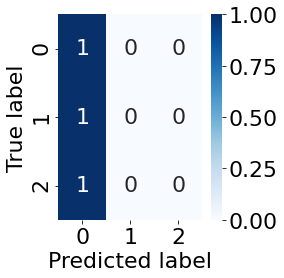

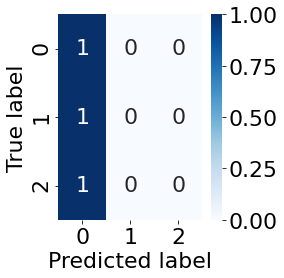

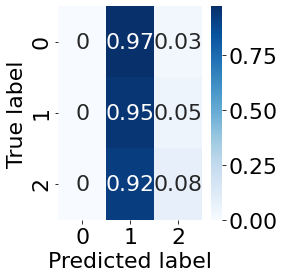

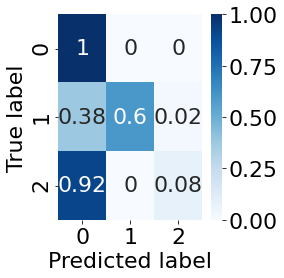

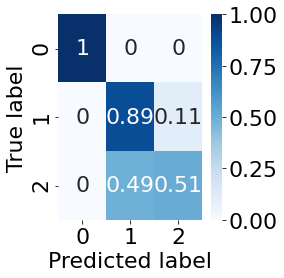

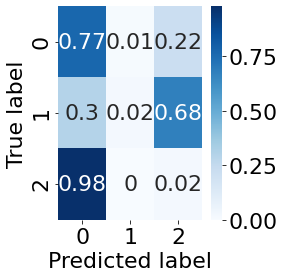

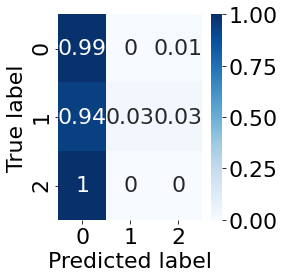

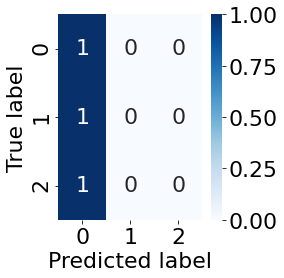

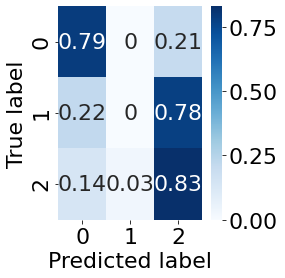

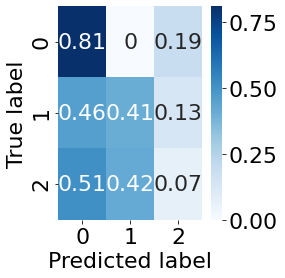

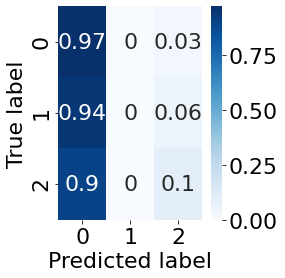

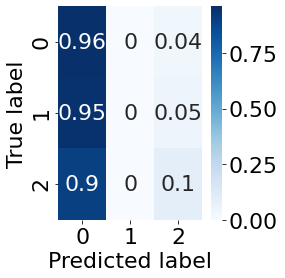

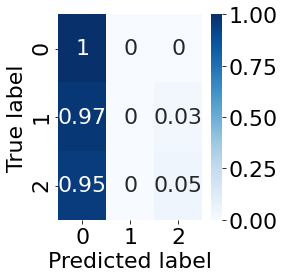

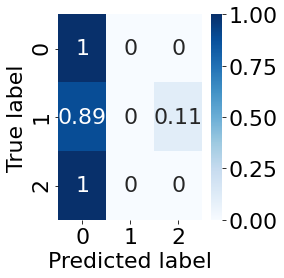

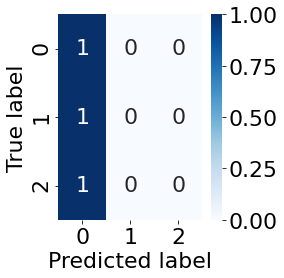

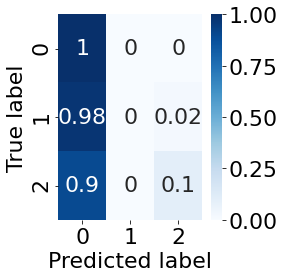

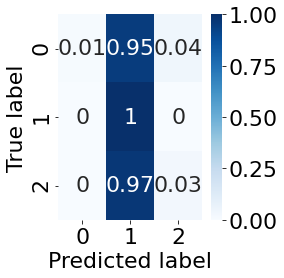

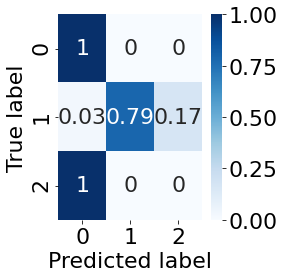

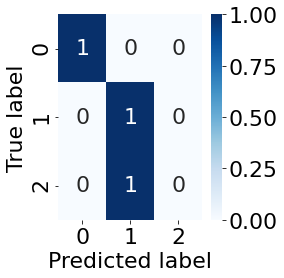

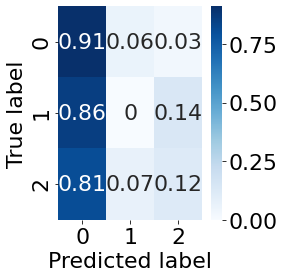

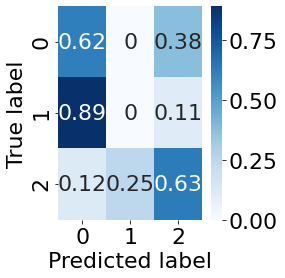

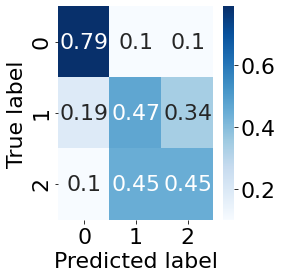

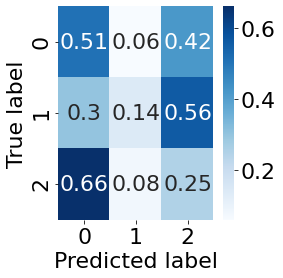

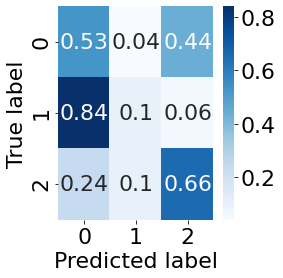

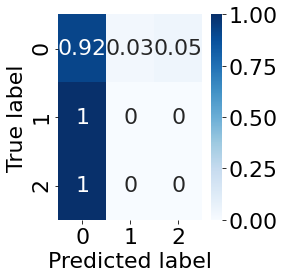

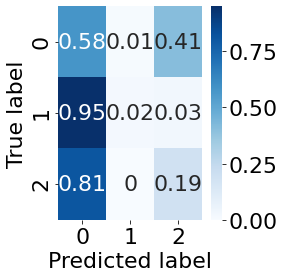

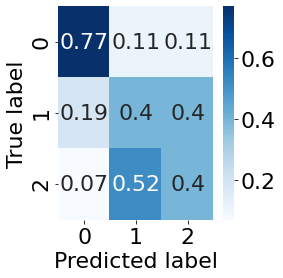

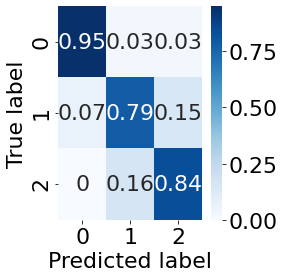

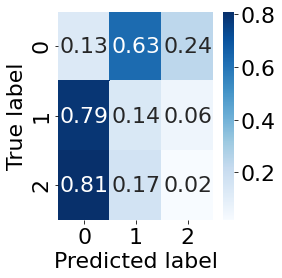

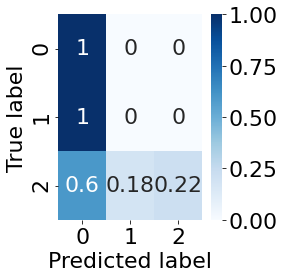

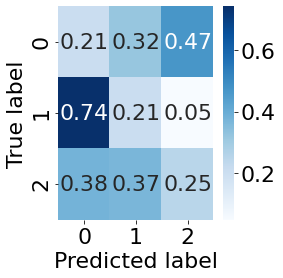

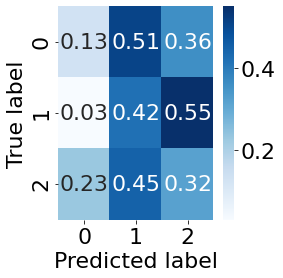

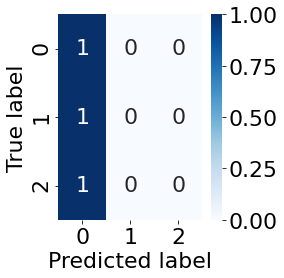

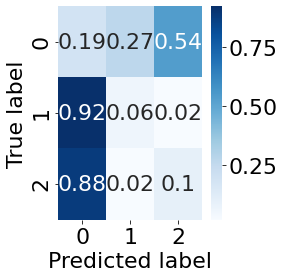

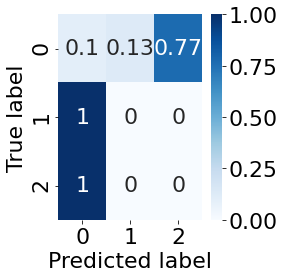

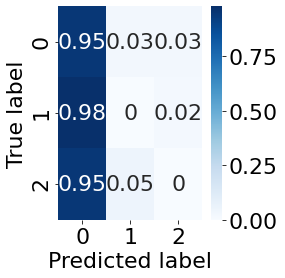

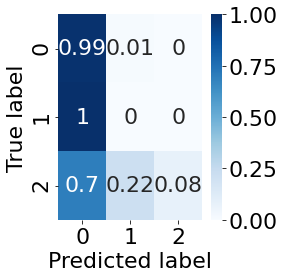

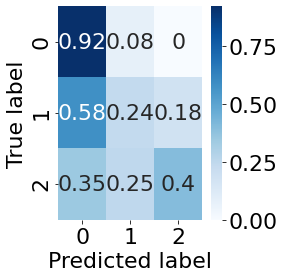

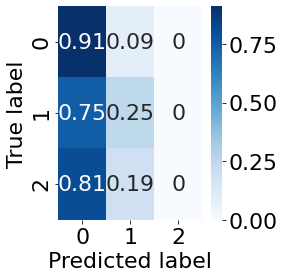

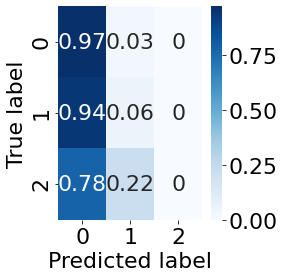

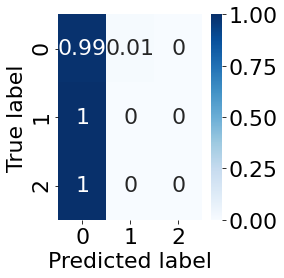

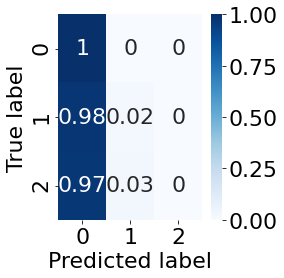

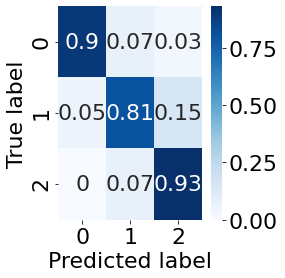

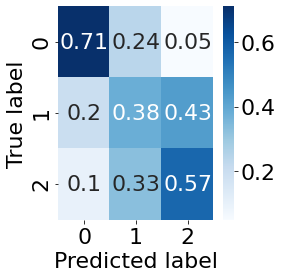

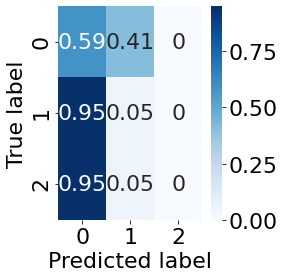

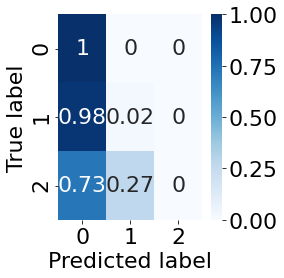

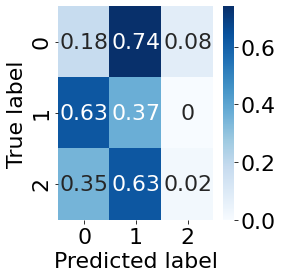

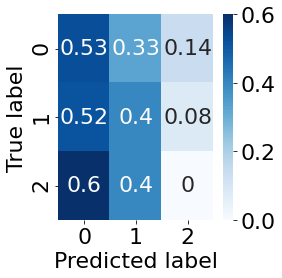

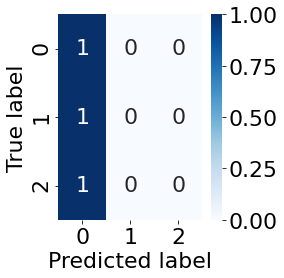

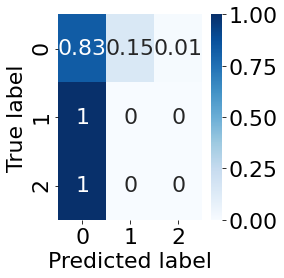

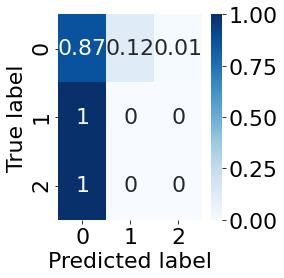

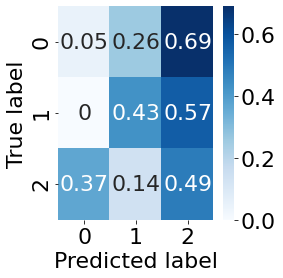

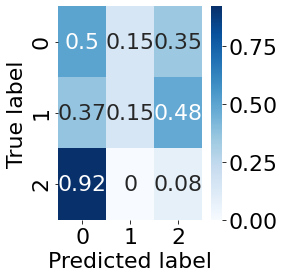

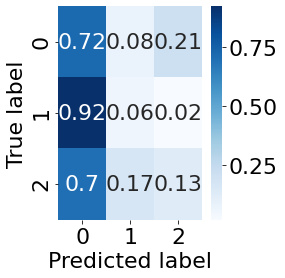

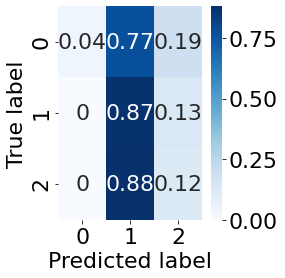

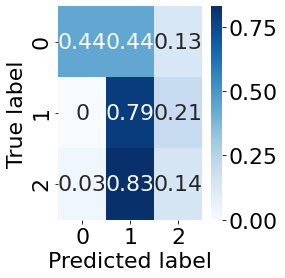

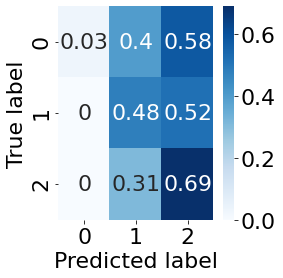

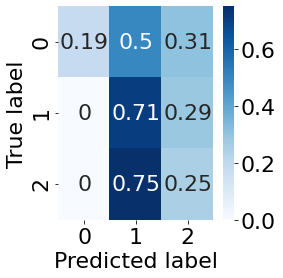

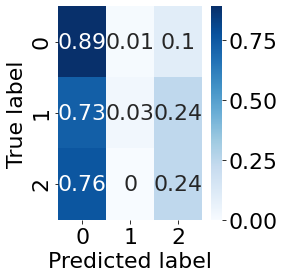

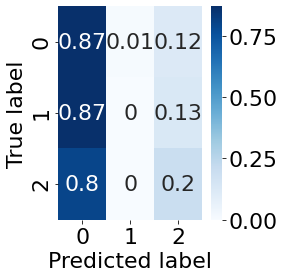

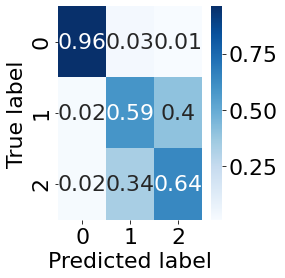

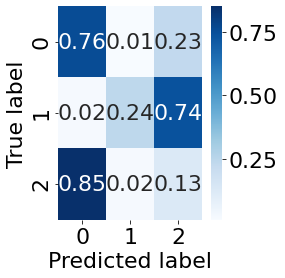

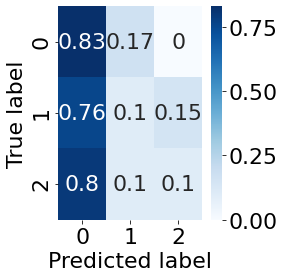

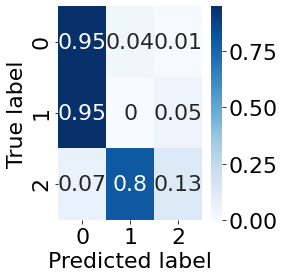

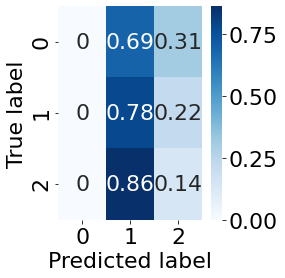

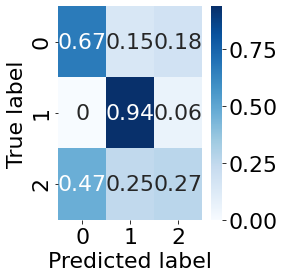

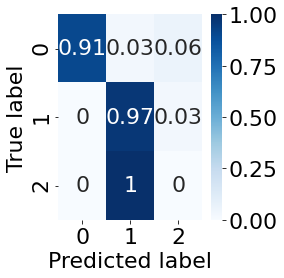

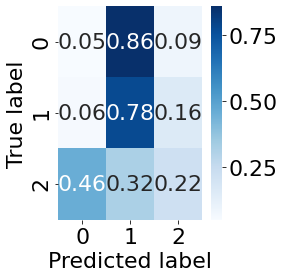

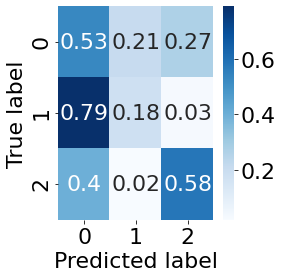

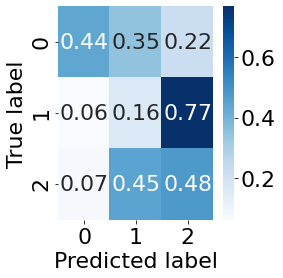

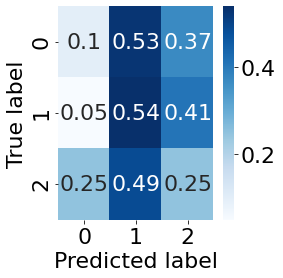

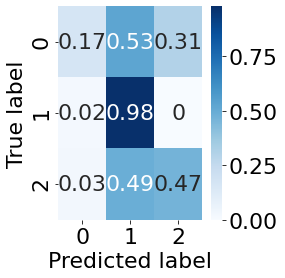

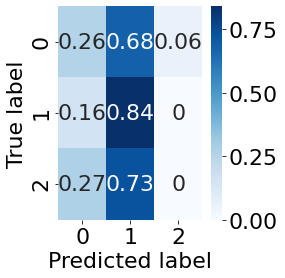

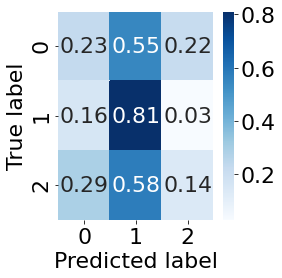

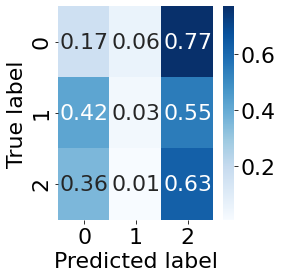

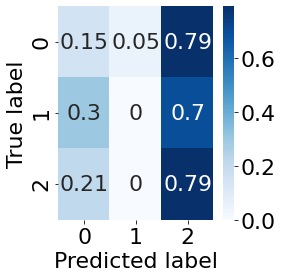

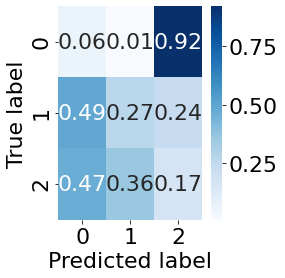

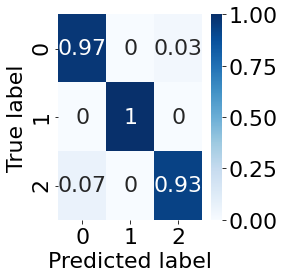

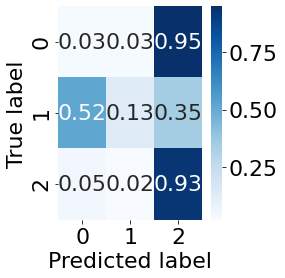

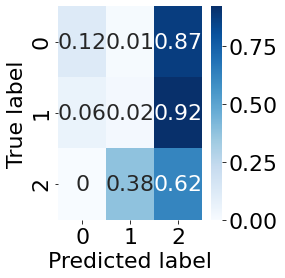

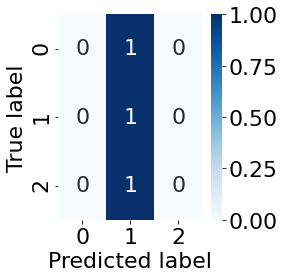

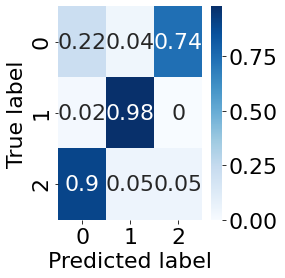

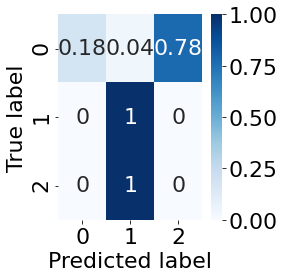

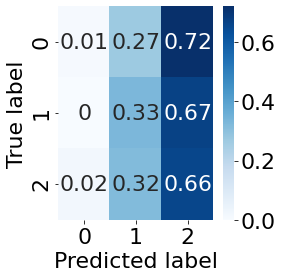

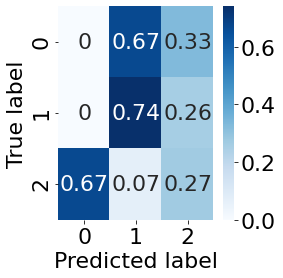

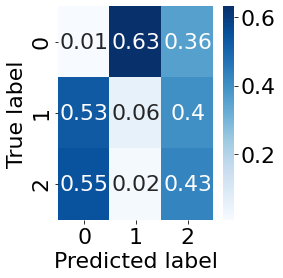

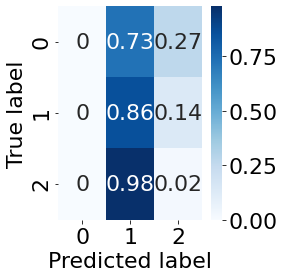

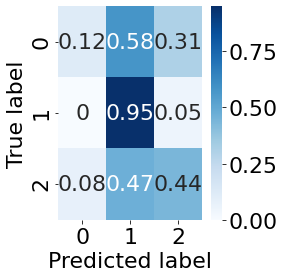

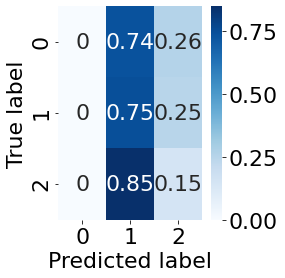

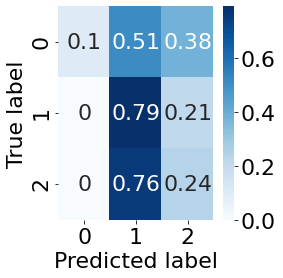

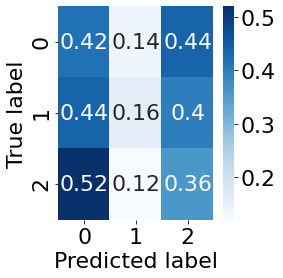

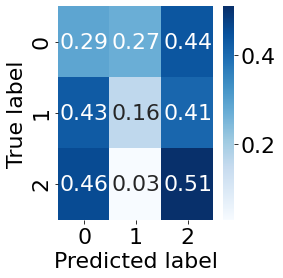

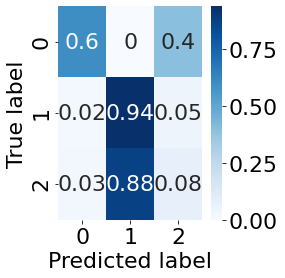

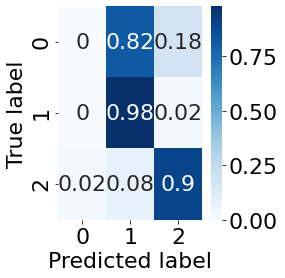

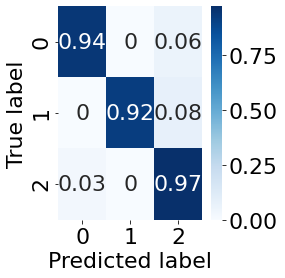

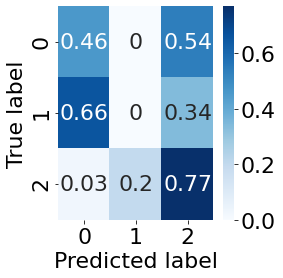

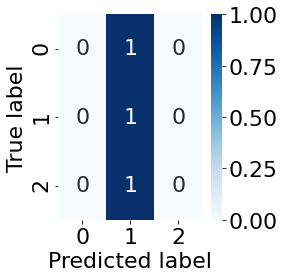

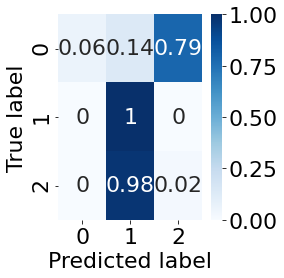

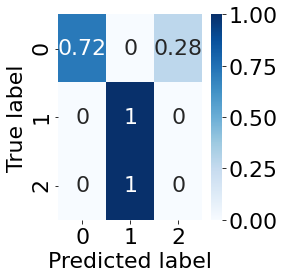

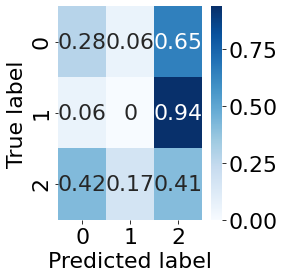

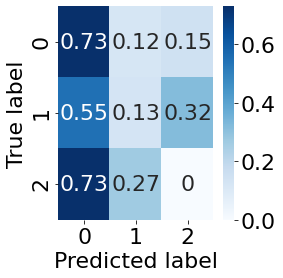

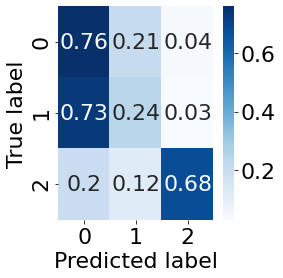

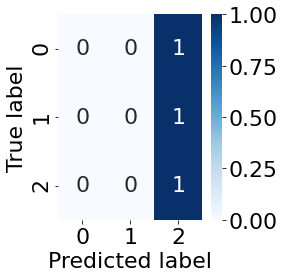

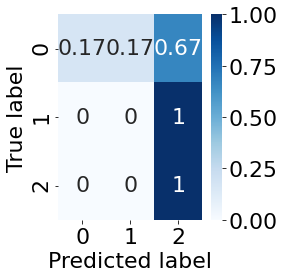

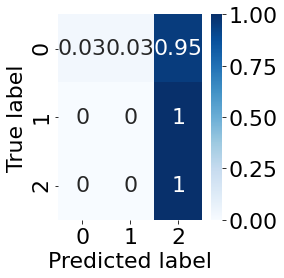

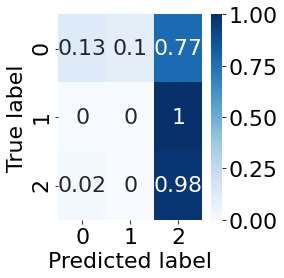

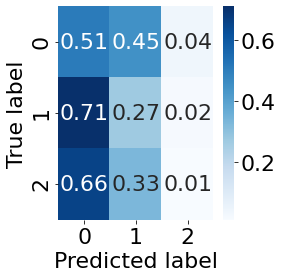

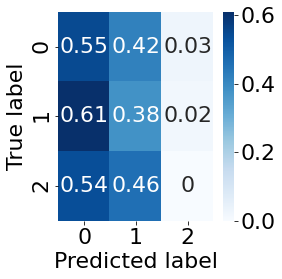

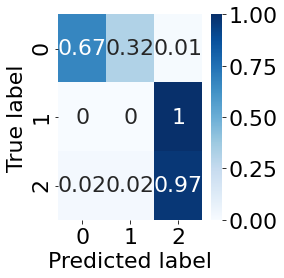

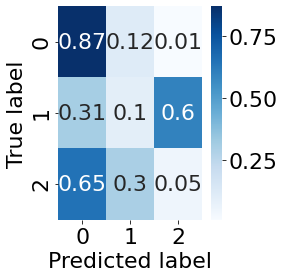

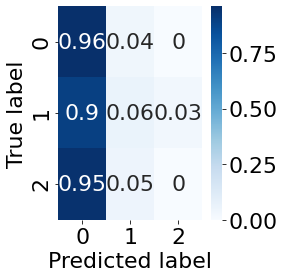

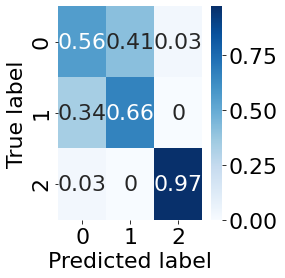

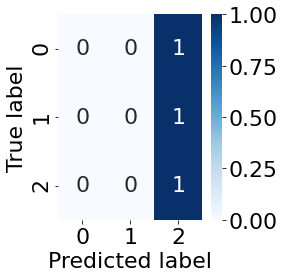

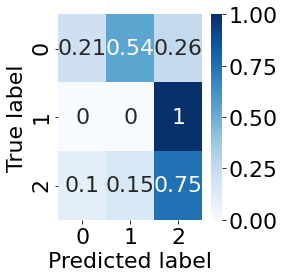

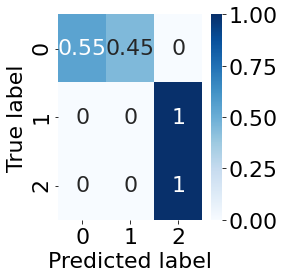

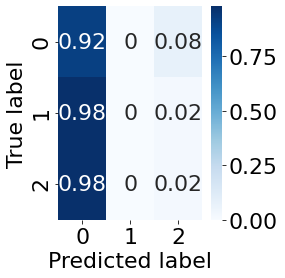

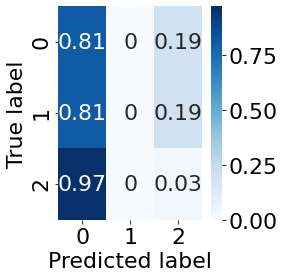

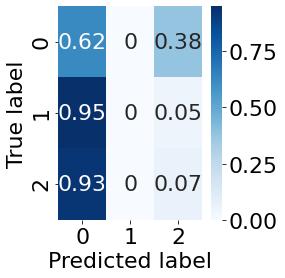

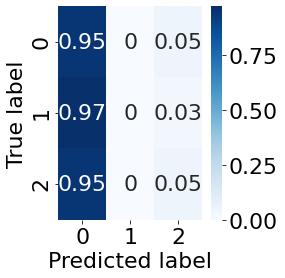

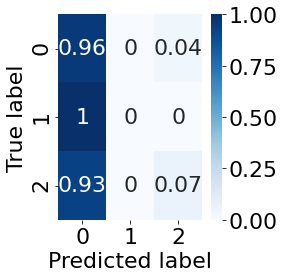

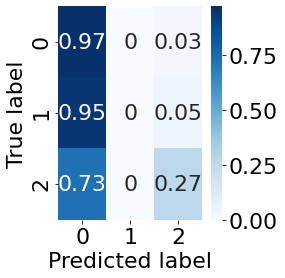

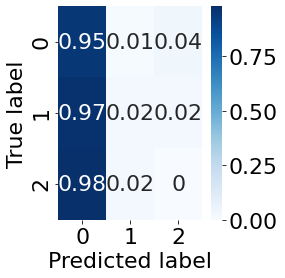

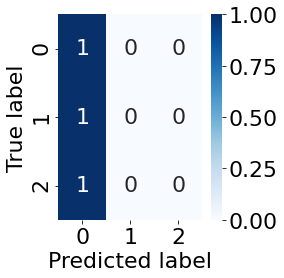

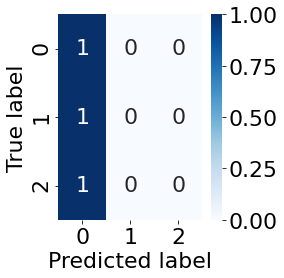

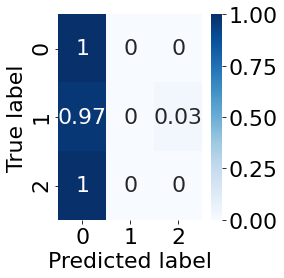

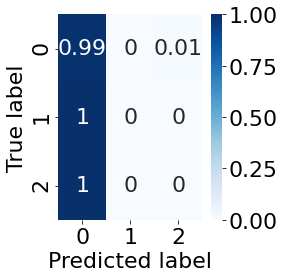

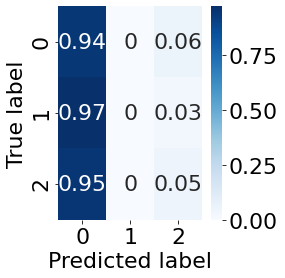

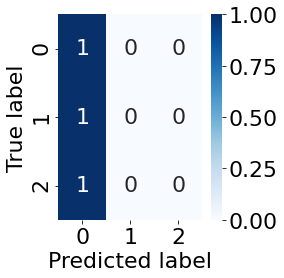

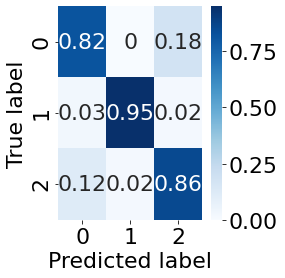

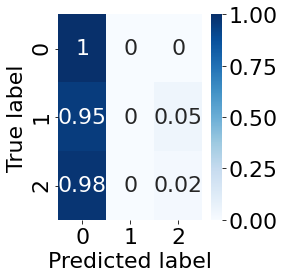

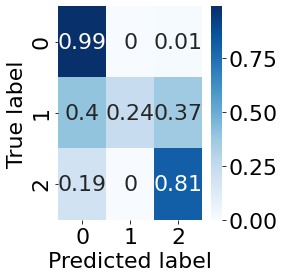

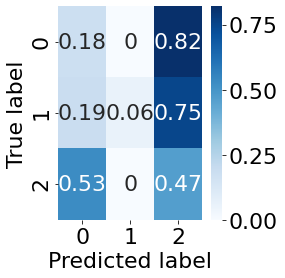

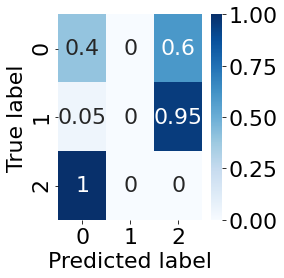

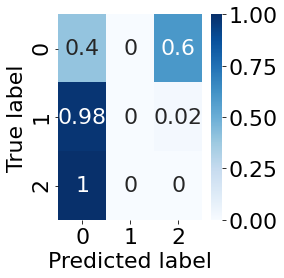

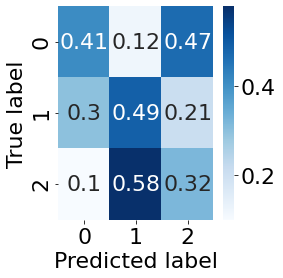

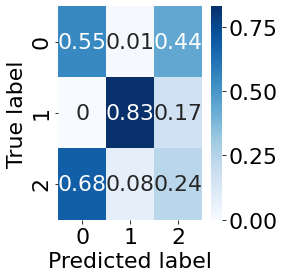

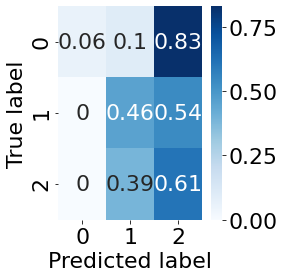

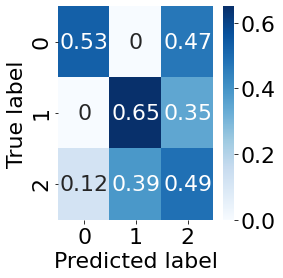

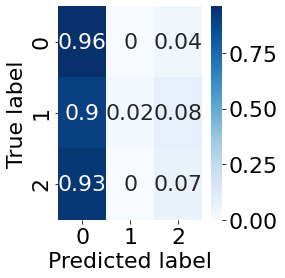

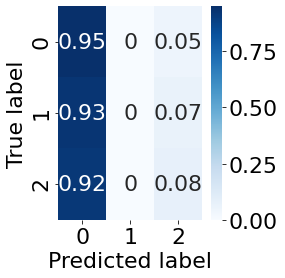

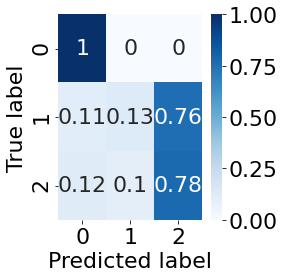

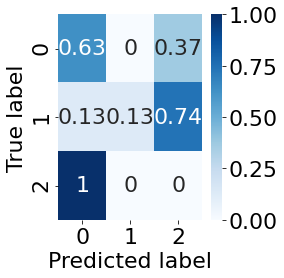

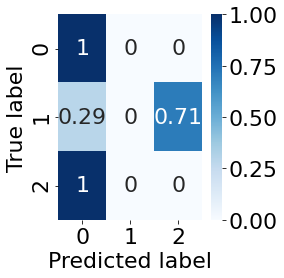

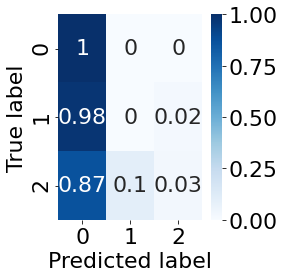

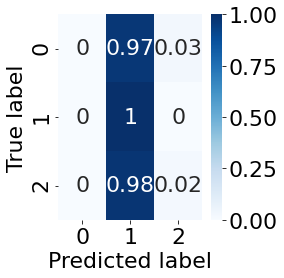

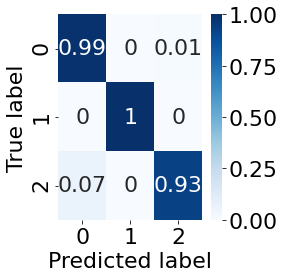

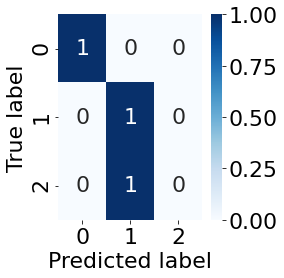

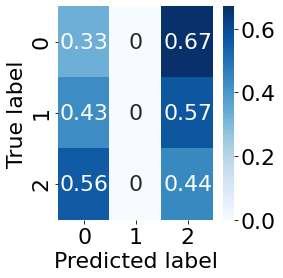

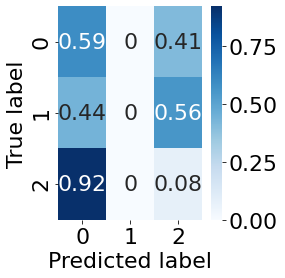

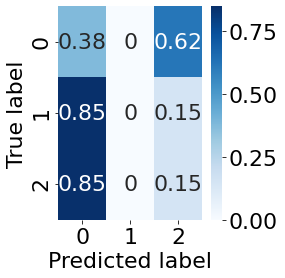

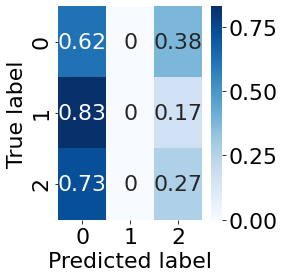

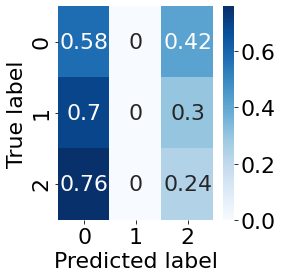

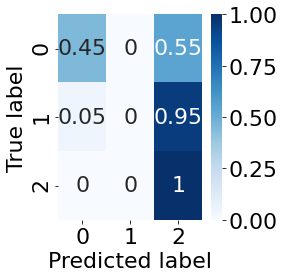

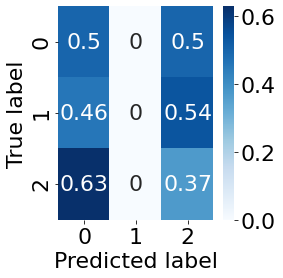

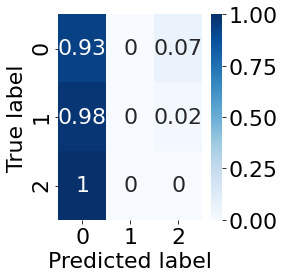

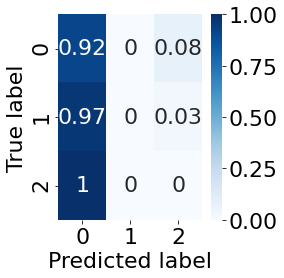

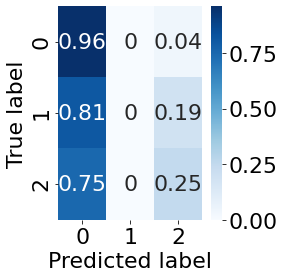

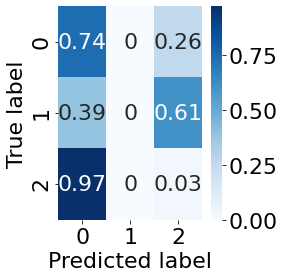

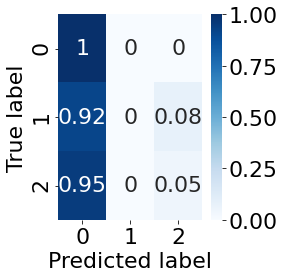

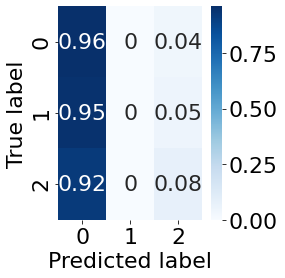

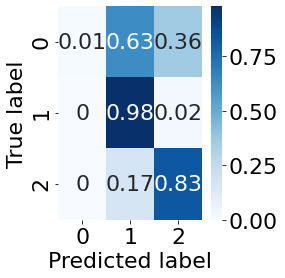

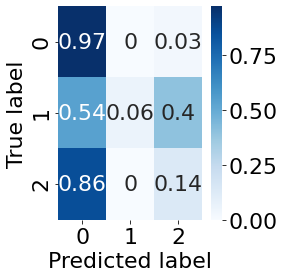

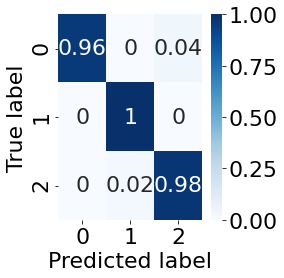

In [185]:
matr = [[0]*16 for _ in range(16)]
tr = 0
te = 0
subs = ['0002','0004','0005','0006','0007','0009','0013','0201',
    #    0      1      2      3      4      5      6      7
        '0401','0502','0601','0701','0801','0901','1101','1301']
    #    8      9      10     11     12     13     14     15


for train in subs:
    print("=================== Sub #", train, "==================")
    te = 0
    fname = "attention_"+train+"_low_fp1fp2_2s_resampled500Hz.pkl"
    df_X, df_y = data_prepare_tn(fname)
    
    Gbdt = GradientBoostingClassifier(random_state=1) #GBDT
    Gbdt.fit(df_X, df_y)
#     forest=RandomForestClassifier(n_estimators=16,random_state=1)
#     forest.fit(df_X, df_y)
    for test in subs:
        X_test, y_test = data_prepare_te("attention_"+test+"_low_fp1fp2_2s_resampled500Hz.pkl")
        y_pred = Gbdt.predict(X_test)
#         y_pred = forest.predict(X_test)
        accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
        pl(y_test, y_pred, accuracy, train, test)
        matr[tr][te] = accuracy
        print("Predicted: Sub #", test)
        te += 1
    tr += 1

Text(0.5, 68.0, 'Predict set')

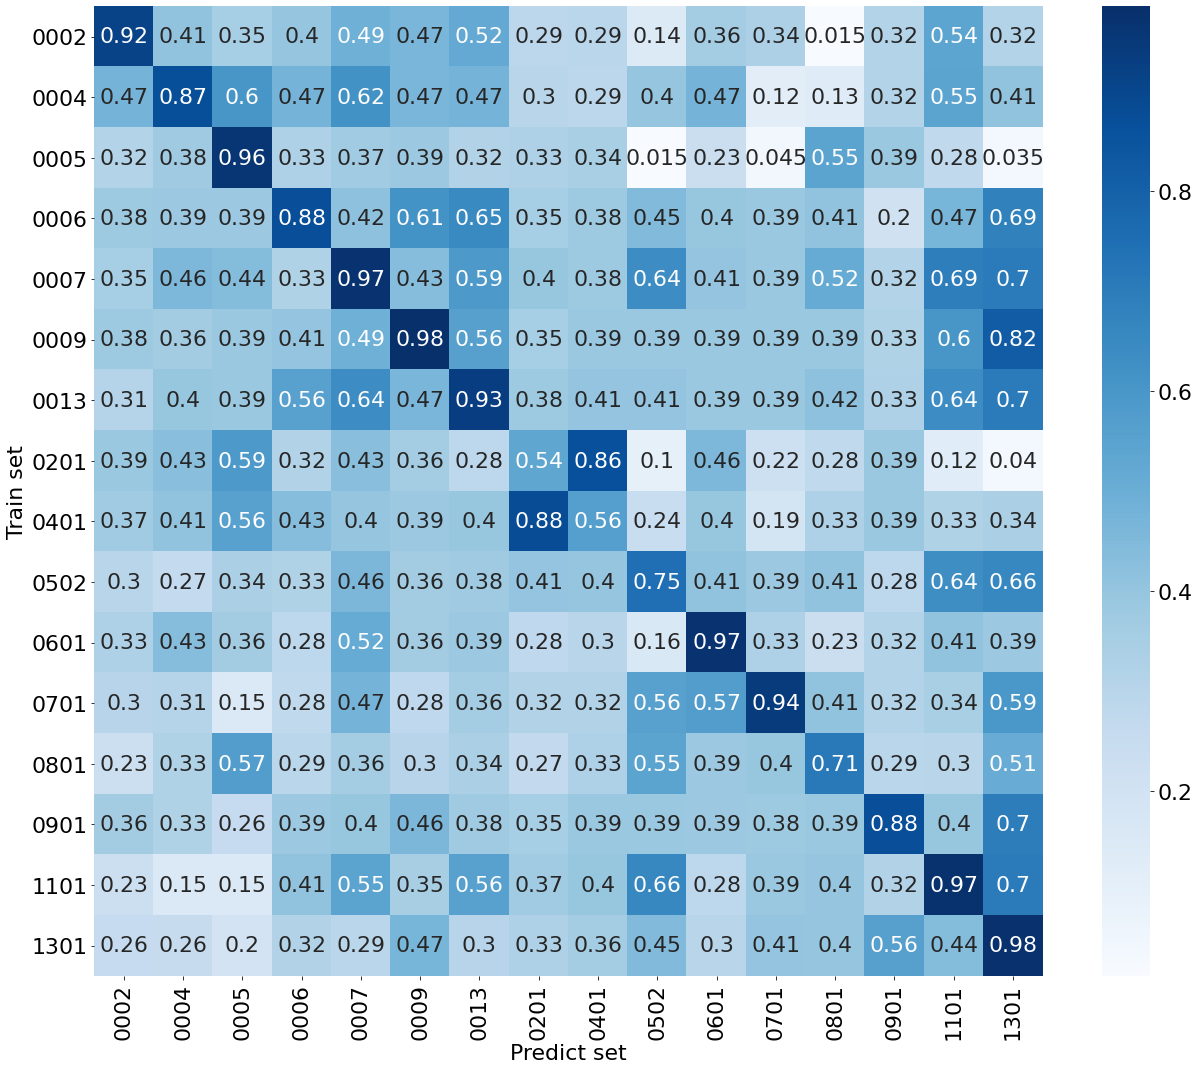

In [186]:
import pandas as pd
import seaborn as sns
plt.rcParams.update({'font.size': 22})

matr_df = pd.DataFrame(matr, index = subs, columns = subs)
figure = plt.figure(figsize=(18,15))
sns.heatmap(matr_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('Train set')
plt.xlabel('Predict set')
# plt.savefig(r"..\data\data3_attention\fig\CrossTest_FeatureModel.jpg")

In [184]:
matr = np.array(matr)
np.savetxt(r"D:\GitHub\EEG_fatigue\doc\gbdt_cross.csv",matr,delimiter=',')

# f16

In [62]:
import datetime

subs = ['0002','0004','0005','0006','0007','0009','0013','0201',
    #    0      1      2      3      4      5      6      7
        '0401','0502','0601','0701','0801','0901','1101','1301']
    #    8      9      10     11     12     13     14     15
matr = [[0]*len(subs) for i in range(5)]

tr = 0
for train in subs:
    print("================================= Sub #", train, "===================================")
    print("Load data...")
    fname = "attention_f16_"+train+".pkl"
    df_X, df_y = data_prepare(fname)    
    print(df_X.shape)
    print(df_y.shape)
    X_test, y_test = data_prepare("attention_"+train+"_low_fp1fp2_2s_resampled500Hz.pkl")   
    print(X_test.shape)
    print(y_test.shape)  
    
    print("====================== Model: LR =====================", datetime.datetime.now())
    lr = LogisticRegression(random_state = 1)
    lr.fit(df_X, df_y)
    print("Fitted all data except Sub #", train, "---------------", datetime.datetime.now())
    y_pred = lr.predict(X_test)
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    matr[0][tr] = accuracy
    print("Predicted on Sub #", train, "-------------------------", datetime.datetime.now())
    print("Accuracy:",  "----------------------------------------", accuracy)
    


    print("====================== Model: DECISION TREE ==========", datetime.datetime.now())
    tree = DecisionTreeClassifier(random_state=1) #决策树模型
    tree.fit(df_X, df_y)
    print("Fitted all data except Sub #", train, "---------------", datetime.datetime.now())
    y_pred = tree.predict(X_test)
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    matr[1][tr] = accuracy
    print("Predicted on Sub #", train, "-------------------------", datetime.datetime.now())
    print("Accuracy:",  "----------------------------------------", accuracy)

    
    print("====================== Model: SVM ====================", datetime.datetime.now())
    svm = SVC(probability=True,random_state=1,tol=1e-6)  # SVM模型
    svm.fit(df_X, df_y)
    print("Fitted all data except Sub #", train, "-----", datetime.datetime.now())
    y_pred = svm.predict(X_test)
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    matr[2][tr] = accuracy
    print("Predicted on Sub #", train, "-------------------------", datetime.datetime.now())
    print("Accuracy:",  "----------------------------------------", accuracy)
    

    print("====================== Model: RANDOM FOREST ==========", datetime.datetime.now())
    forest=RandomForestClassifier(n_estimators=100,random_state=1) #　随机森林
    forest.fit(df_X, df_y)
    print("Fitted all data except Sub #", train, "---------------", datetime.datetime.now())
    y_pred = forest.predict(X_test)
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    matr[3][tr] = accuracy
    print("Predicted on Sub #", train, "-------------------------", datetime.datetime.now())
    print("Accuracy:",  "----------------------------------------", accuracy)
    
    
    print("====================== Model: GBDT ===================", datetime.datetime.now())
    Gbdt=GradientBoostingClassifier(random_state=1) #GBDT
    Gbdt.fit(df_X, df_y)
    print("Fitted all data except Sub #", train, "---------------", datetime.datetime.now())
    y_pred = Gbdt.predict(X_test)
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    matr[4][tr] = accuracy
    print("Predicted on Sub #", train, "-------------------------", datetime.datetime.now())
    print("Accuracy:",  "----------------------------------------", accuracy)
    
    tr += 1

================================= Sub # 0002 ===================================
Load data...
(12521, 12)
(12521,)
(837, 12)
(837,)
====================== Model: LR ===================== 2021-01-06 17:21:43.195453
Fitted all data except Sub # 0002 --------------- 2021-01-06 17:21:43.523003
Predicted on Sub # 0002 ------------------------- 2021-01-06 17:21:43.524000
Accuracy: ---------------------------------------- 0.4121863799283154
====================== Model: DECISION TREE ========== 2021-01-06 17:21:43.524997
Fitted all data except Sub # 0002 --------------- 2021-01-06 17:21:43.691710
Predicted on Sub # 0002 ------------------------- 2021-01-06 17:21:43.691710
Accuracy: ---------------------------------------- 0.33572281959378736
====================== Model: SVM ==================== 2021-01-06 17:21:43.691710
Fitted all data except Sub # 0002 ----- 2021-01-06 17:22:18.122384
Predicted on Sub # 0002 ------------------------- 2021-01-06 17:22:18.322861
Accuracy: -------------------

(12521, 12)
(12521,)
(837, 12)
(837,)
====================== Model: LR ===================== 2021-01-06 17:26:24.828375
Fitted all data except Sub # 0009 --------------- 2021-01-06 17:26:25.120518
Predicted on Sub # 0009 ------------------------- 2021-01-06 17:26:25.122513
Accuracy: ---------------------------------------- 0.2891278375149343
====================== Model: DECISION TREE ========== 2021-01-06 17:26:25.122513
Fitted all data except Sub # 0009 --------------- 2021-01-06 17:26:25.282638
Predicted on Sub # 0009 ------------------------- 2021-01-06 17:26:25.282638
Accuracy: ---------------------------------------- 0.33572281959378736
====================== Model: SVM ==================== 2021-01-06 17:26:25.282638
Fitted all data except Sub # 0009 ----- 2021-01-06 17:26:59.984750
Predicted on Sub # 0009 ------------------------- 2021-01-06 17:27:00.200210
Accuracy: ---------------------------------------- 0.4838709677419355
====================== Model: RANDOM FOREST =========

(12523, 12)
(12523,)
(835, 12)
(835,)
====================== Model: LR ===================== 2021-01-06 17:31:08.372231
Fitted all data except Sub # 0601 --------------- 2021-01-06 17:31:08.674422
Predicted on Sub # 0601 ------------------------- 2021-01-06 17:31:08.676417
Accuracy: ---------------------------------------- 0.5197604790419161
====================== Model: DECISION TREE ========== 2021-01-06 17:31:08.676417
Fitted all data except Sub # 0601 --------------- 2021-01-06 17:31:08.858531
Predicted on Sub # 0601 ------------------------- 2021-01-06 17:31:08.860526
Accuracy: ---------------------------------------- 0.5125748502994012
====================== Model: SVM ==================== 2021-01-06 17:31:08.860526
Fitted all data except Sub # 0601 ----- 2021-01-06 17:31:43.005390
Predicted on Sub # 0601 ------------------------- 2021-01-06 17:31:43.217856
Accuracy: ---------------------------------------- 0.33532934131736525
====================== Model: RANDOM FOREST =========

(12521, 12)
(12521,)
(837, 12)
(837,)
====================== Model: LR ===================== 2021-01-06 17:35:49.079720
Fitted all data except Sub # 1301 --------------- 2021-01-06 17:35:49.400233
Predicted on Sub # 1301 ------------------------- 2021-01-06 17:35:49.402229
Accuracy: ---------------------------------------- 0.4014336917562724
====================== Model: DECISION TREE ========== 2021-01-06 17:35:49.402229
Fitted all data except Sub # 1301 --------------- 2021-01-06 17:35:49.576123
Predicted on Sub # 1301 ------------------------- 2021-01-06 17:35:49.576123
Accuracy: ---------------------------------------- 0.46714456391875747
====================== Model: SVM ==================== 2021-01-06 17:35:49.576123
Fitted all data except Sub # 1301 ----- 2021-01-06 17:36:24.358297
Predicted on Sub # 1301 ------------------------- 2021-01-06 17:36:24.559310
Accuracy: ---------------------------------------- 0.4731182795698925
====================== Model: RANDOM FOREST =========

In [63]:
# import pandas as pd
# import seaborn as sns
# plt.rcParams.update({'font.size': 22})

# matr_df = pd.DataFrame(matr, index = subs, columns = subs)
# figure = plt.figure(figsize=(18,15))
# sns.heatmap(matr_df, annot=True,cmap=plt.cm.Blues)
# plt.tight_layout()
# plt.ylabel('Train set')
# plt.xlabel('Predict set')
# plt.savefig(r"..\data\data3_attention\fig\CrossTest_FeatureModel.jpg")
matr

[[0.4121863799283154,
  0.30741626794258375,
  0.2511961722488038,
  0.3632019115890084,
  0.4217443249701314,
  0.2891278375149343,
  0.4145758661887694,
  0.3871359223300971,
  0.3871359223300971,
  0.43966547192353644,
  0.5197604790419161,
  0.3724550898203593,
  0.41077844311377243,
  0.34528076463560337,
  0.5173237753882916,
  0.4014336917562724],
 [0.33572281959378736,
  0.24641148325358853,
  0.3588516746411483,
  0.4109916367980884,
  0.44802867383512546,
  0.33572281959378736,
  0.6200716845878136,
  1.0,
  1.0,
  0.12664277180406214,
  0.5125748502994012,
  0.26706586826347306,
  0.34850299401197604,
  0.4265232974910394,
  0.38829151732377537,
  0.46714456391875747],
 [0.37992831541218636,
  0.3492822966507177,
  0.3480861244019139,
  0.4002389486260454,
  0.4432497013142174,
  0.4838709677419355,
  0.46236559139784944,
  0.4854368932038835,
  0.4854368932038835,
  0.3966547192353644,
  0.33532934131736525,
  0.3532934131736527,
  0.4491017964071856,
  0.34767025089605735,

In [65]:
matr = {'LR':matr[0], 'Tree':matr[1], 'svm':matr[2], 'RF':matr[3], 'Gbdt':matr[4]}
pd.DataFrame(matr).to_csv("..\\data\\data3_attention\\FeatureModel_f16_results_1.csv")

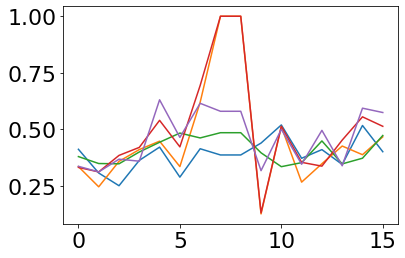

In [64]:
plt.figure()
plt.plot(np.transpose(np.array(matr)))

# Save feature for later visualisation

In [49]:
import datetime

subs = ['0002','0004','0005','0006','0007','0009','0013','0201',
        '0401','0502','0601','0701','0801','0901','1101','1301']
for train in subs:
    print("================================= Sub #", train, "===================================")
    print("Start:-------------------------------------------", datetime.datetime.now())
    
#     fname = "attention_f16_"+train+".pkl"
    fname = "attention_"+train+"_low_fp1fp2_2s_resampled500Hz.pkl"
    
    df_X, df_y = data_prepare(fname)
    print("Feature calculated:------------------------------", datetime.datetime.now())
    feat = [df_X, df_y]
    
#     save_file = "..\\data\\data3_attention\\feature_attention_f16_"+train+".pkl"
    save_file = "..\\data\\data3_attention\\feature_attention_"+train+"_low_fp1fp2_2s_resampled500Hz.pkl"
    
    with open(save_file, 'wb') as handle:
                # pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(feat, handle, protocol=2)
    print("Feature saved:", save_file, datetime.datetime.now())

================================= Sub # 0002 ===================================
Start:------------------------------------------- 2021-01-07 20:15:31.226609
(837, 2, 1000)
Feature calculated:------------------------------ 2021-01-07 20:15:31.497054
Feature saved: ..\data\data3_attention\feature_attention_0002_low_fp1fp2_2s_resampled500Hz.pkl 2021-01-07 20:15:31.505884
================================= Sub # 0004 ===================================
Start:------------------------------------------- 2021-01-07 20:15:31.505884
(836, 2, 1000)
Feature calculated:------------------------------ 2021-01-07 20:15:31.776164
Feature saved: ..\data\data3_attention\feature_attention_0004_low_fp1fp2_2s_resampled500Hz.pkl 2021-01-07 20:15:31.780174
================================= Sub # 0005 ===================================
Start:------------------------------------------- 2021-01-07 20:15:31.780174
(836, 2, 1000)
Feature calculated:------------------------------ 2021-01-07 20:15:32.046780
Featur

In [65]:
fname = "feature_attention_1301_low_fp1fp2_2s_resampled500Hz.pkl"
f = open(os.path.join(r"..\data\data3_attention", fname), 'rb')
df_X, df_y = pickle.load(f)
f.close()

print(df_X.shape)
print(df_y.shape)

(837, 12)
(837,)


========= Feature visualisation for Subject # 0002
(837, 12)
========= Feature visualisation for Subject # 0004
(836, 12)
========= Feature visualisation for Subject # 0005
(836, 12)
========= Feature visualisation for Subject # 0006
(837, 12)
========= Feature visualisation for Subject # 0007
(837, 12)
========= Feature visualisation for Subject # 0009
(837, 12)
========= Feature visualisation for Subject # 0013
(837, 12)
========= Feature visualisation for Subject # 0201
(824, 12)
========= Feature visualisation for Subject # 0401
(824, 12)
========= Feature visualisation for Subject # 0502
(837, 12)
========= Feature visualisation for Subject # 0601
(835, 12)
========= Feature visualisation for Subject # 0701
(835, 12)
========= Feature visualisation for Subject # 0801
(835, 12)
========= Feature visualisation for Subject # 0901
(837, 12)
========= Feature visualisation for Subject # 1101
(837, 12)
========= Feature visualisation for Subject # 1301
(837, 12)


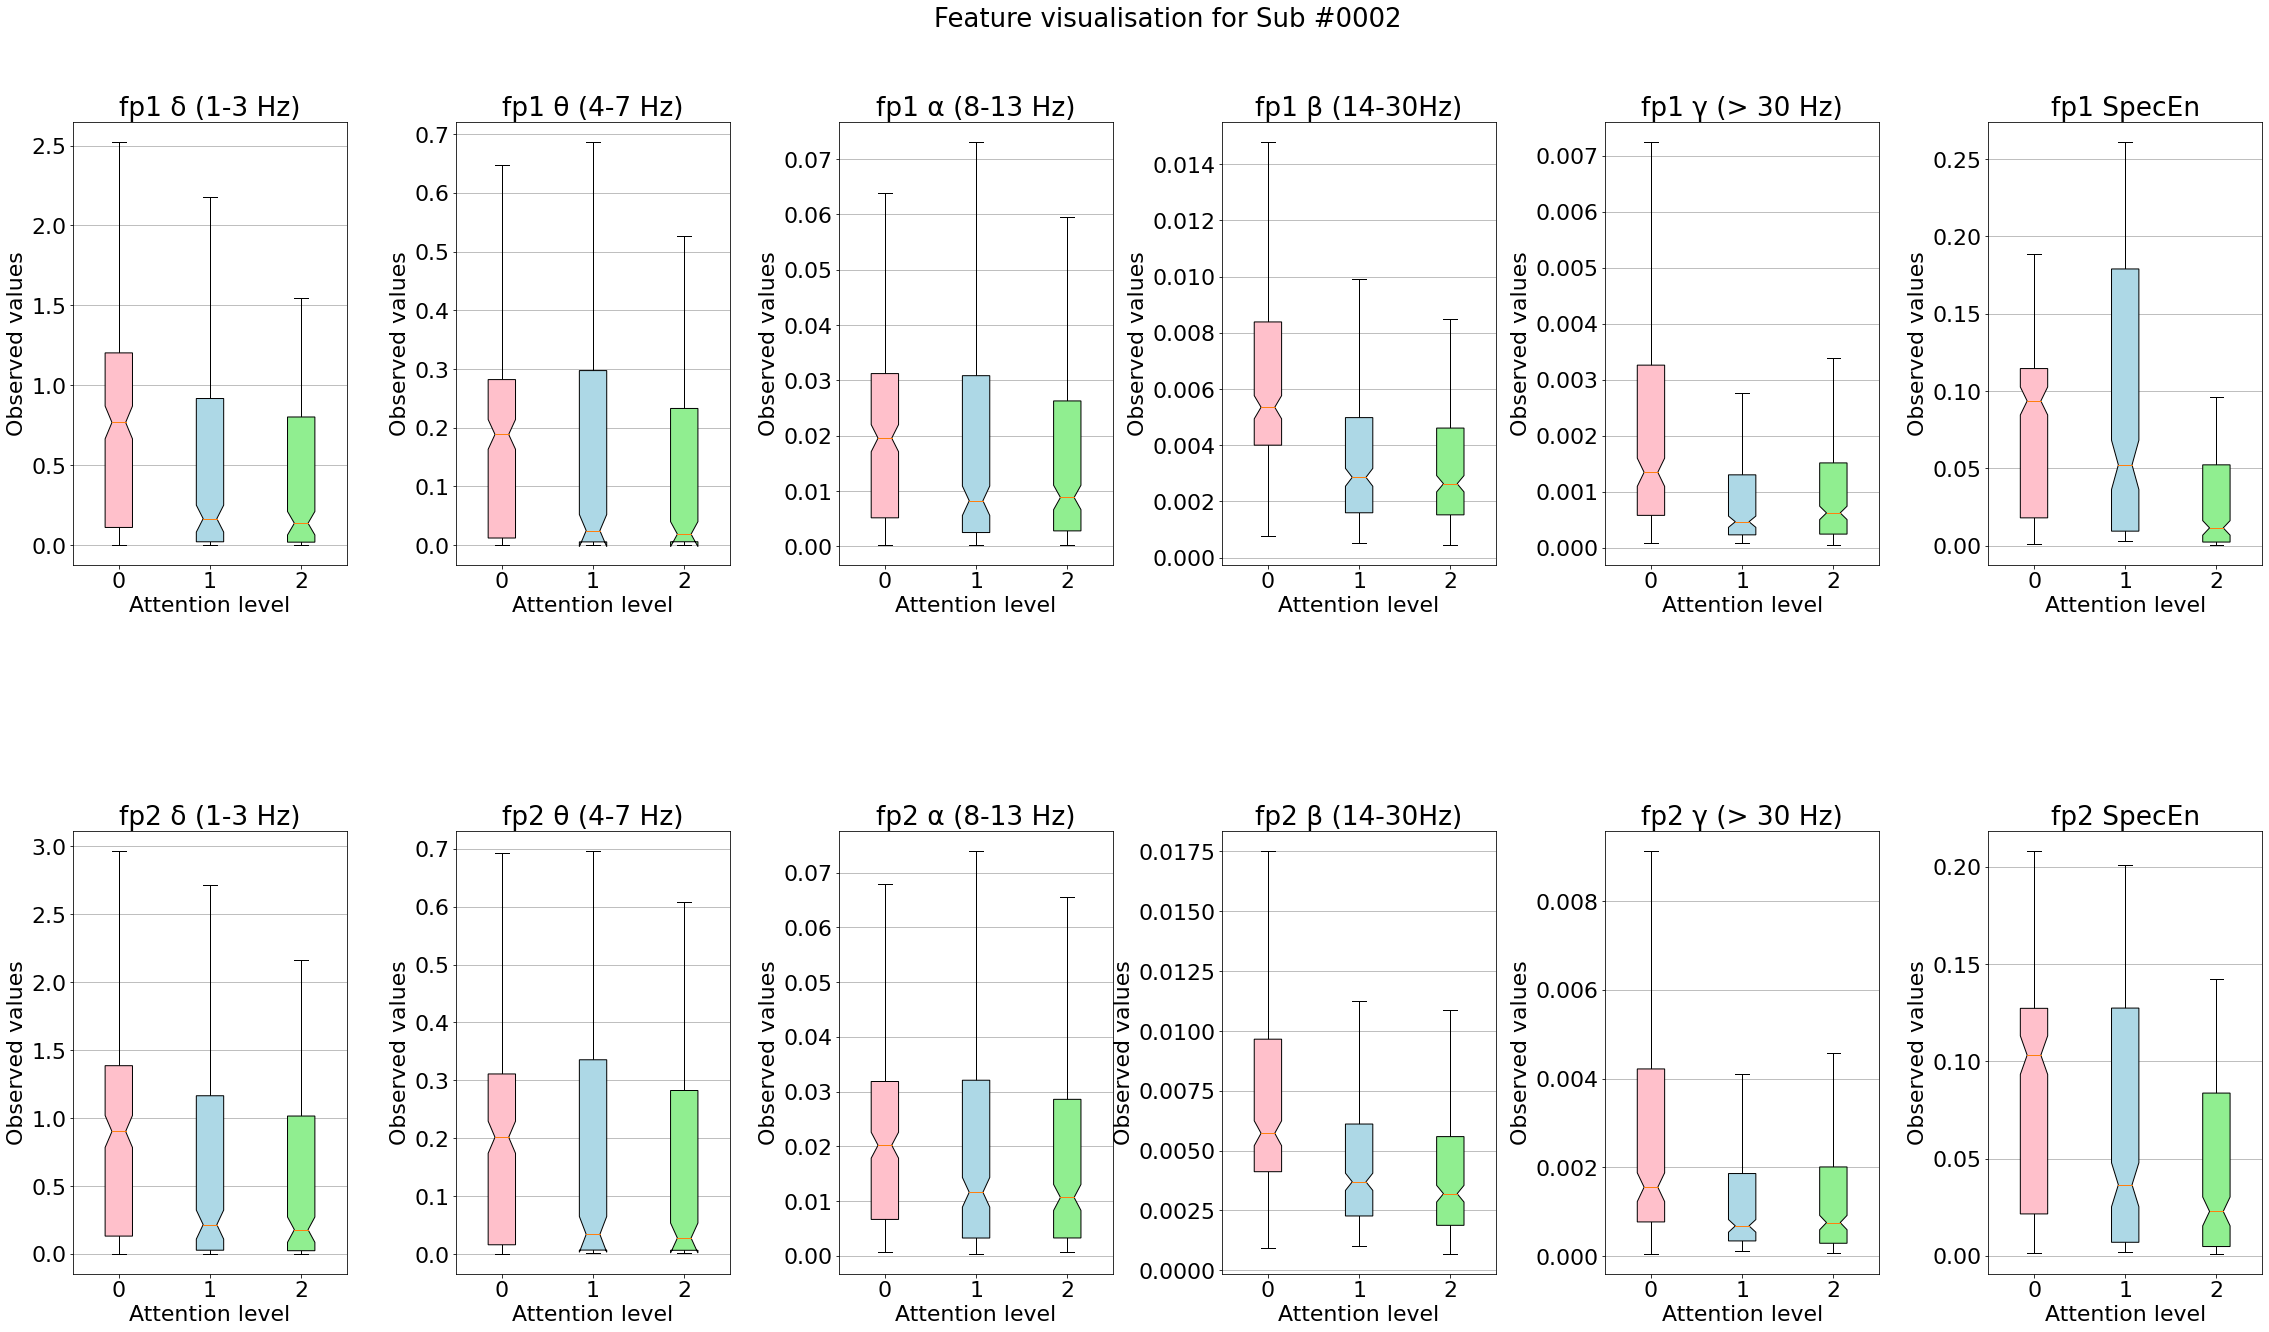

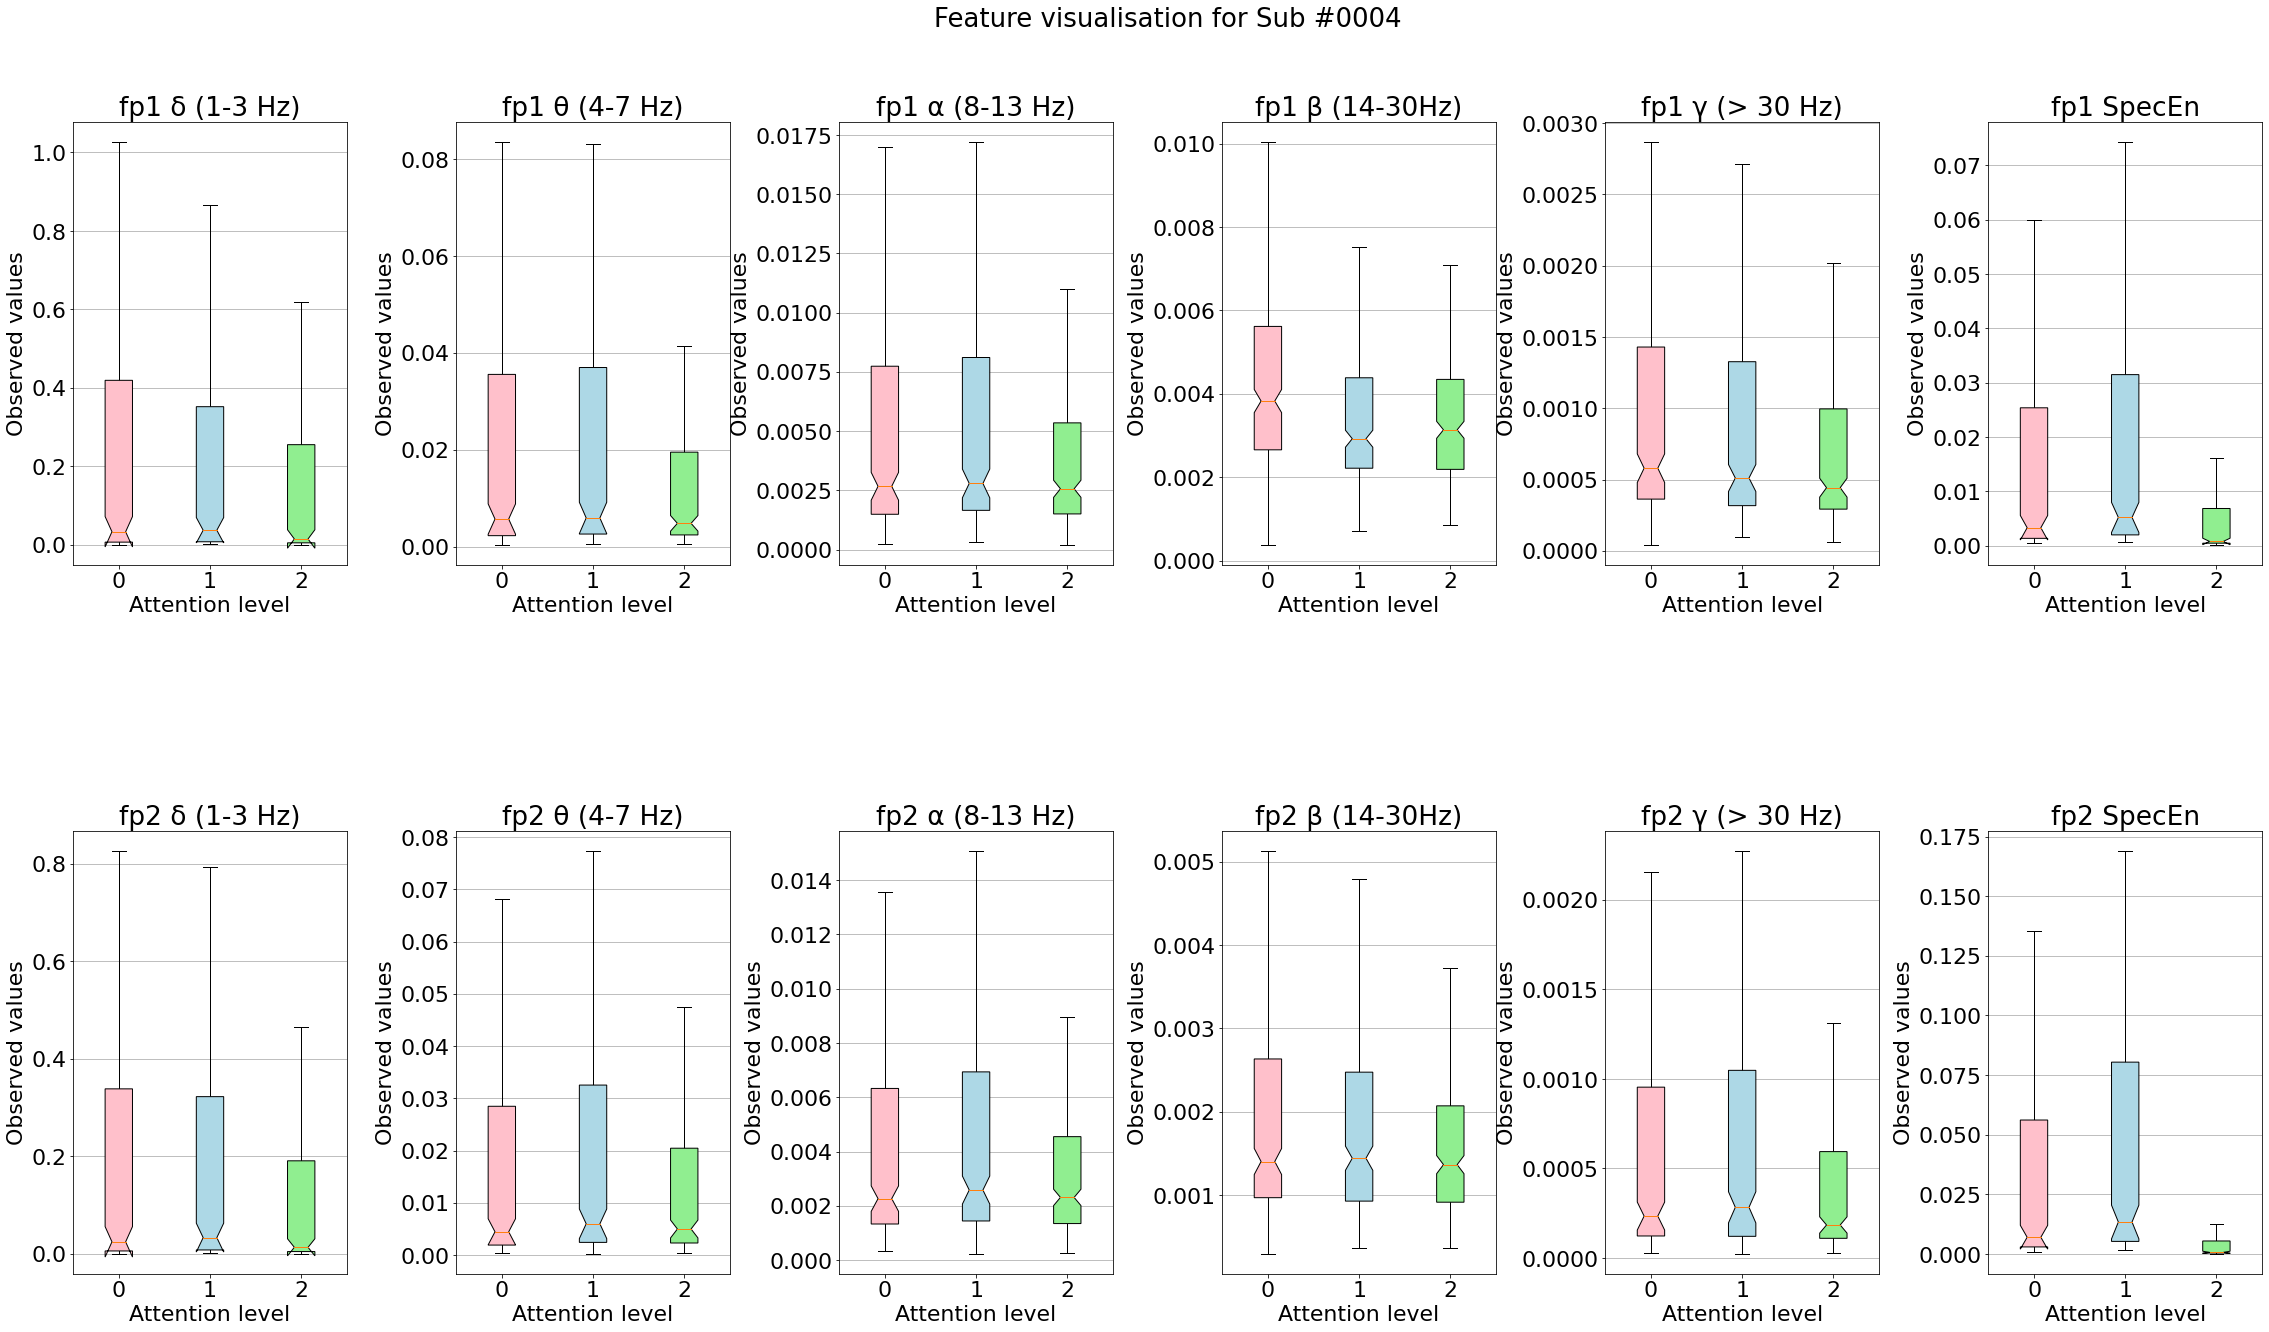

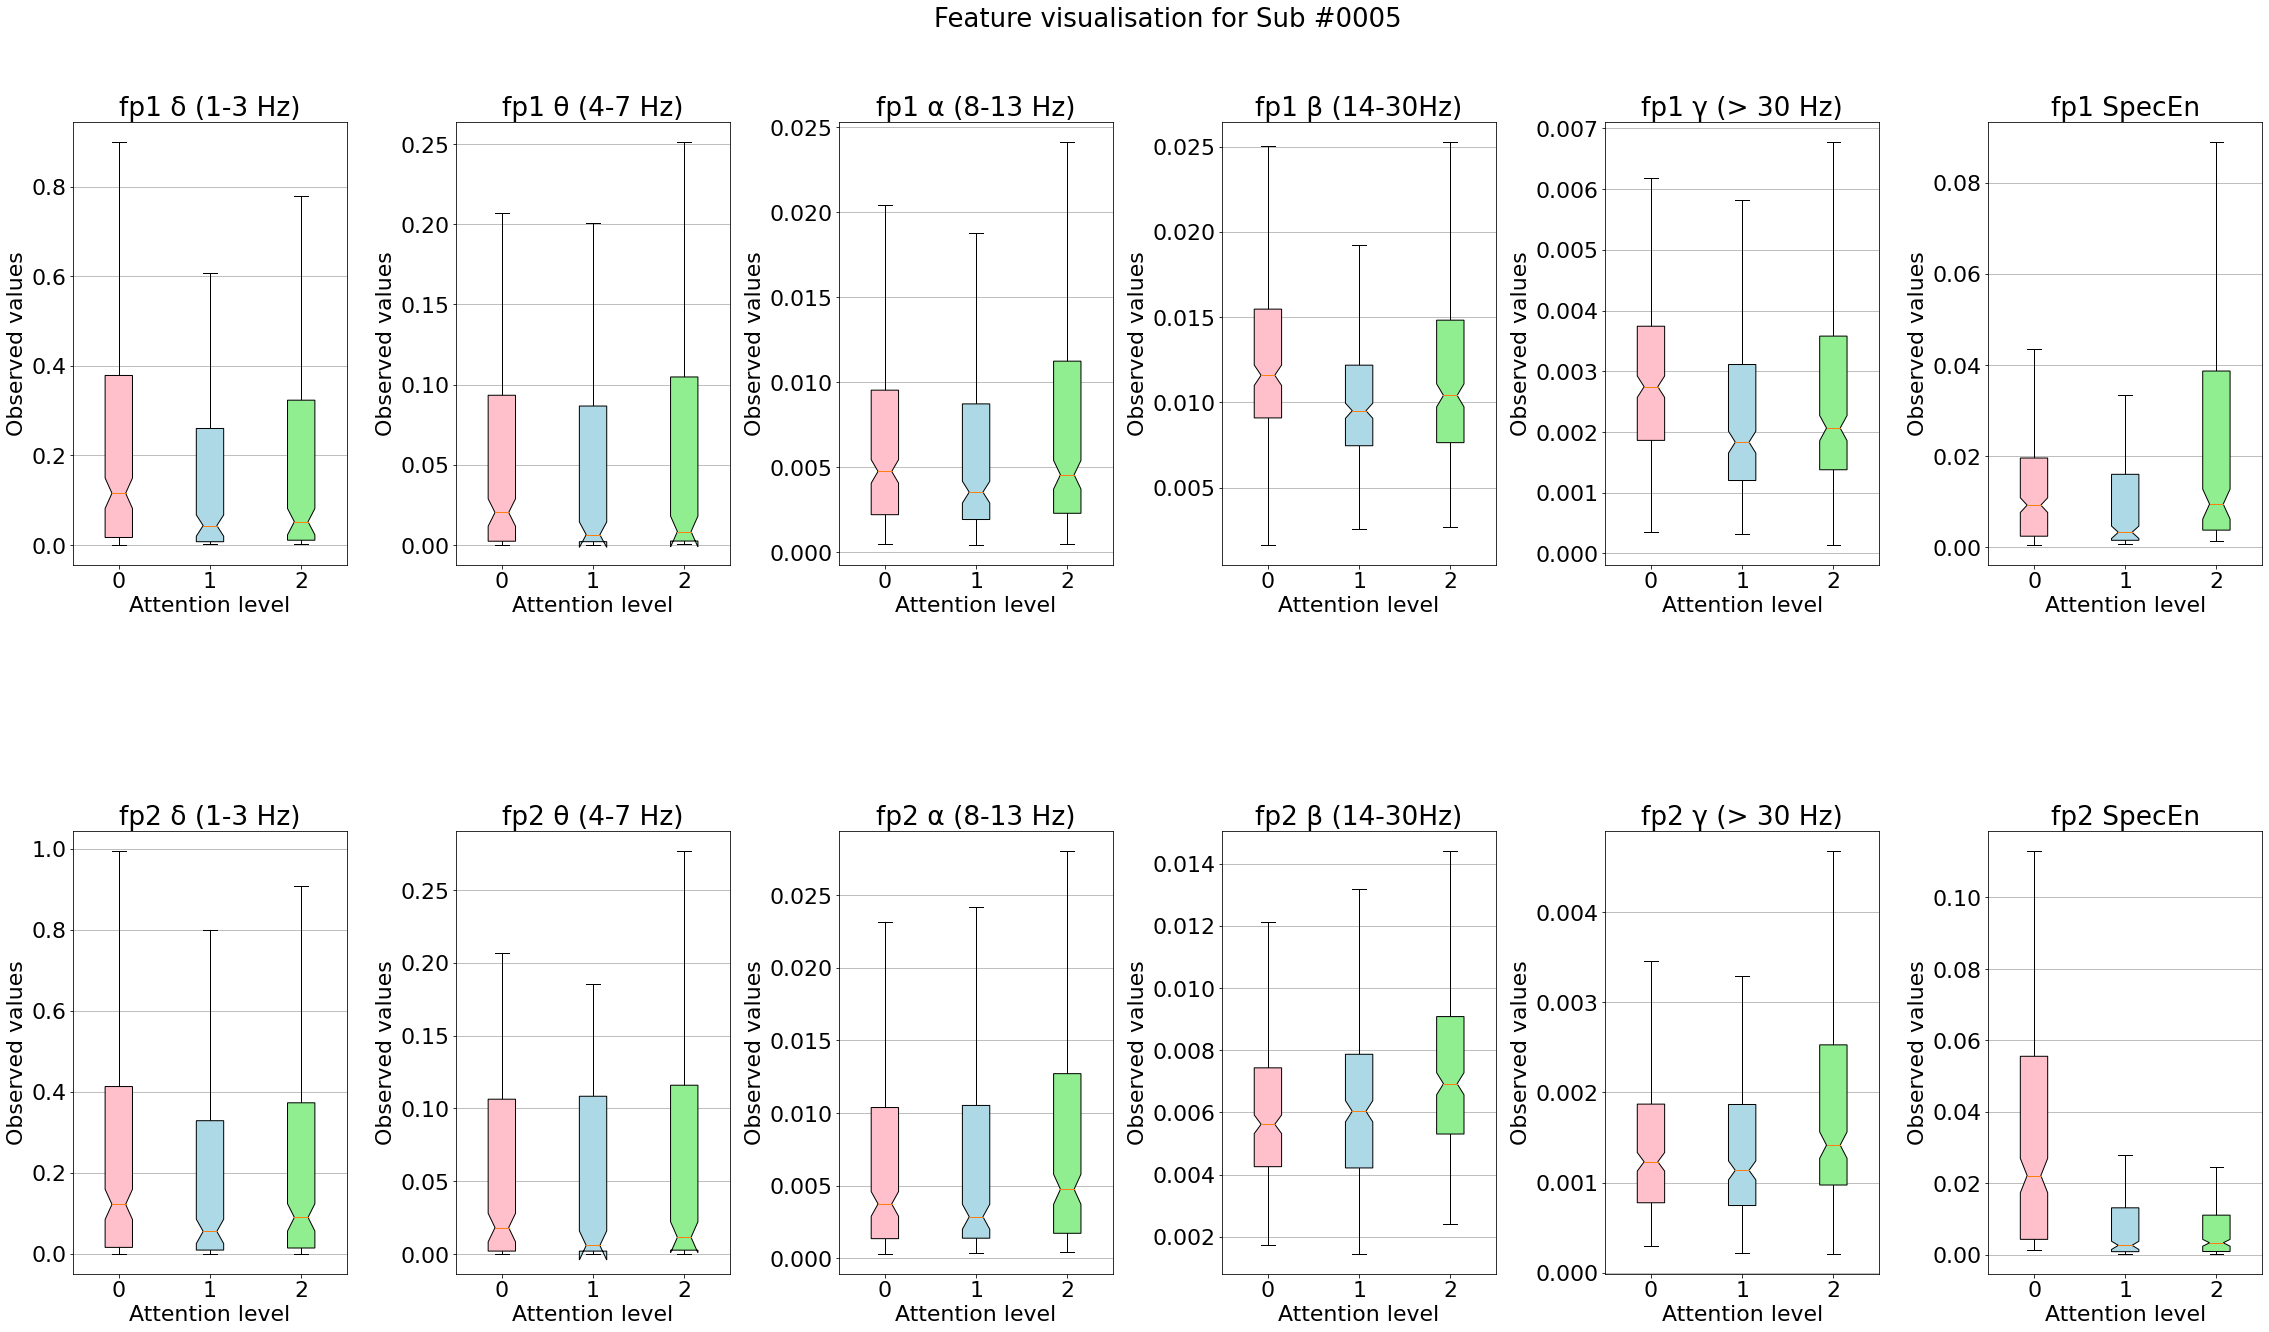

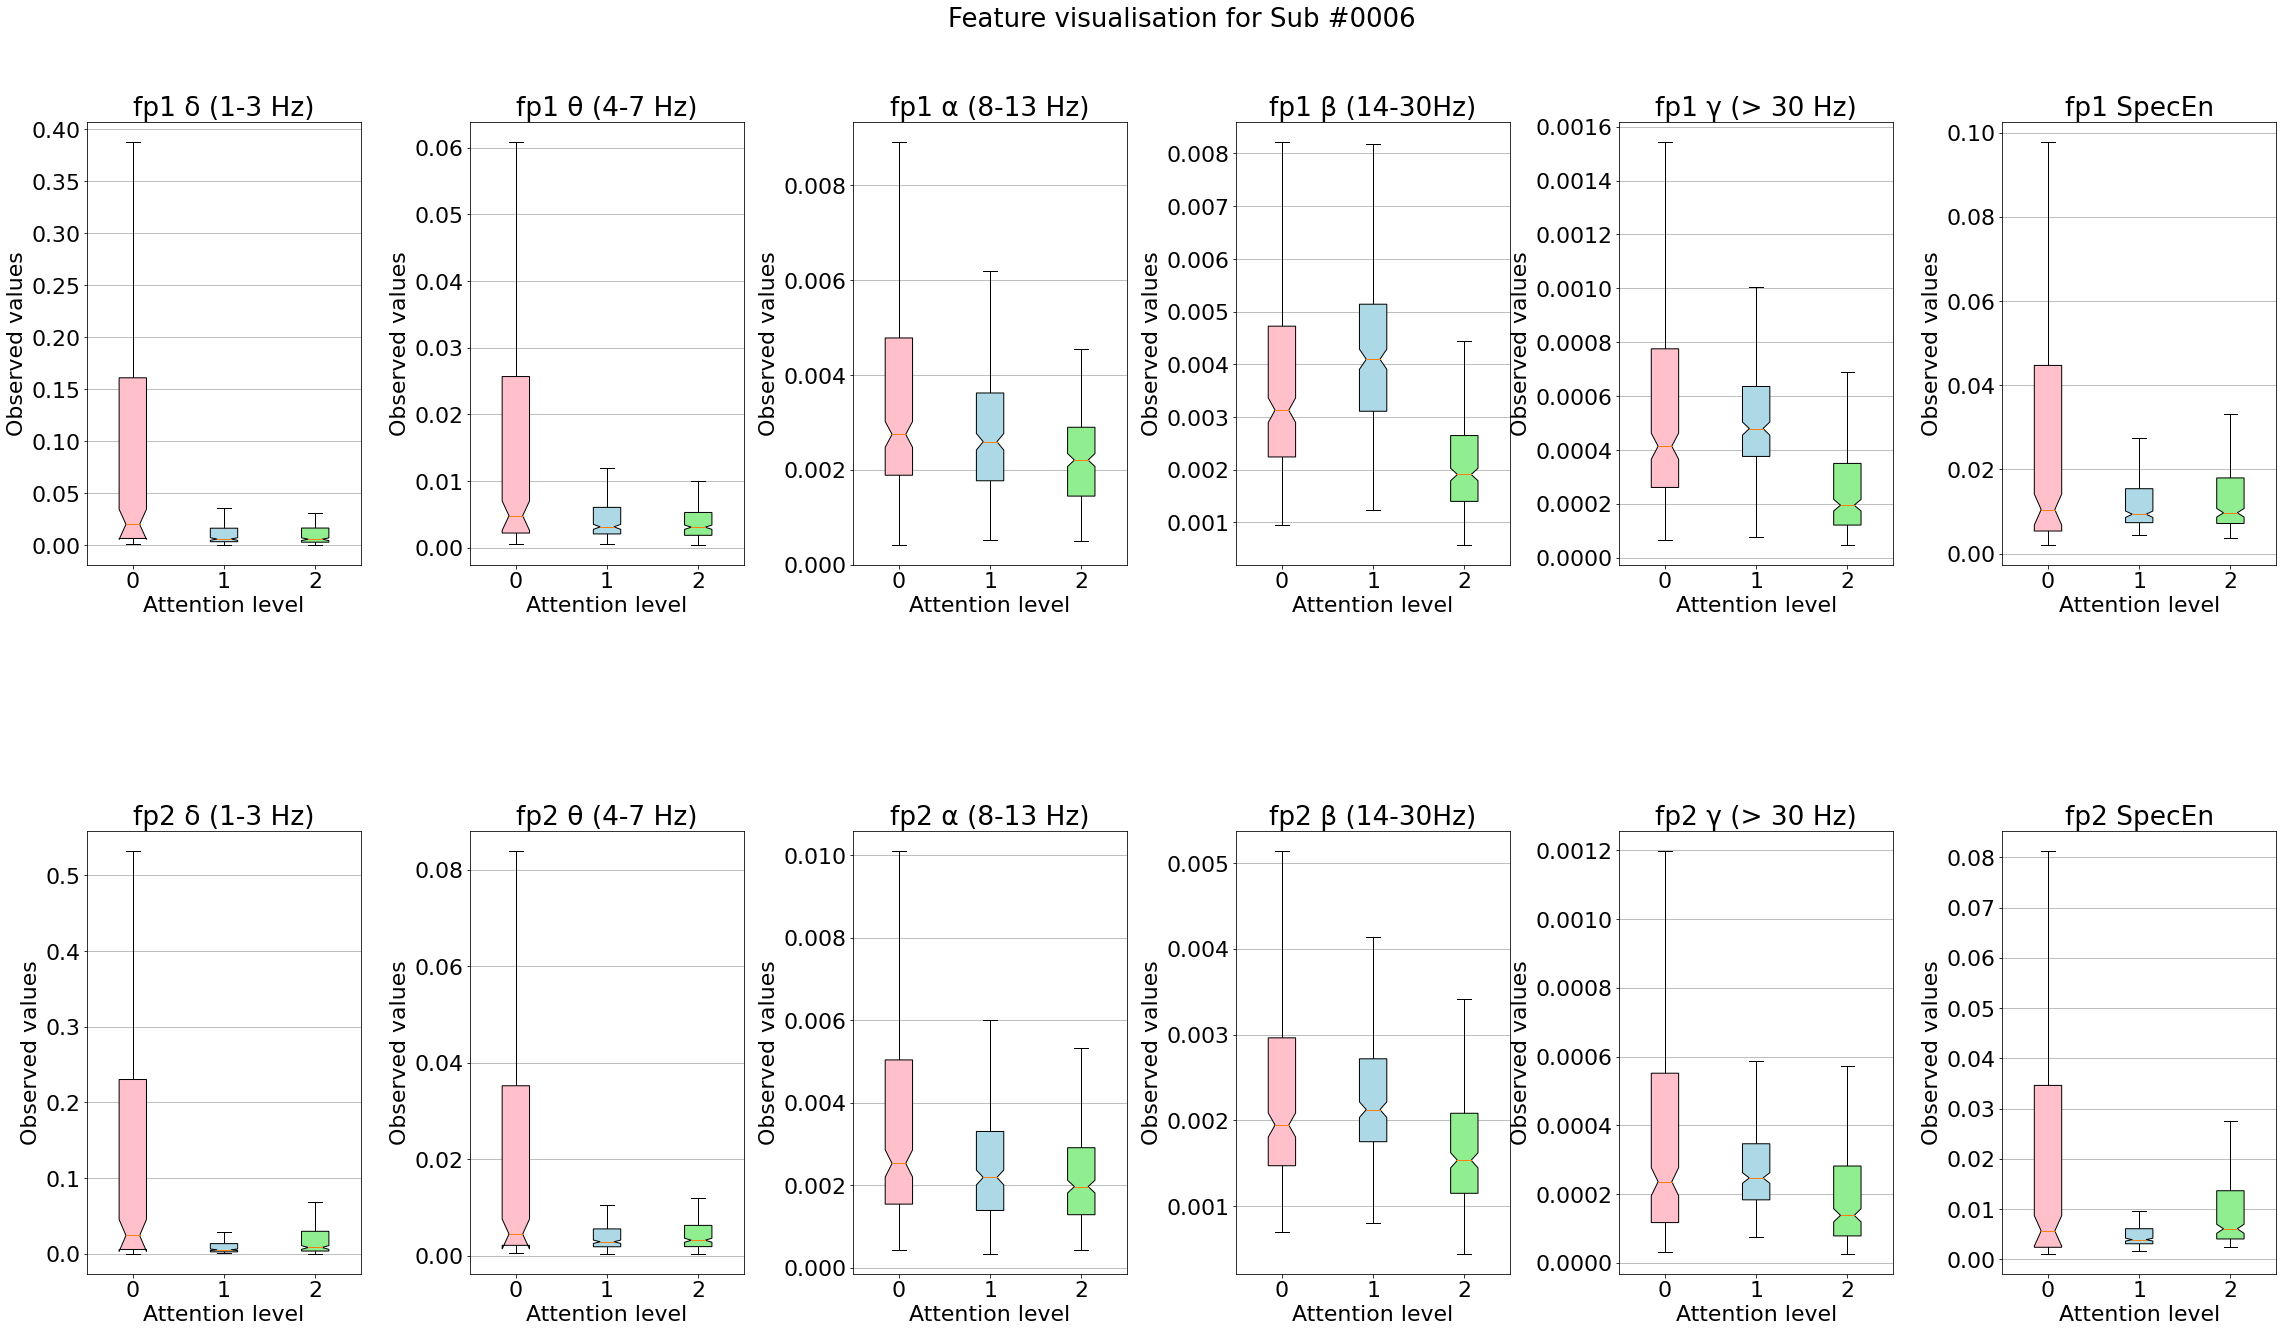

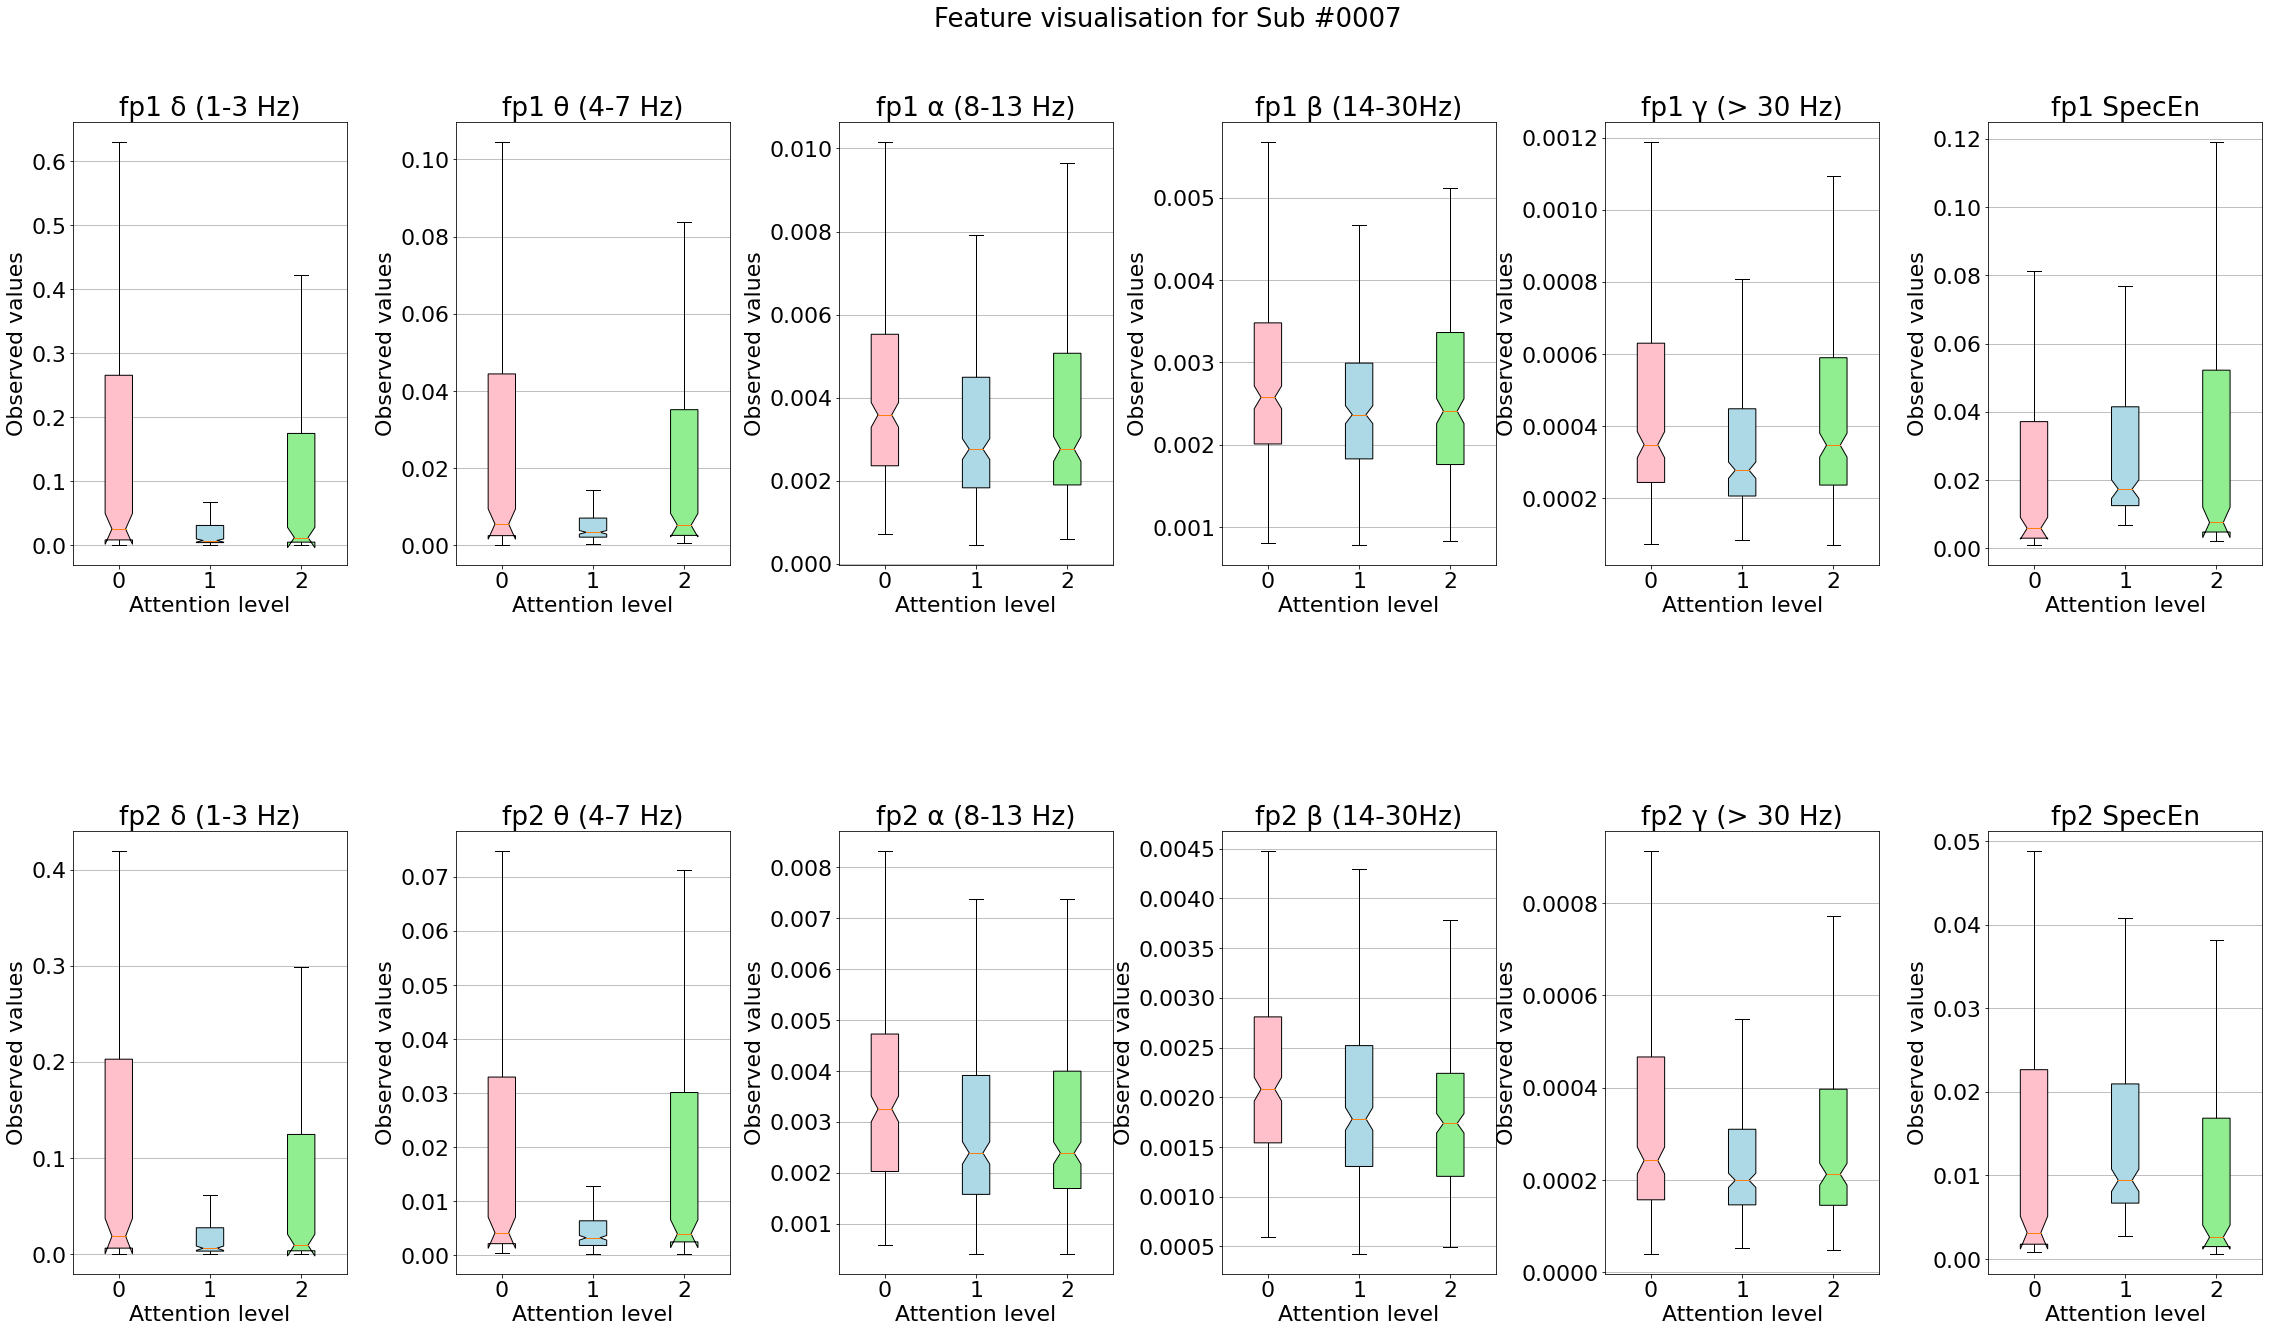

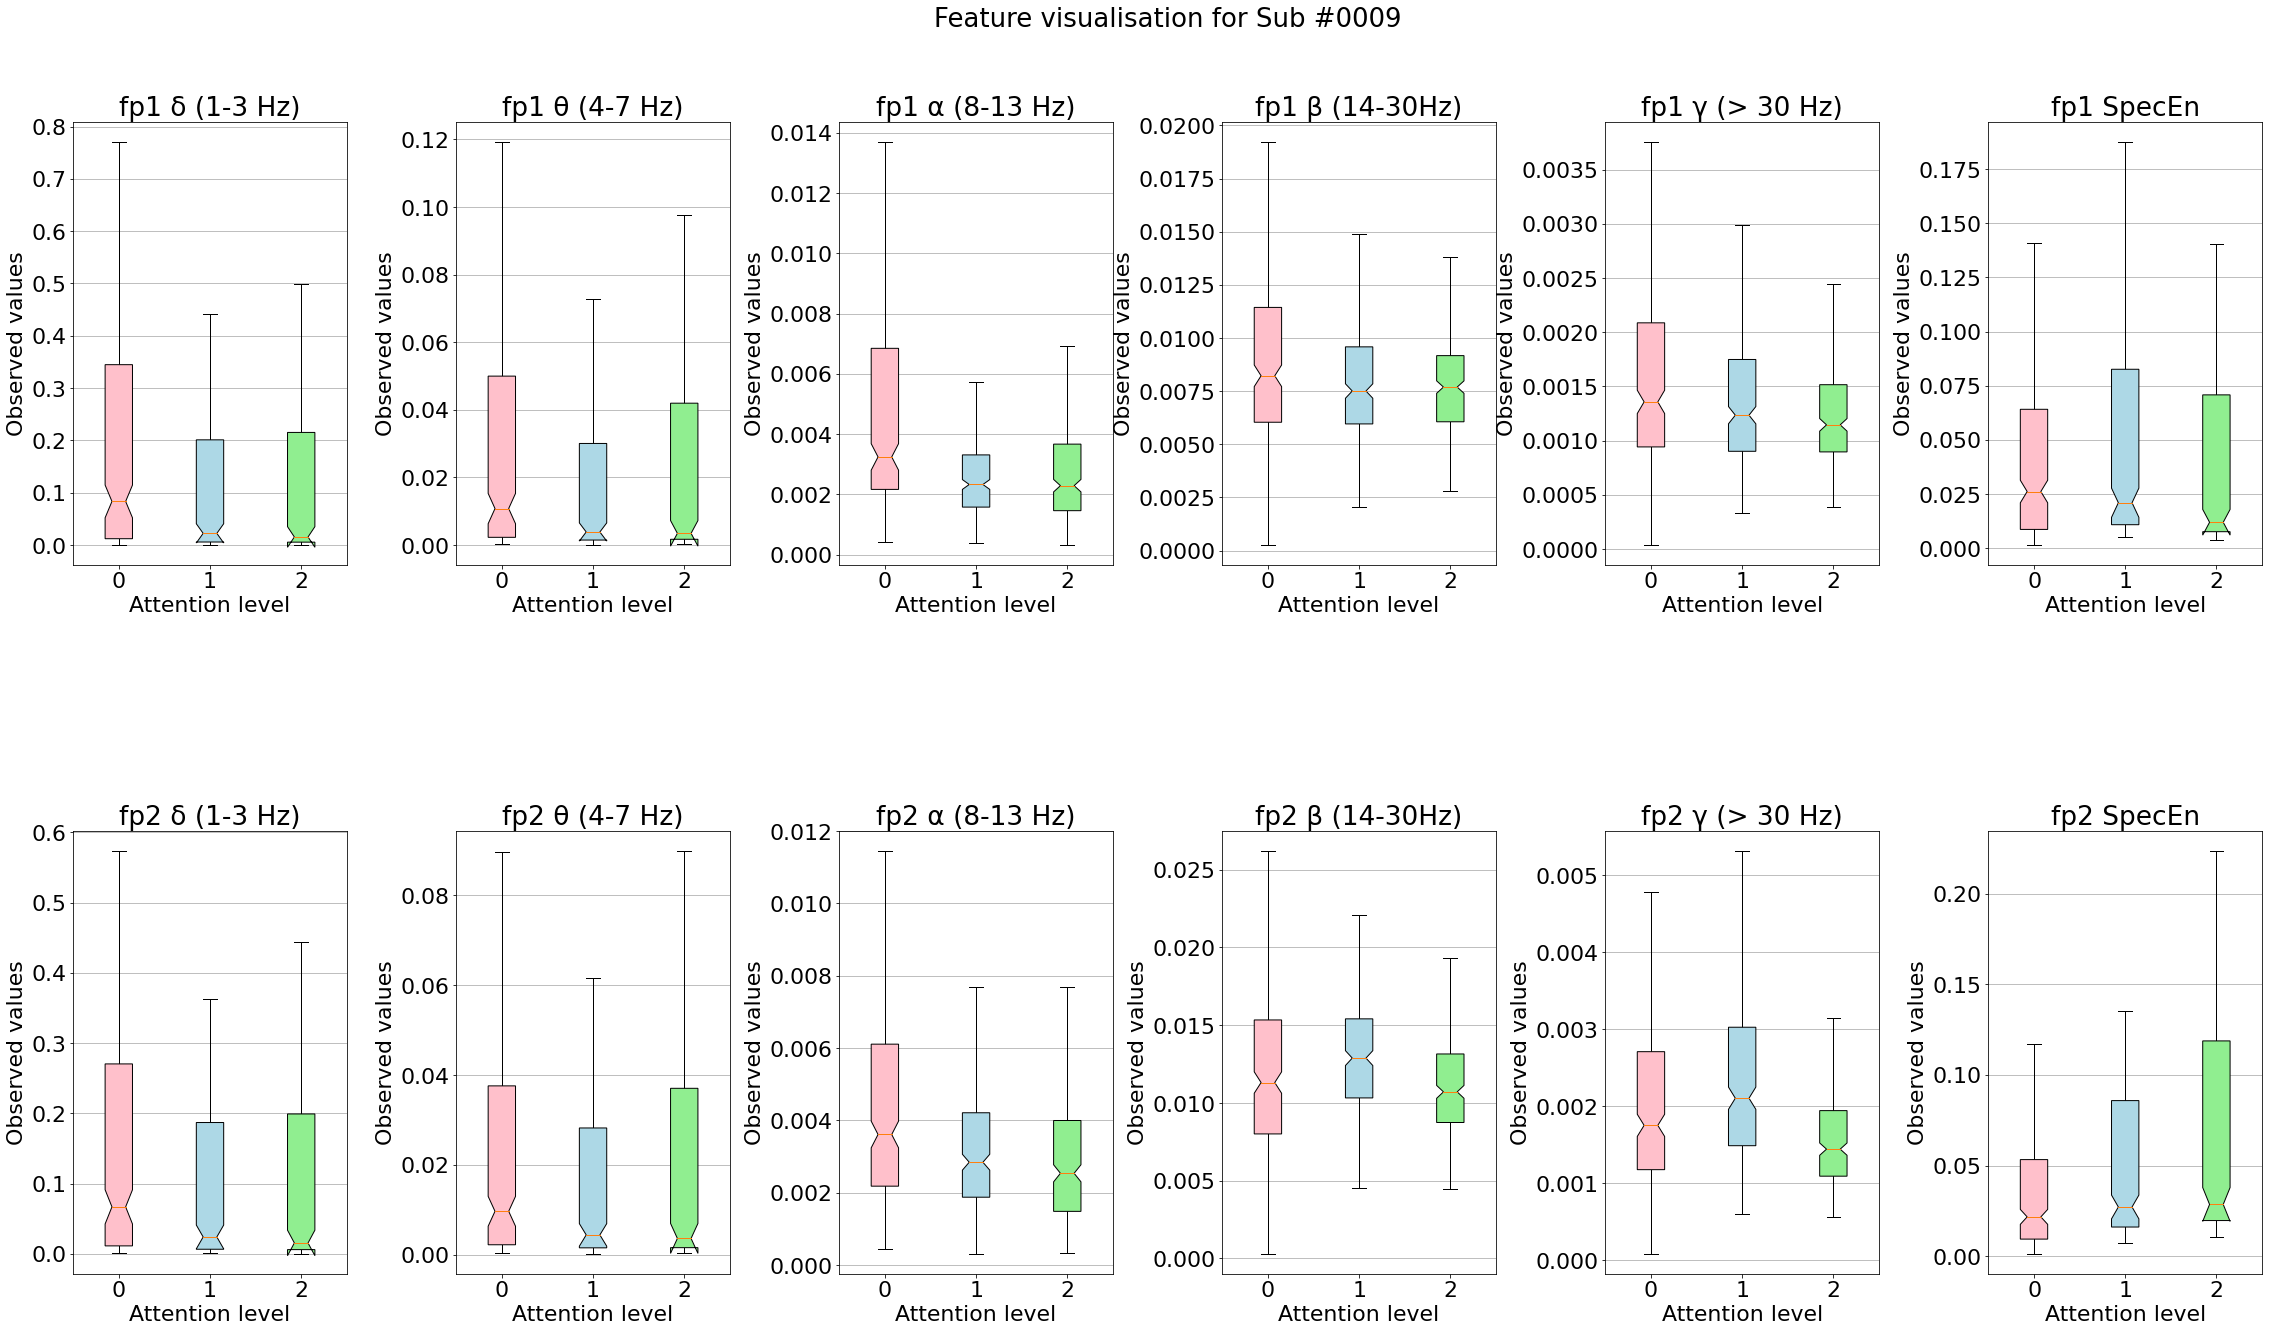

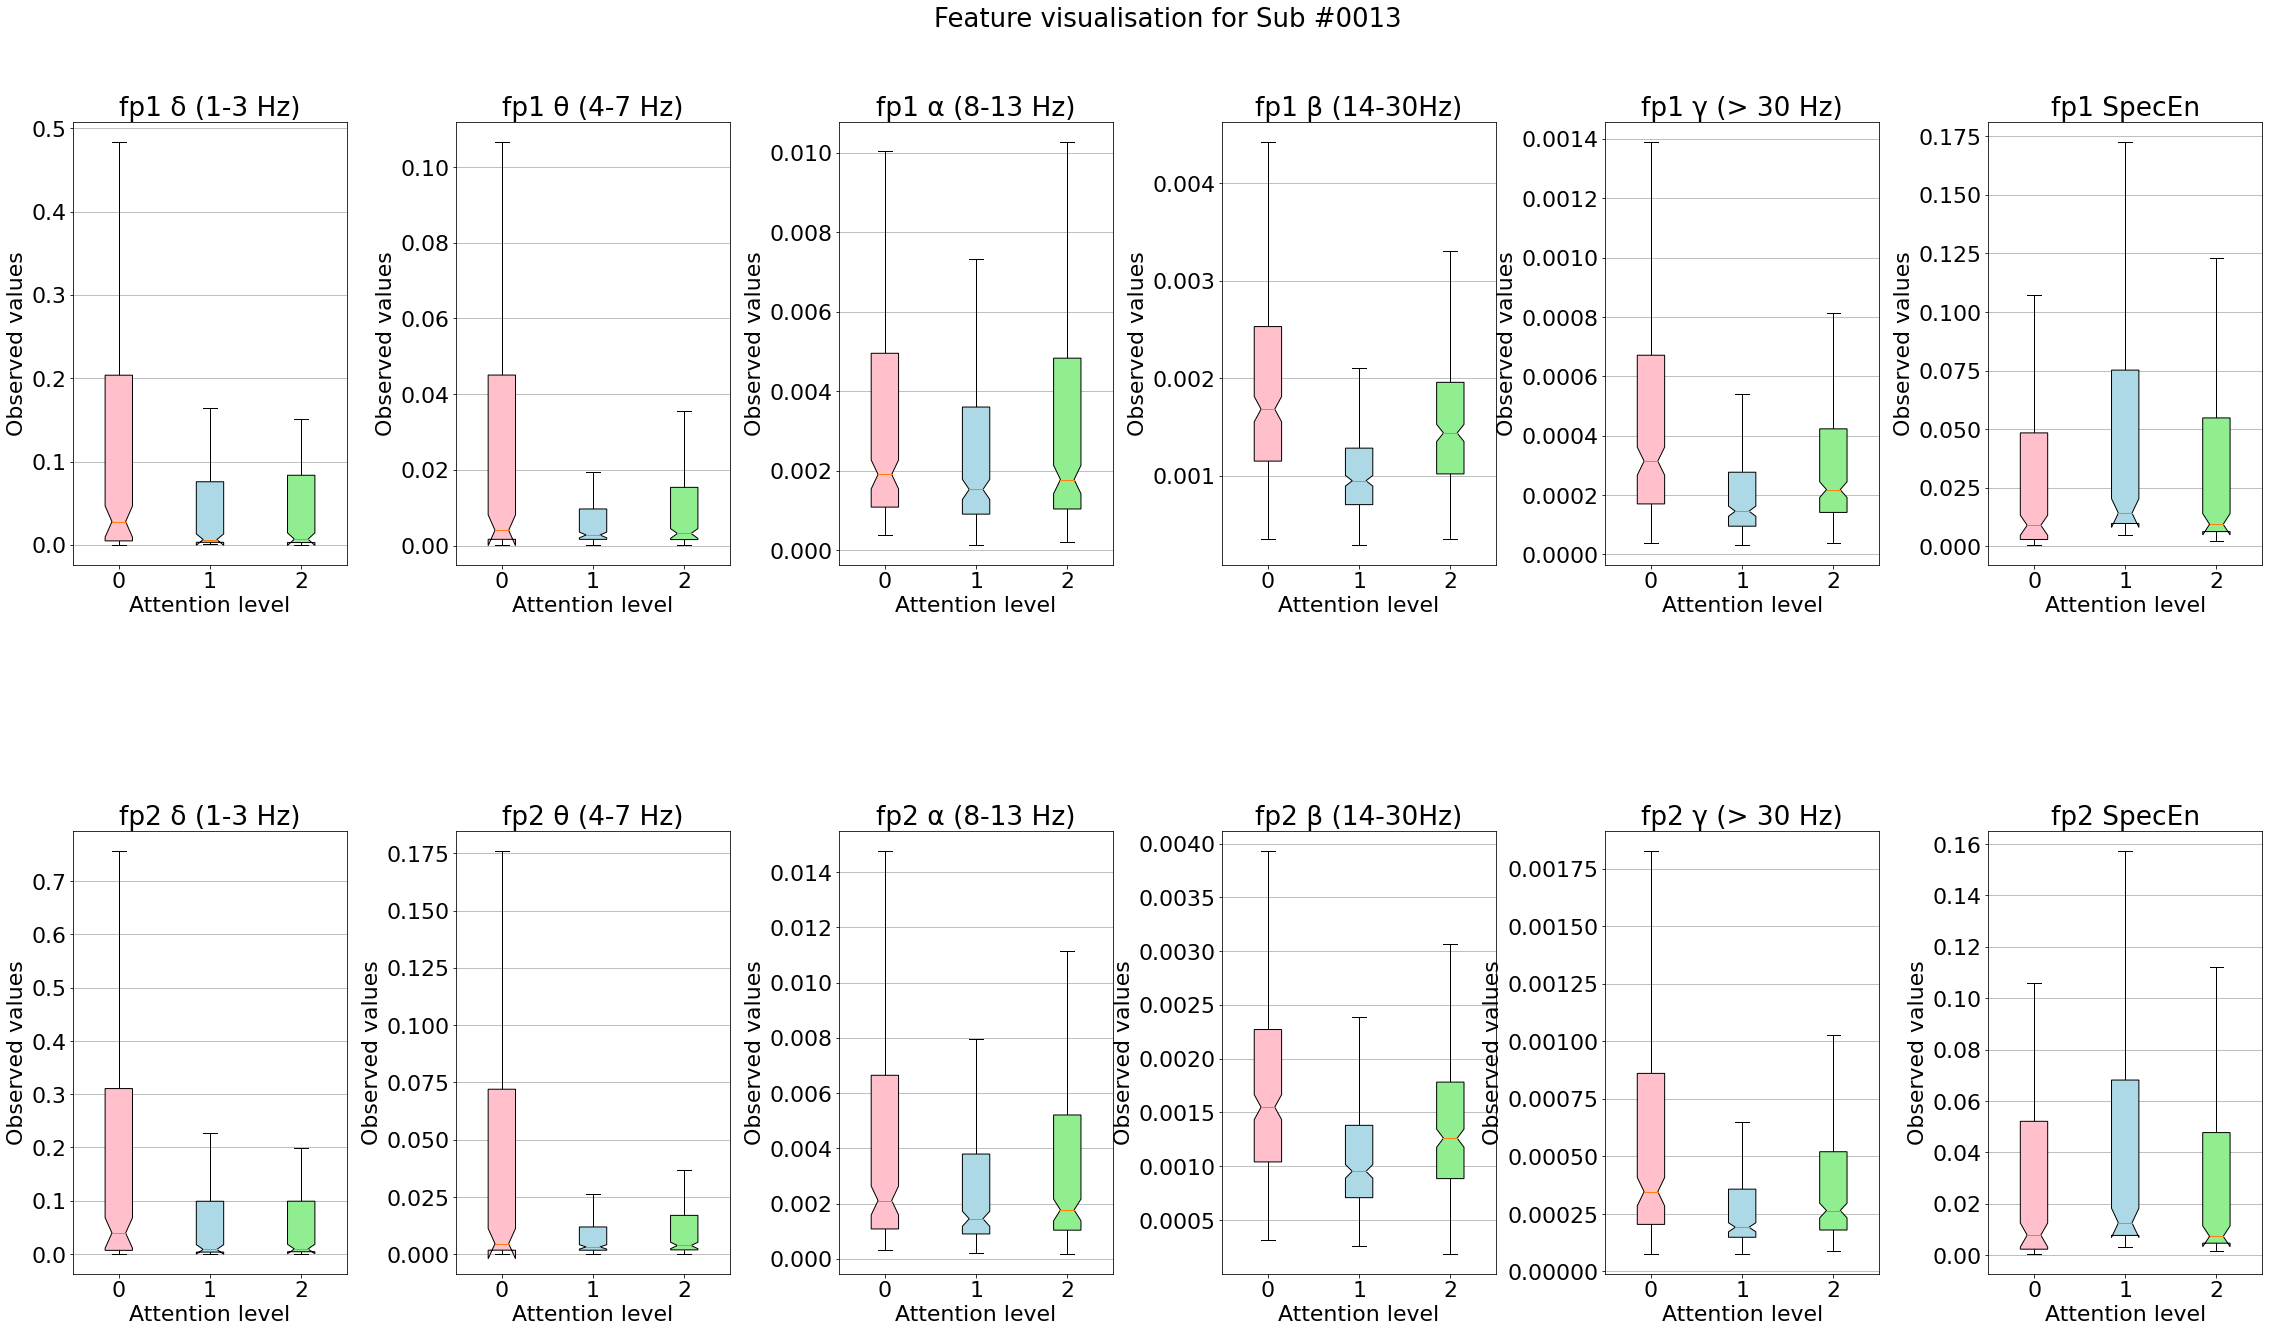

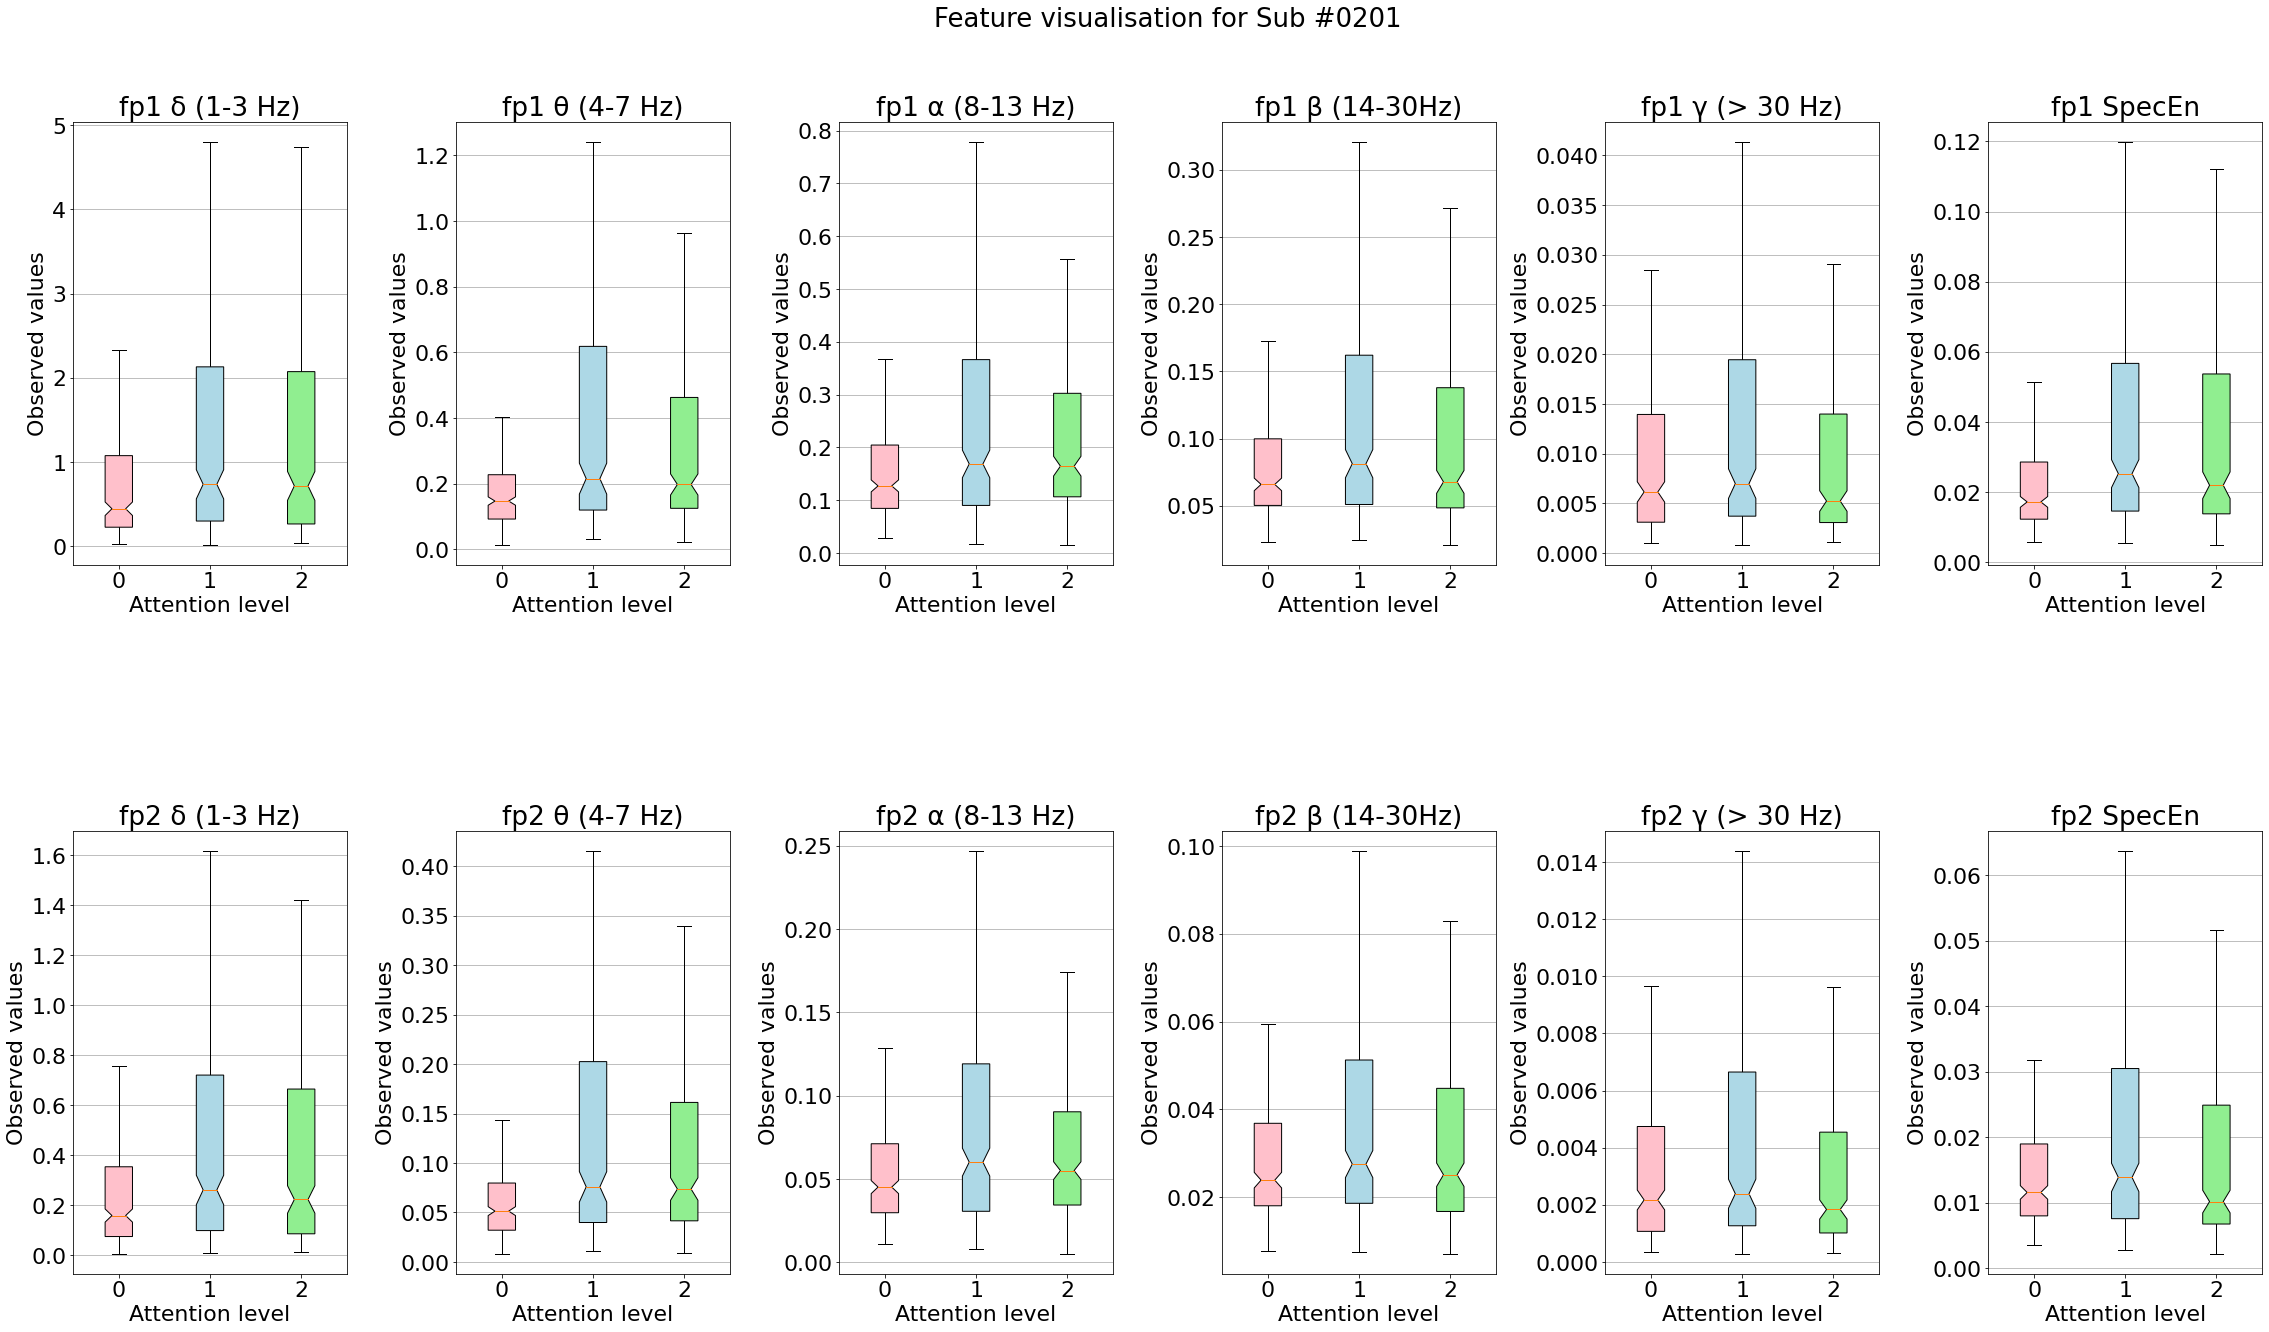

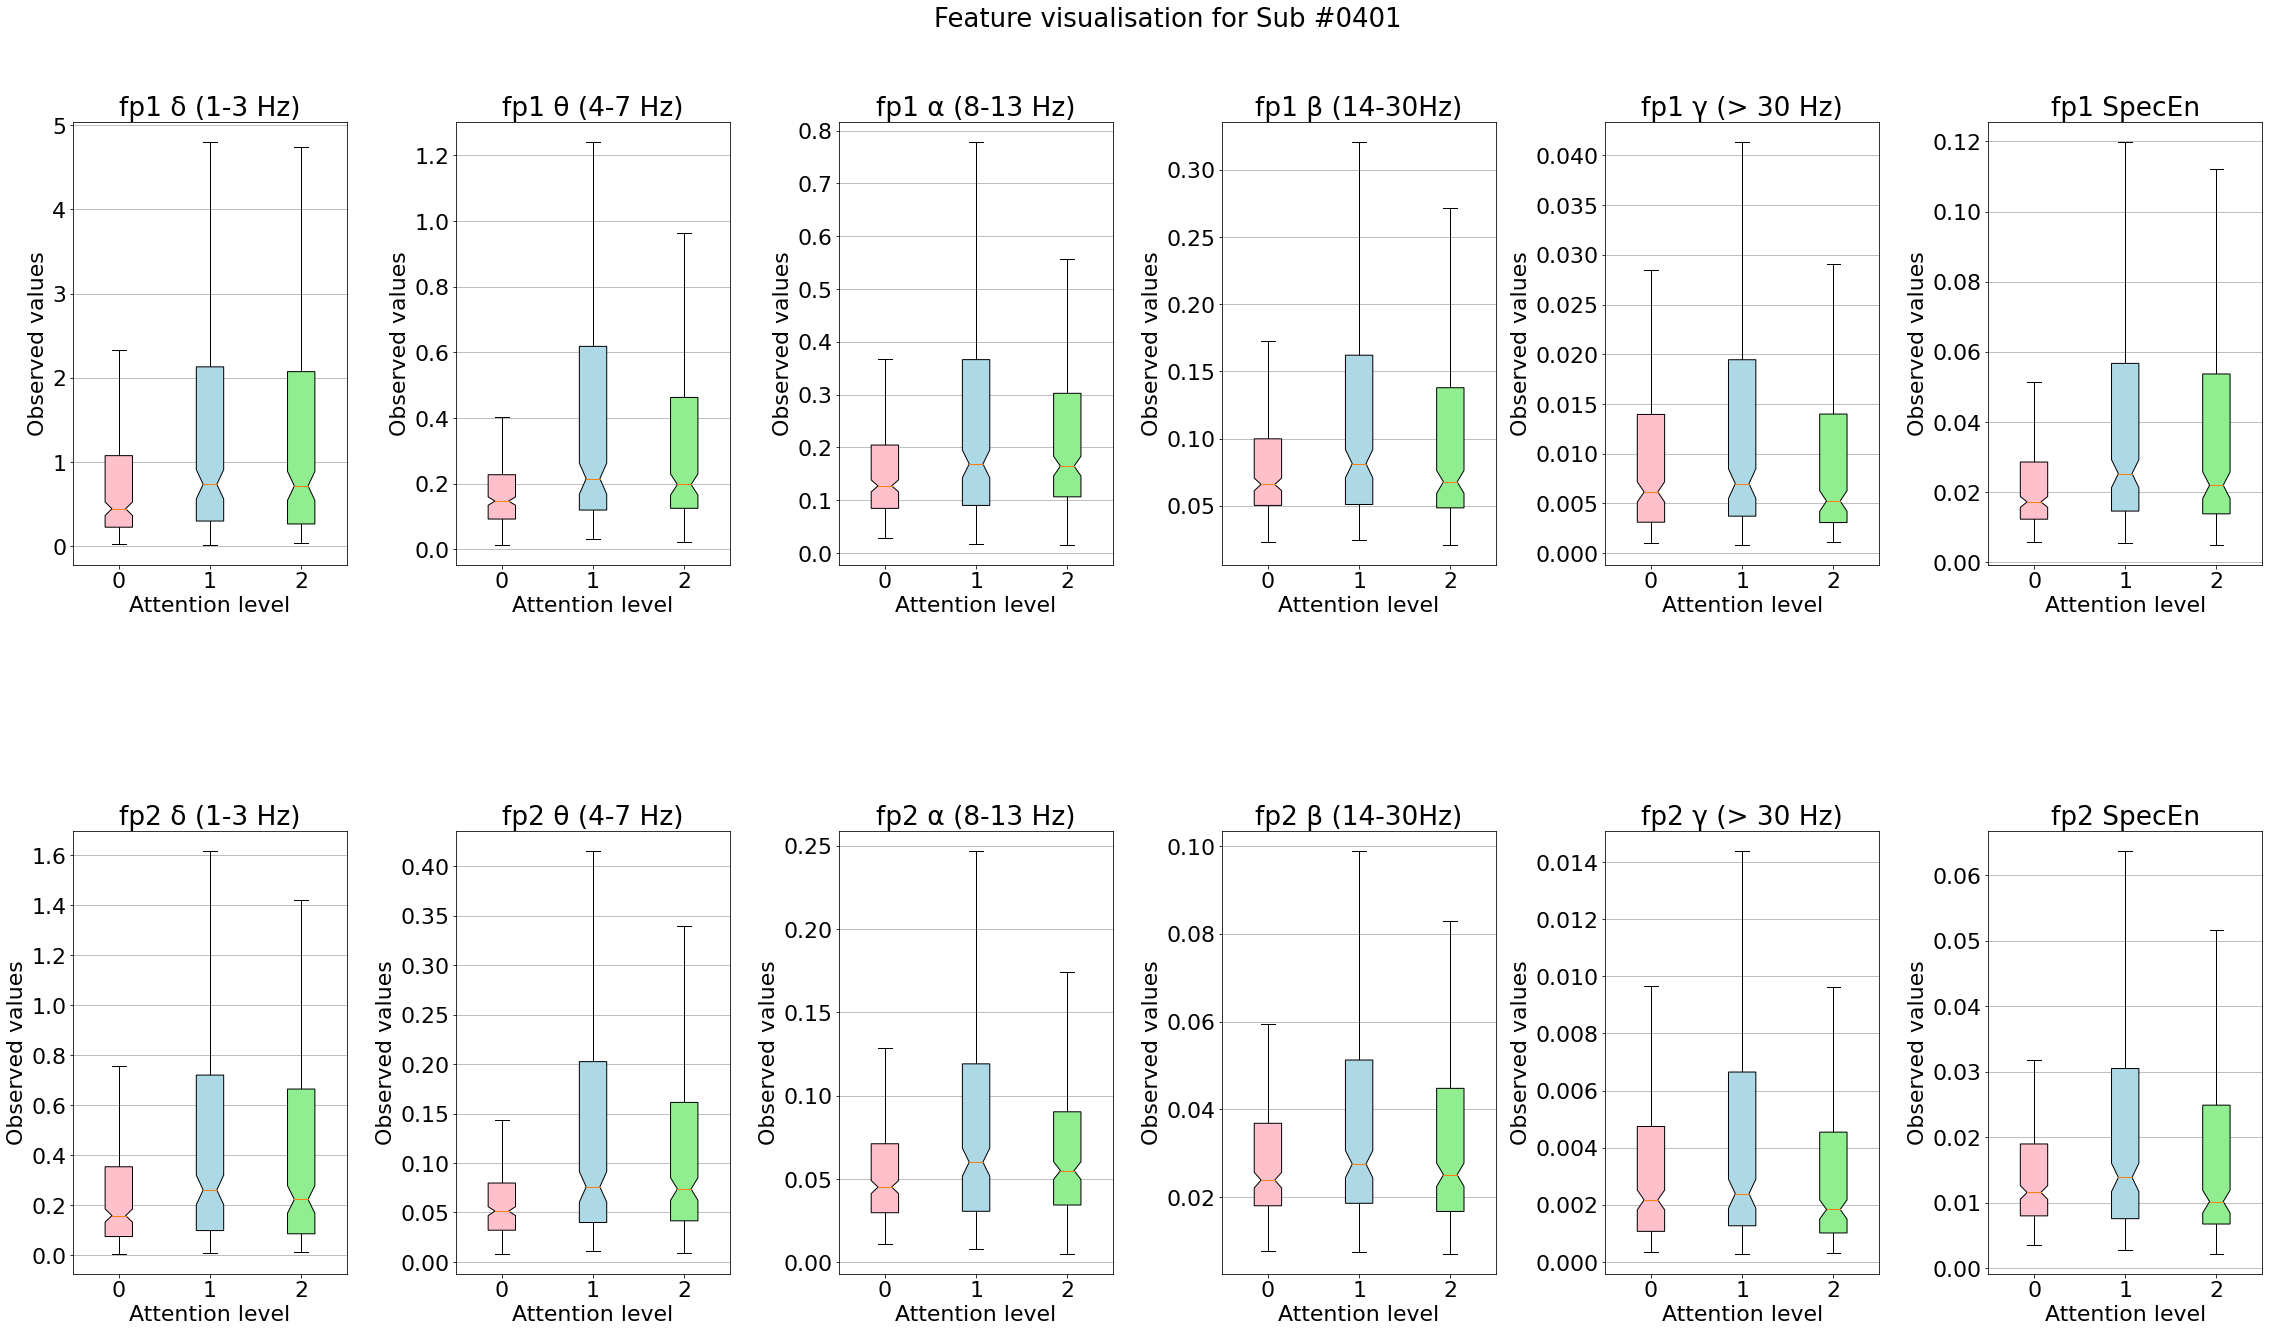

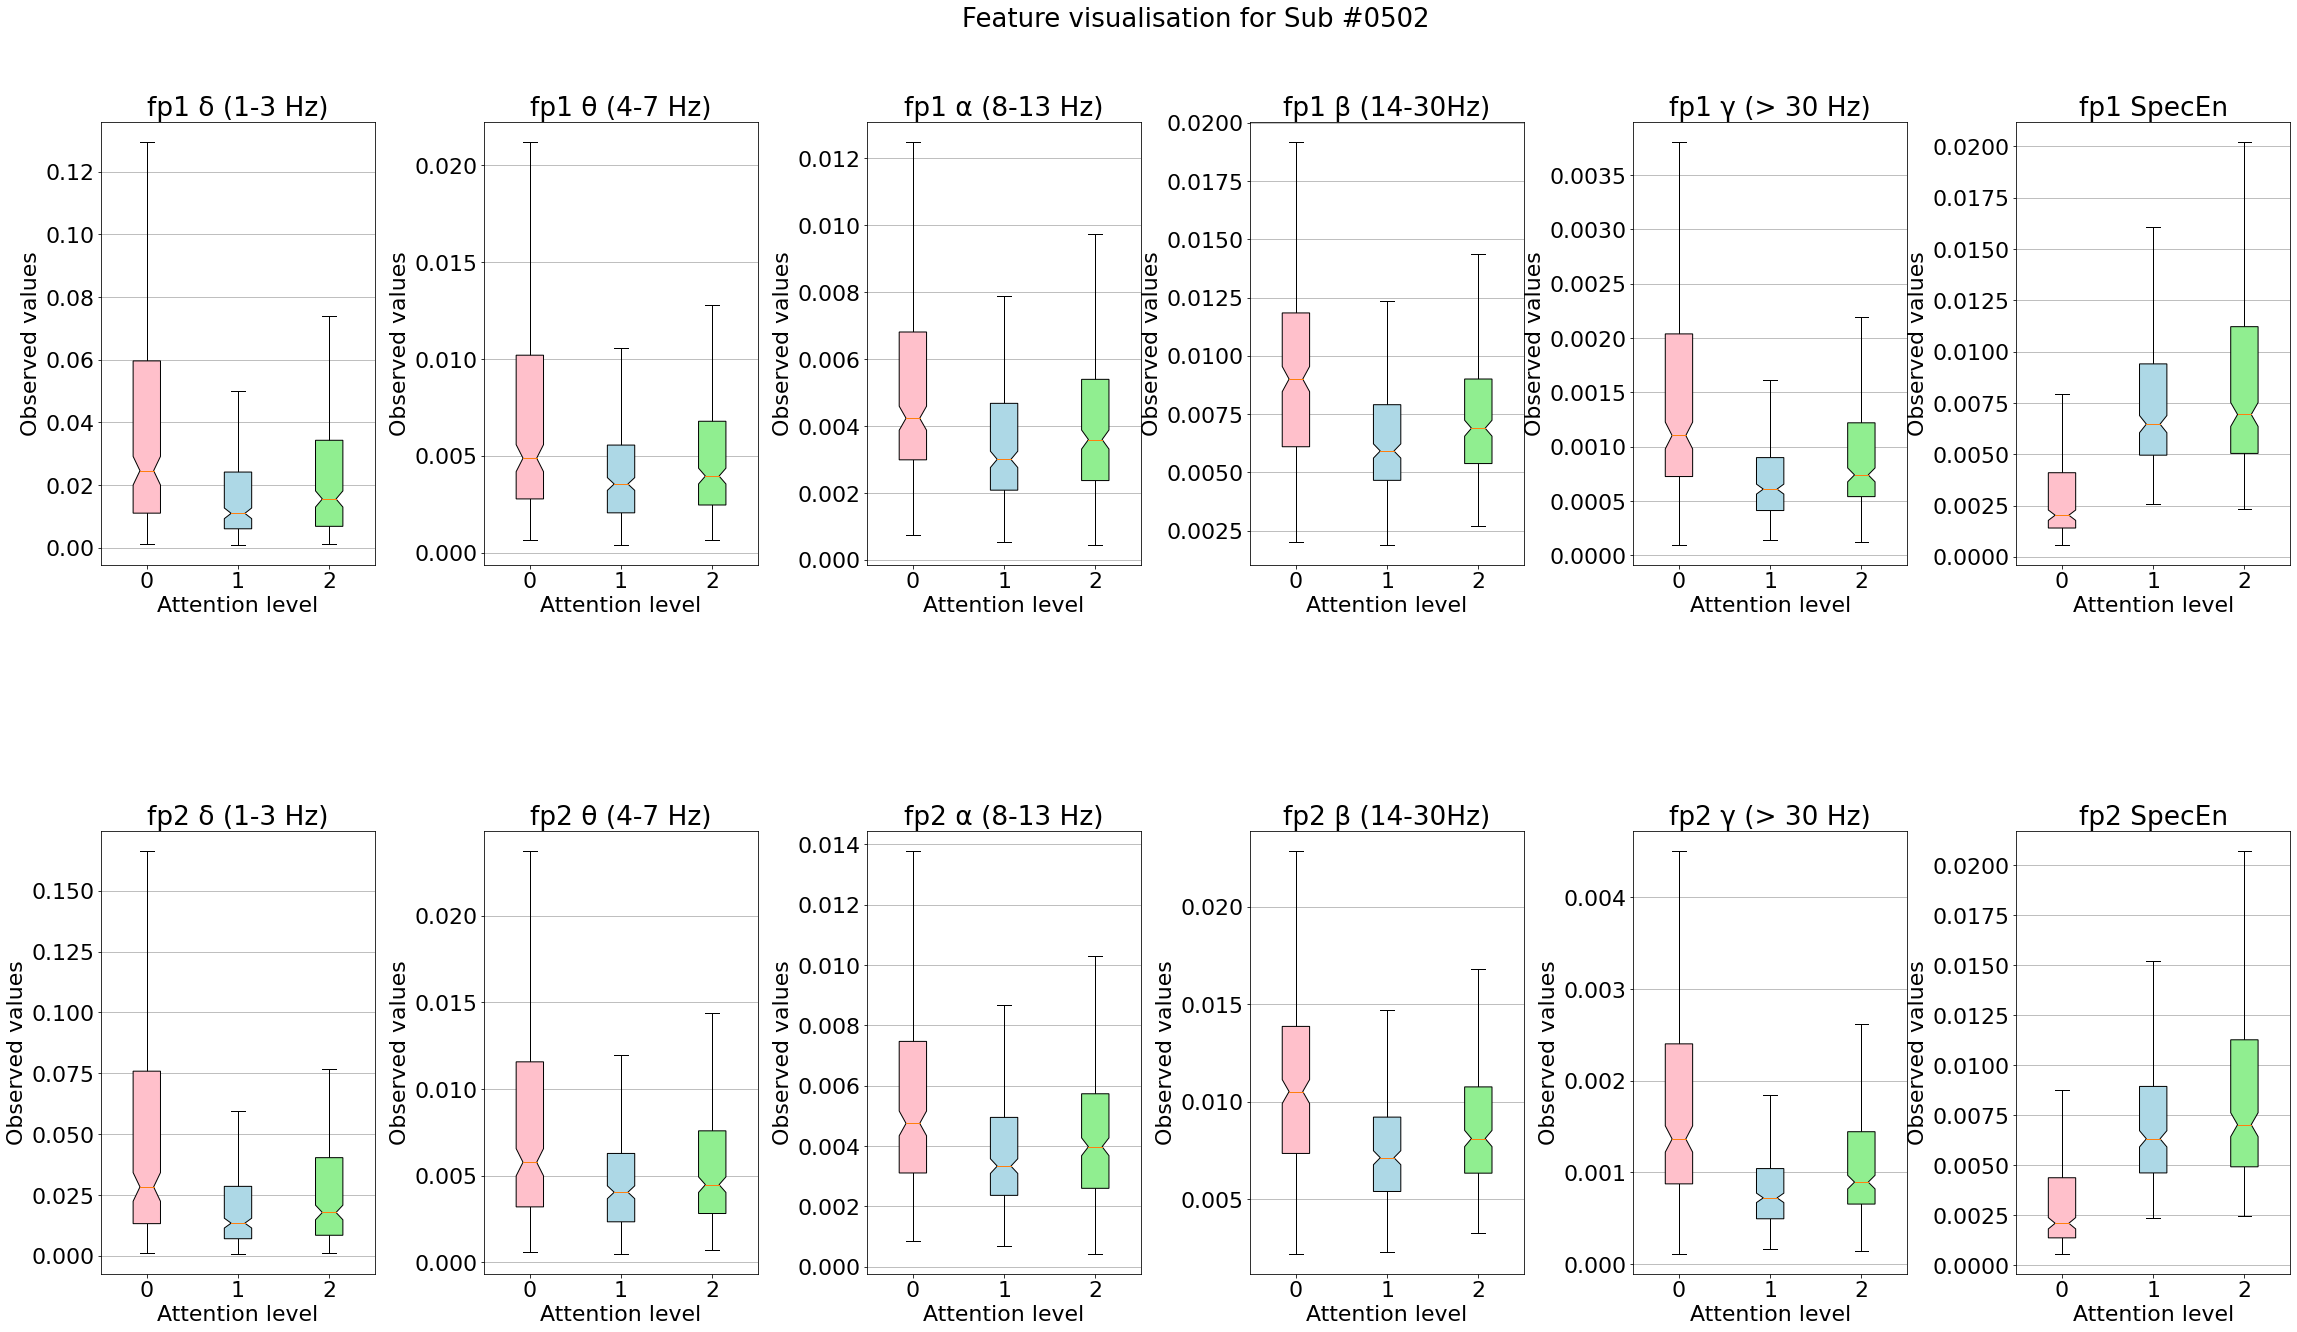

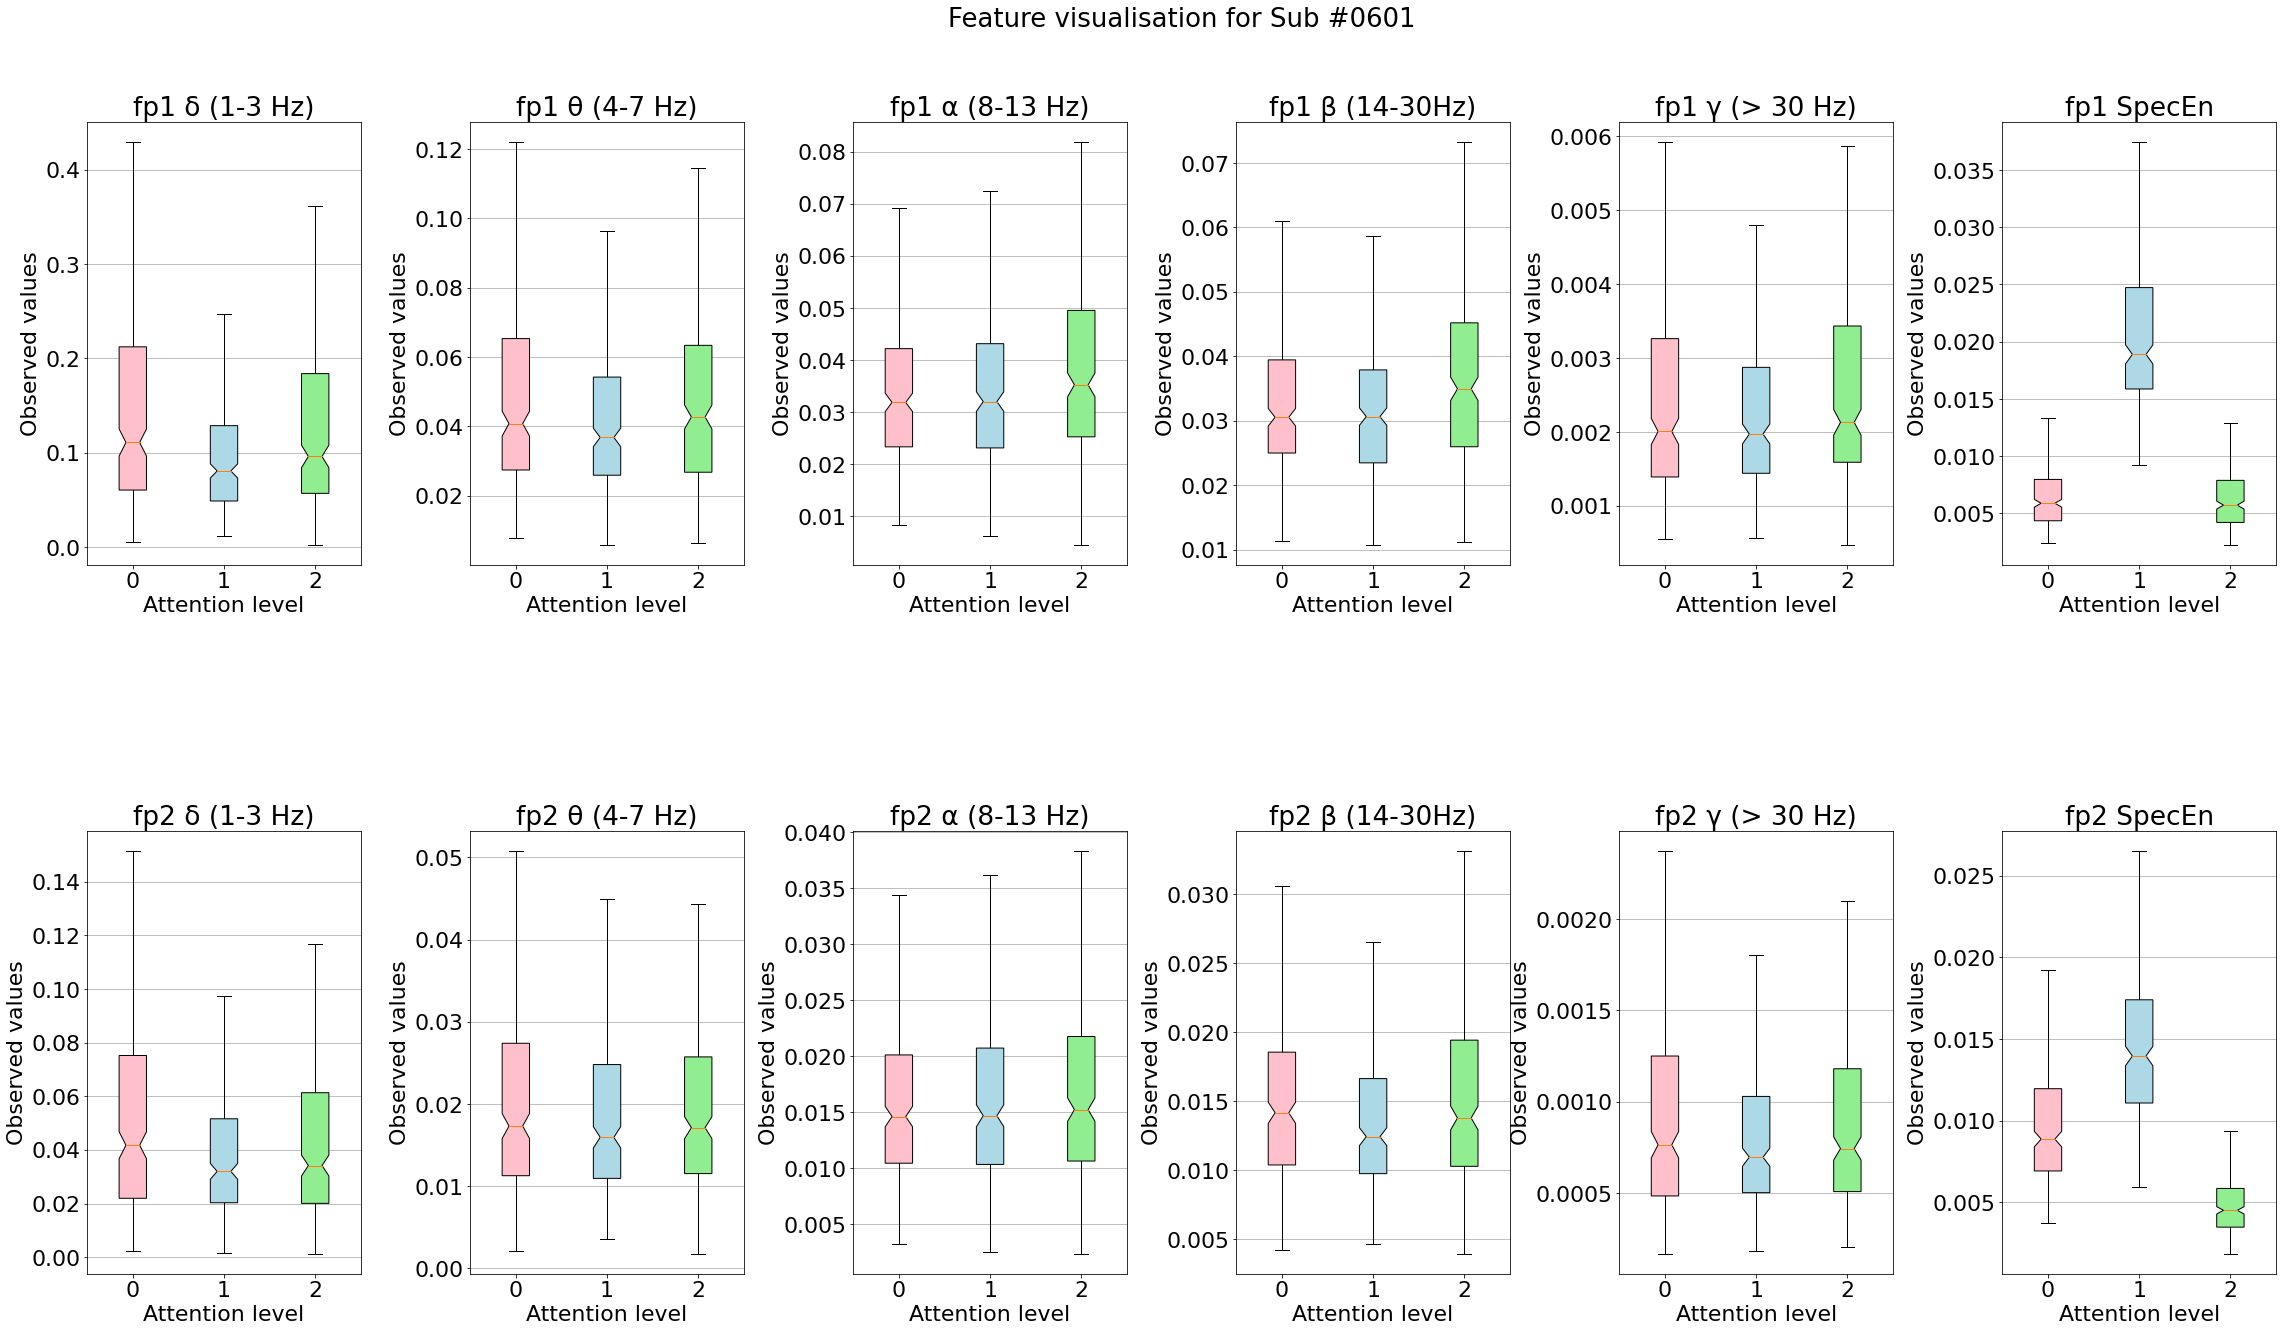

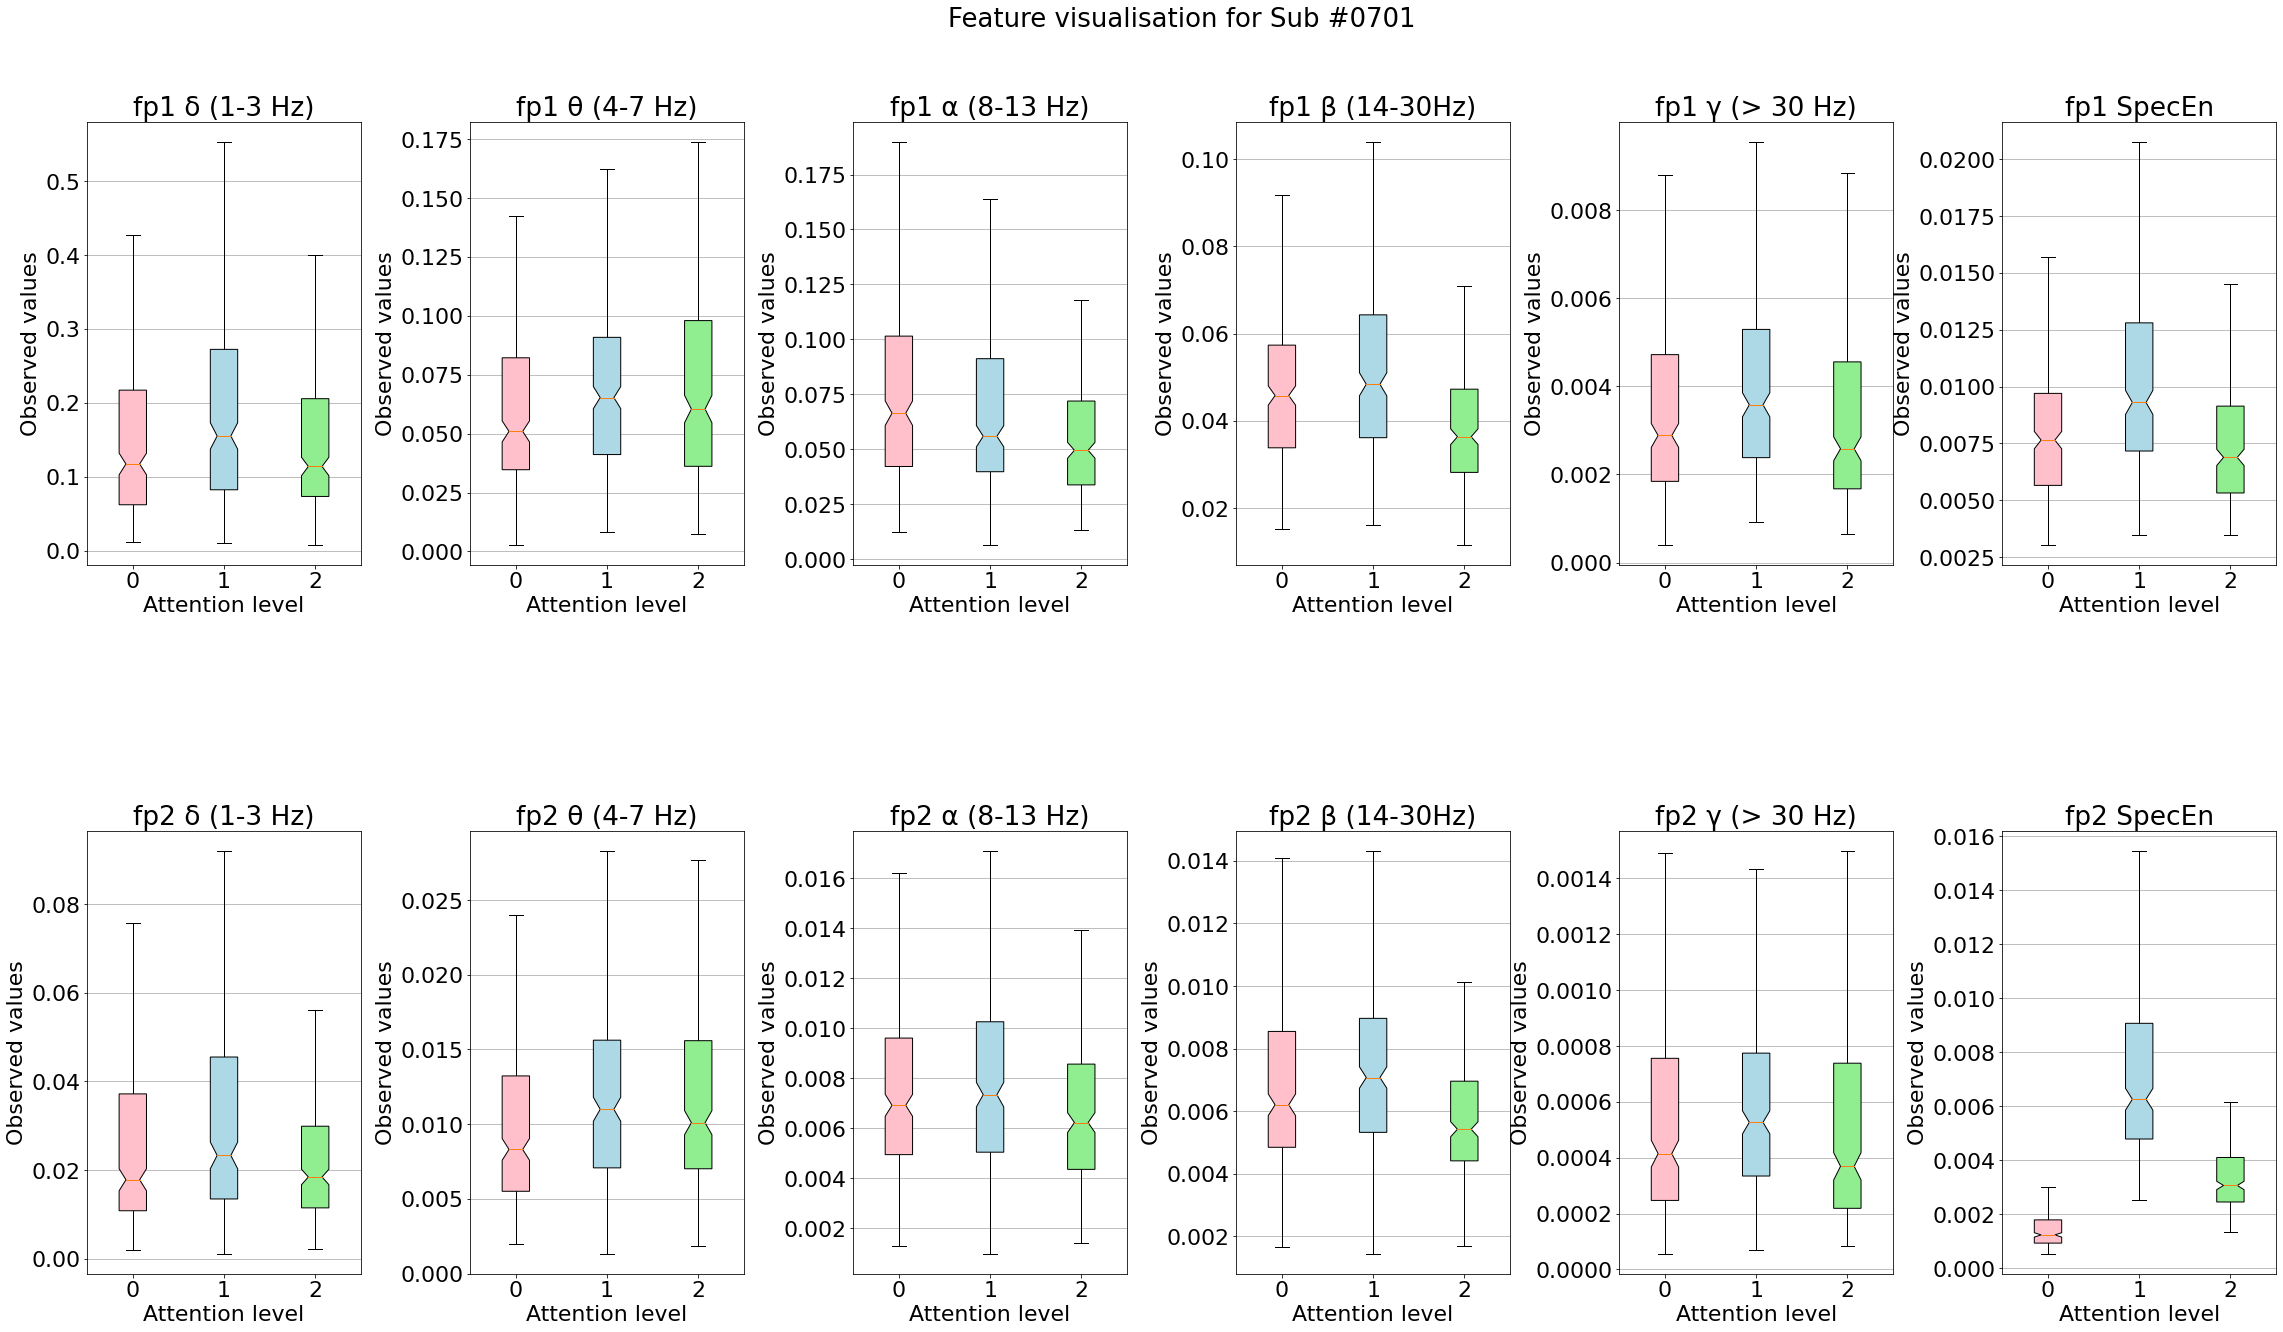

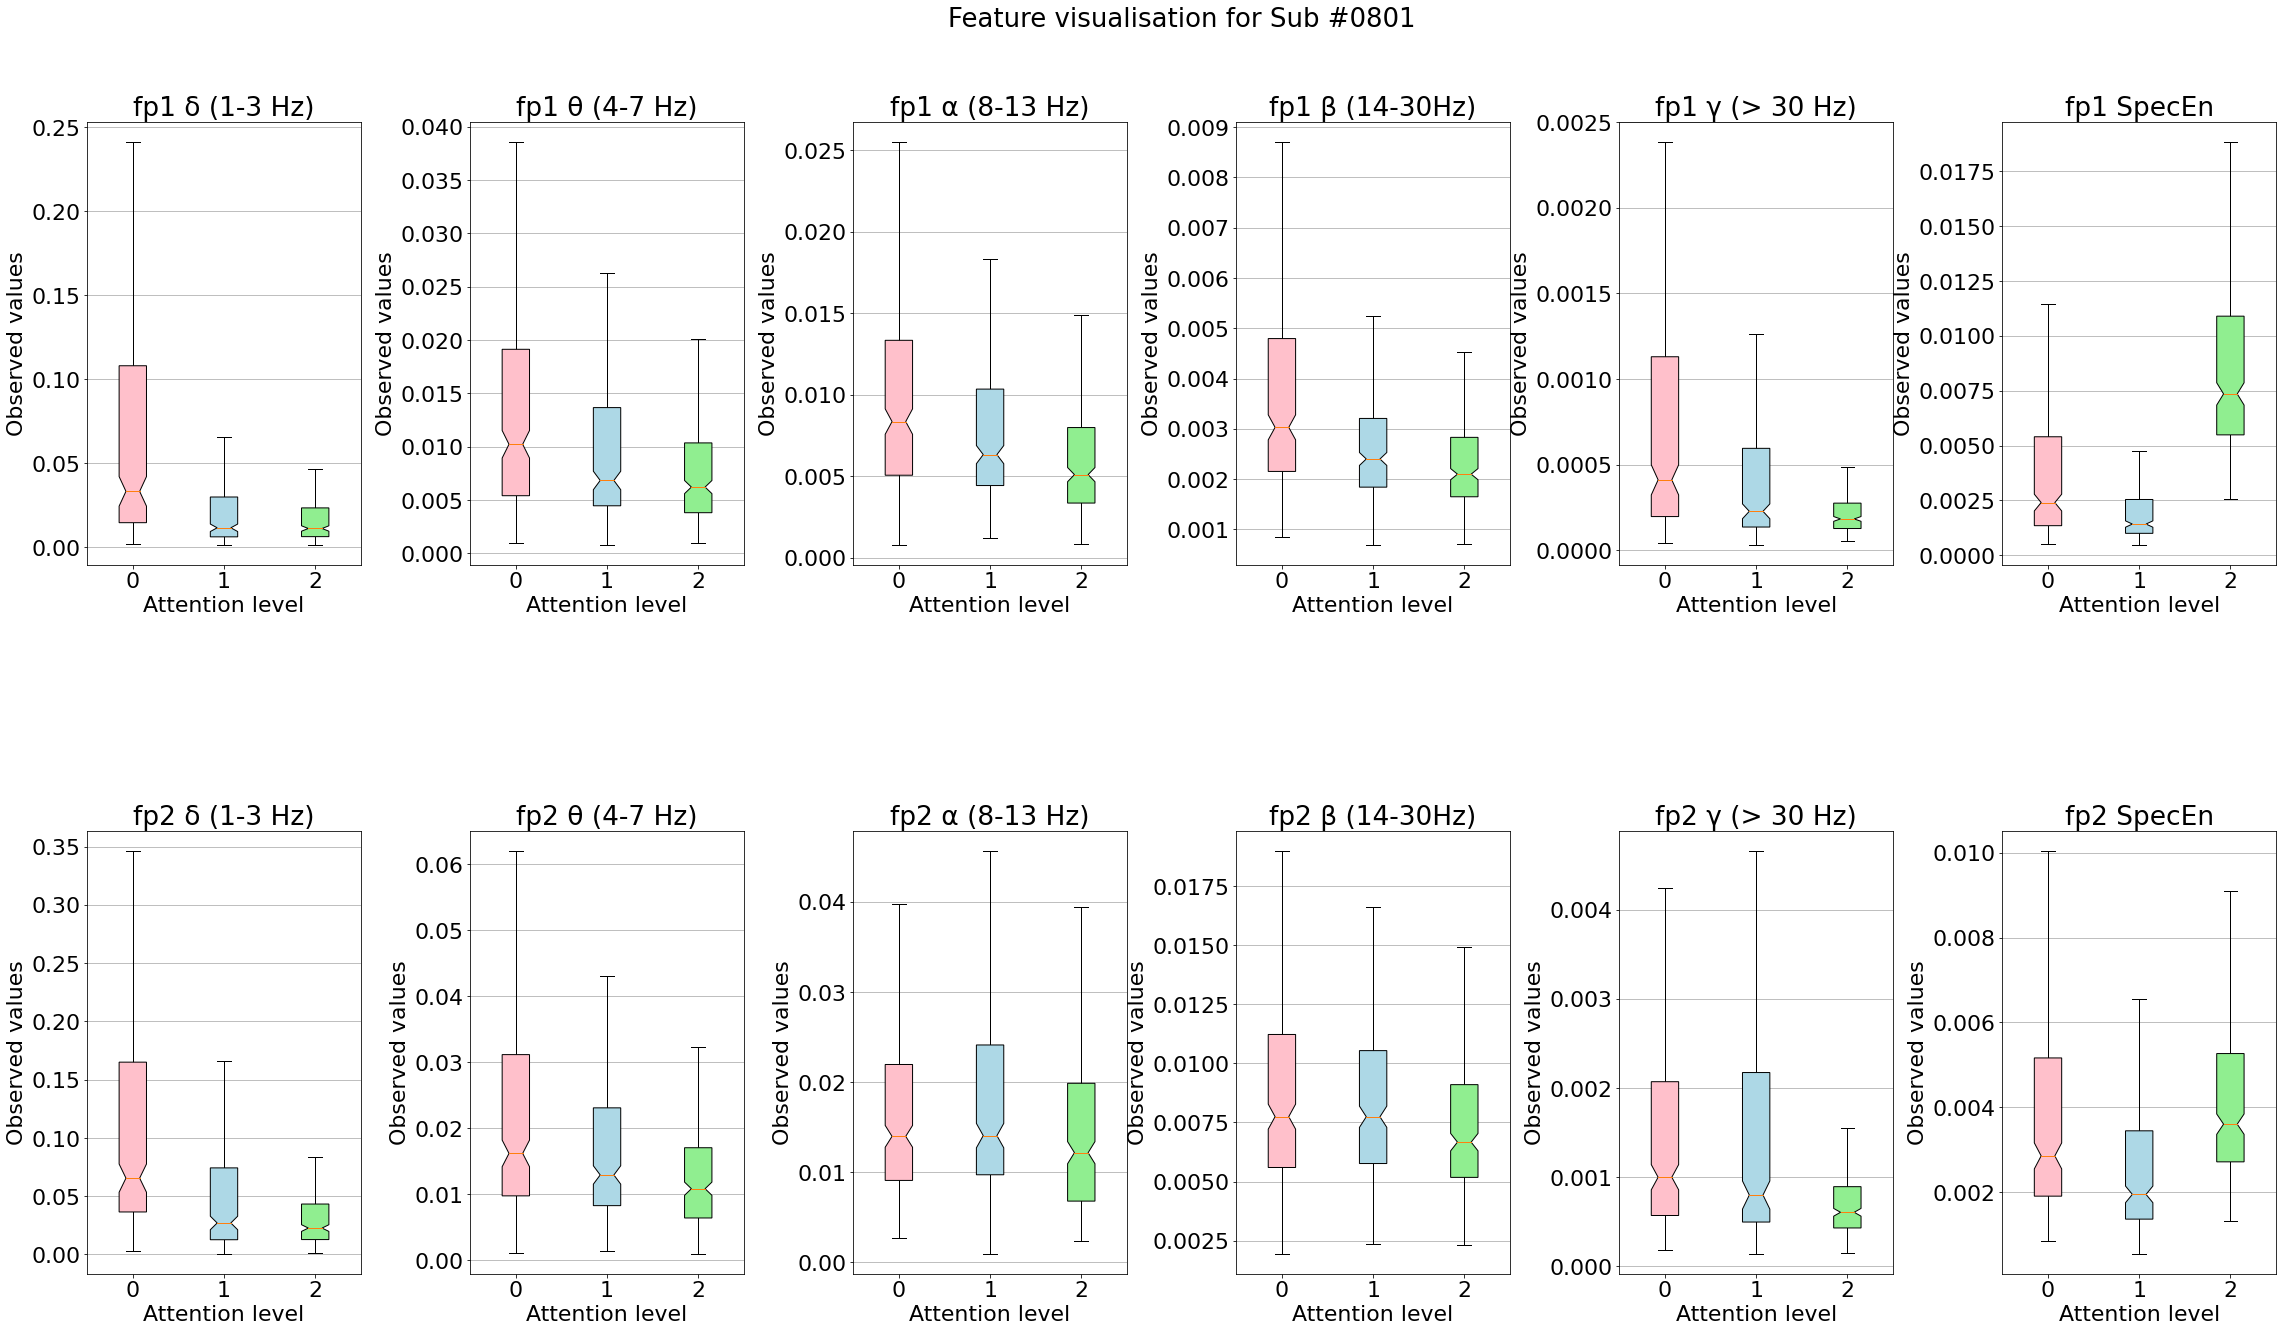

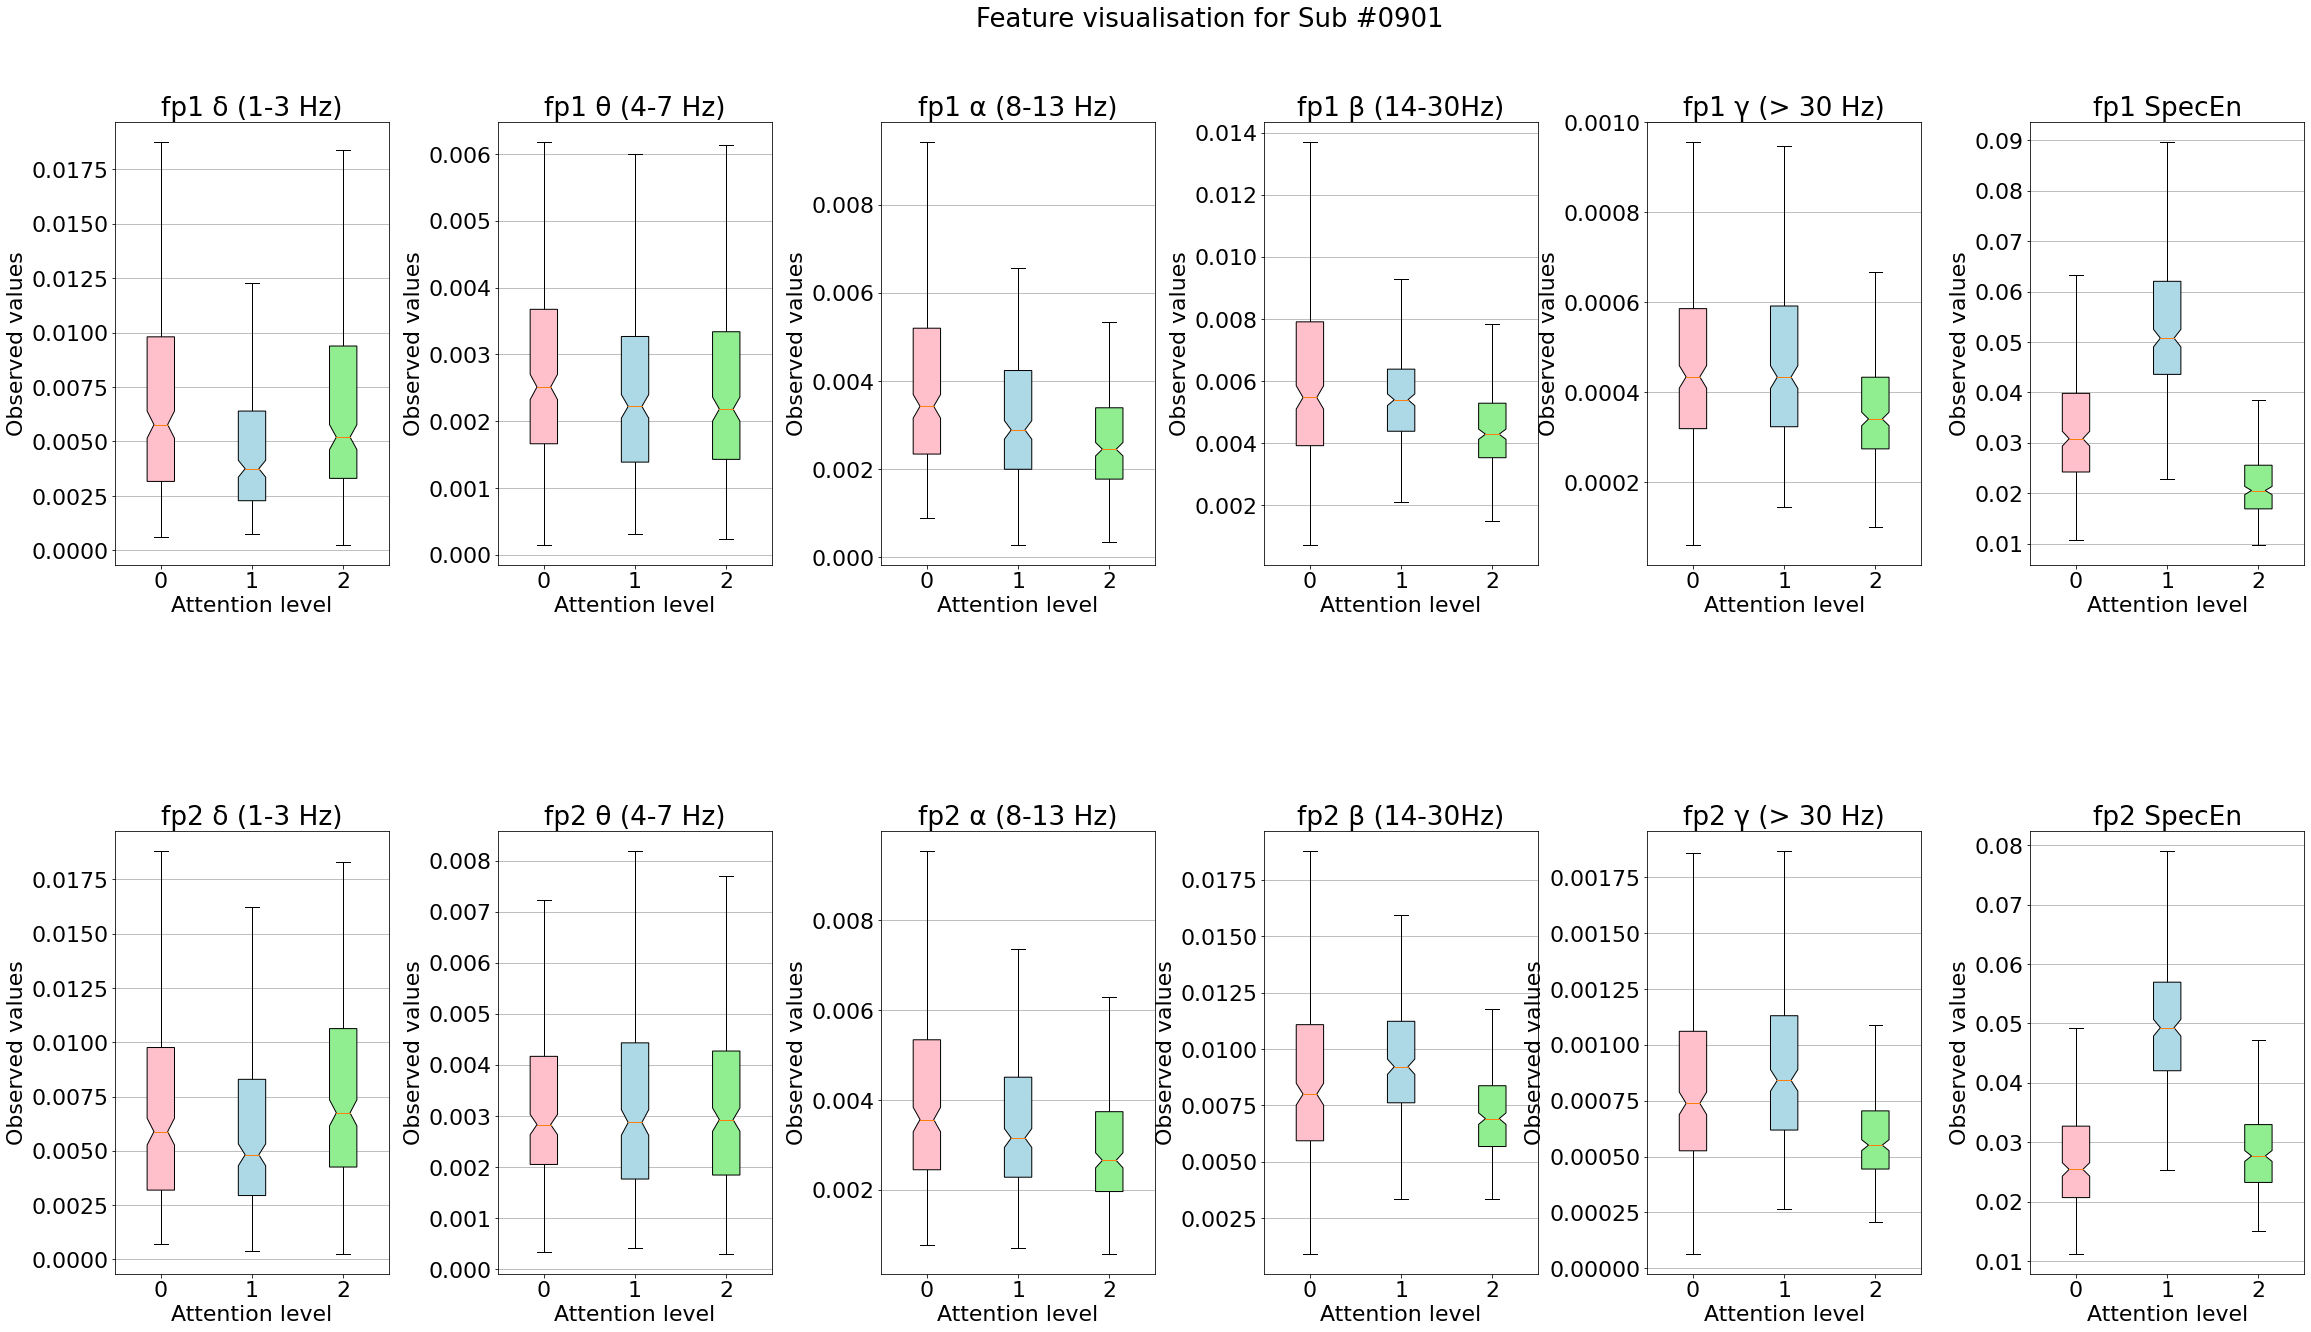

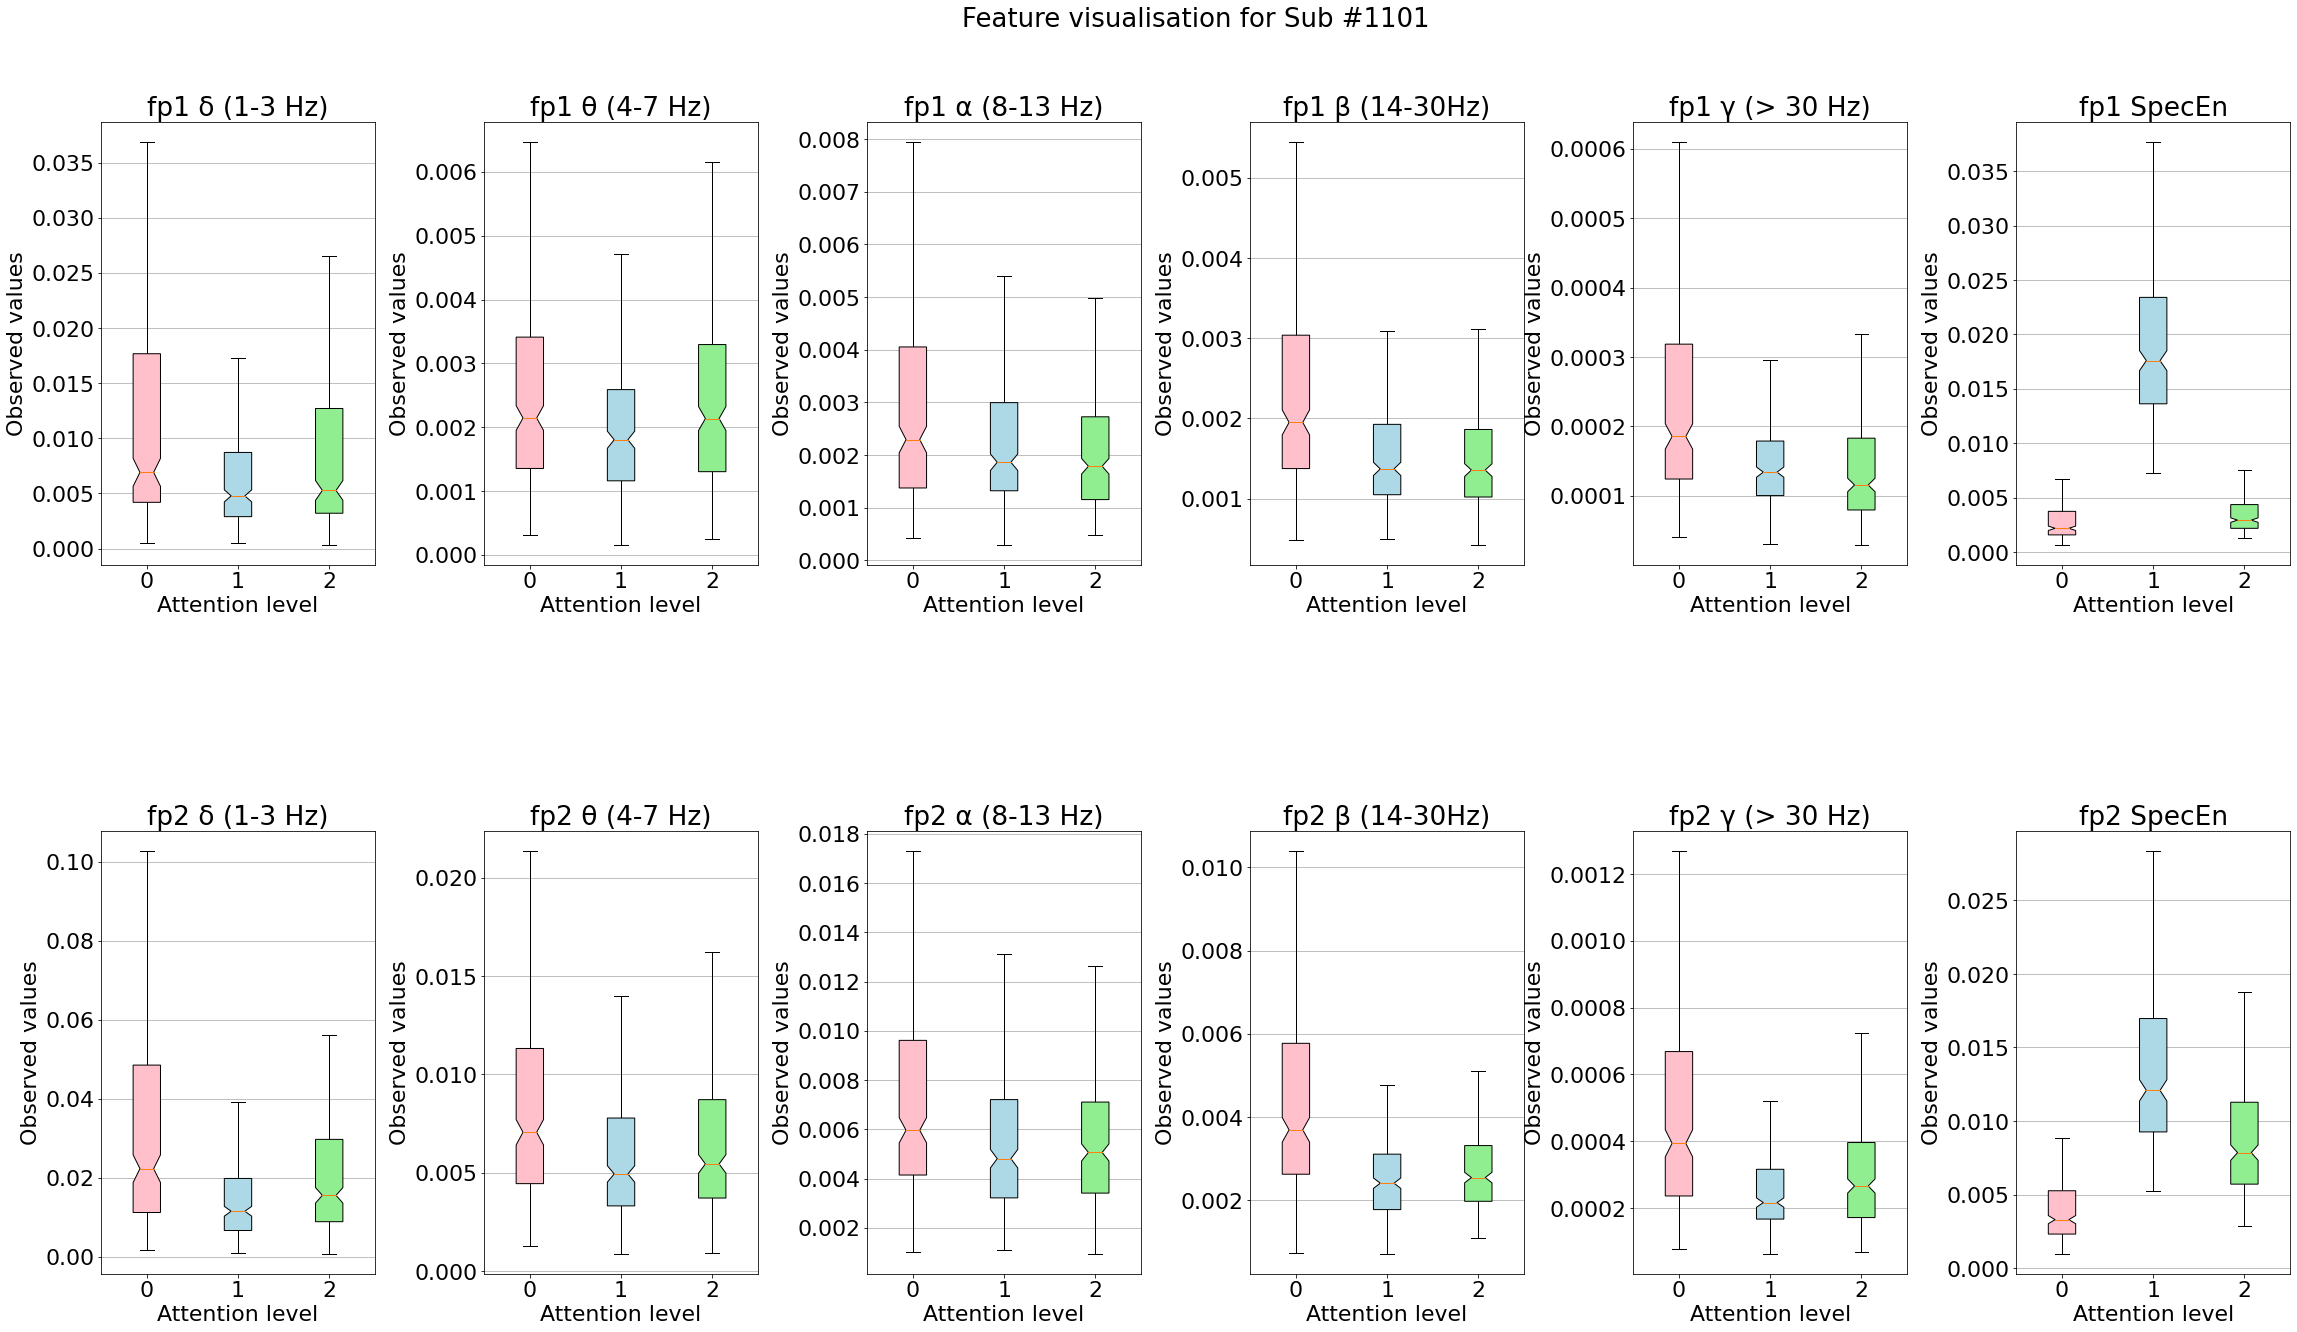

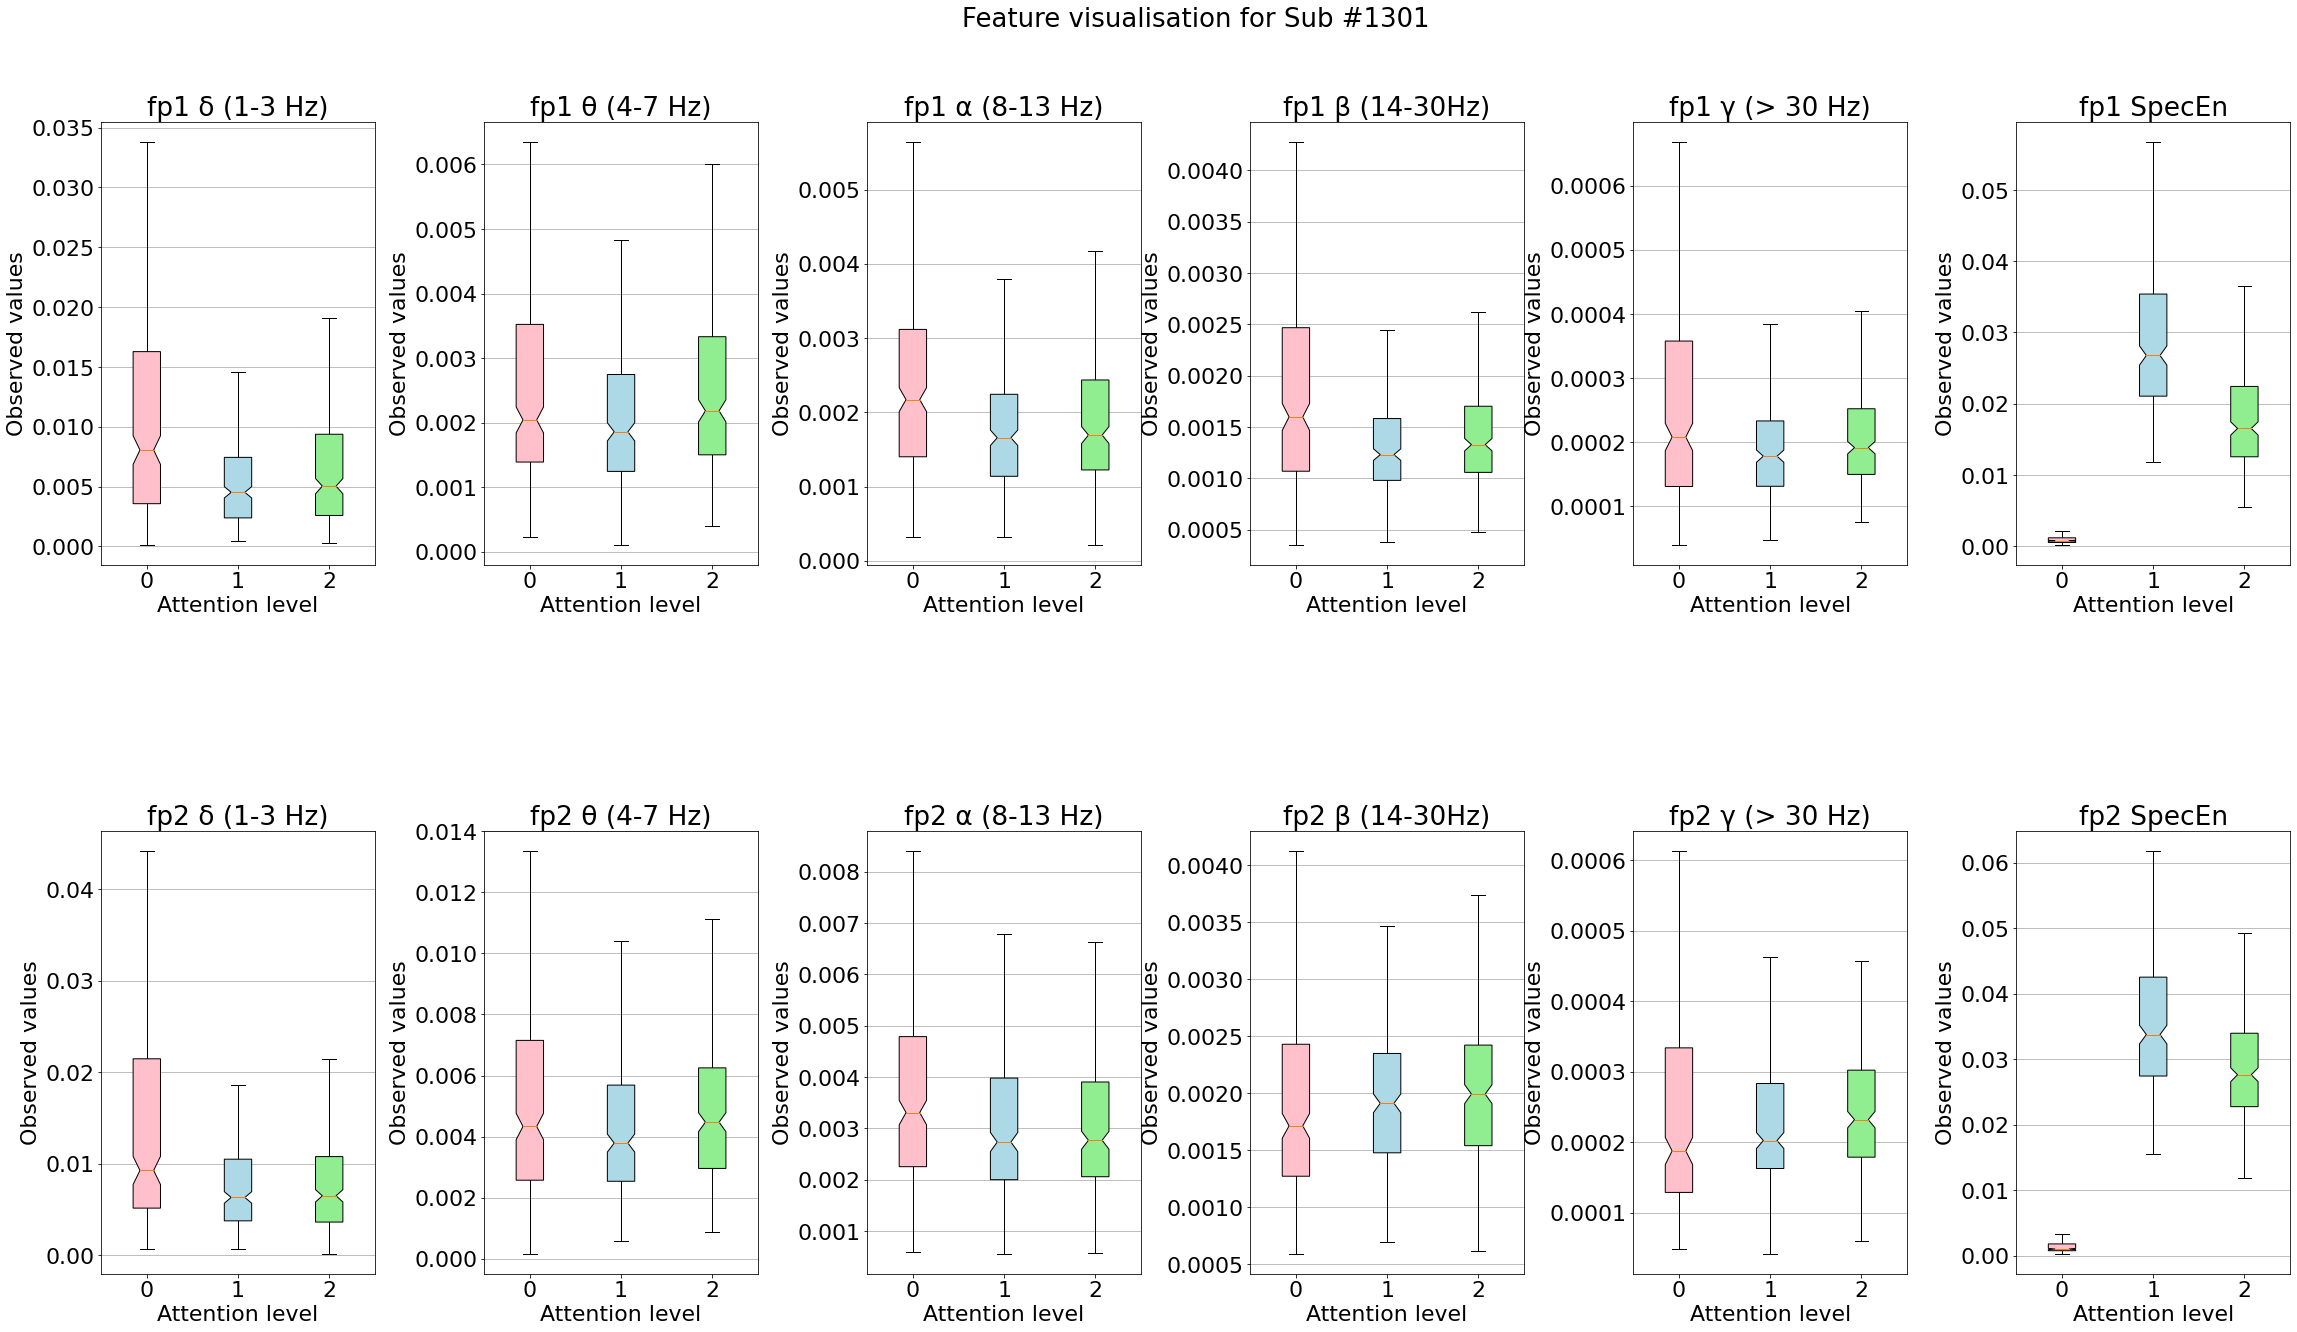

In [121]:
features = [
    'fp1 δ (1-3 Hz)','fp1 θ (4-7 Hz)','fp1 α (8-13 Hz)','fp1 β (14-30Hz)','fp1 γ (> 30 Hz)', 'fp1 SpecEn',
    'fp2 δ (1-3 Hz)','fp2 θ (4-7 Hz)','fp2 α (8-13 Hz)','fp2 β (14-30Hz)','fp2 γ (> 30 Hz)', 'fp2 SpecEn',
           ]

subs = ['0002','0004','0005','0006','0007','0009','0013','0201',
        '0401','0502','0601','0701','0801','0901','1101','1301']


for train in subs:
    print("========= Feature visualisation for Subject #", train)
    fname = "feature_attention_"+train+"_low_fp1fp2_2s_resampled500Hz.pkl"
    f = open(os.path.join(r"..\data\data3_attention", fname), 'rb')
    df_X, df_y = pickle.load(f)
    print(df_X.shape)
    f.close()

    nrows = 2
    ncols = 6
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(38, 20))
    fig.suptitle('Feature visualisation for Sub #' + str(train), fontsize=26)

    for ft in range(12):
        
        a0 = []
        a1 = []
        a2 = []

        for i, x in enumerate(df_X):
            if df_y[i] == 0:
                a0.append(x[ft])
            if df_y[i] == 1:
                a1.append(x[ft])
            if df_y[i] == 2:
                a2.append(x[ft])

        a = np.transpose(np.array([a0, a1, a2]))
        
        labels = [0,1,2]

        r = ft // ncols
        c = ft % ncols
        ax[r][c].set_title(features[ft])

        bplot_lr = ax[r][c].boxplot(a,
                               vert = True,
                               notch = True,
                               patch_artist=True,
                               labels=labels,
                               showfliers=False
                              )
        colors = ['pink', 'lightblue', 'lightgreen']
        for patch, color in zip(bplot_lr['boxes'], colors):
            patch.set_facecolor(color)

        ax[r][c].yaxis.grid(True)
        ax[r][c].set_xlabel('Attention level')
        ax[r][c].set_ylabel('Observed values')

    plt.subplots_adjust(left=0.1, 
                        bottom=0.1,  
                        right=0.9,  
                        top=0.9,  
                        wspace=0.4,  
                        hspace=0.6) 
    plt.draw()
    plt.savefig(r"..\data\data3_attention\fig\FeatureVisualisation"+train+".jpg")